In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from bcnf.simulation.physics import physics_ODE_simulation, calculate_point_of_impact
from bcnf.simulation.camera import record_trajectory

In [10]:
def get_cam2_position(l):
    cam2_x = -25 * np.cos(l)
    cam2_y = 25 * np.sin(l)
    cam2_z = 1.5

    return np.array([cam2_x, cam2_y, cam2_z])

# create function to sample uniformy for the ballisitc parameters

def sample_ballistic_parameters():
    # pos
    # x0_x = np.random.uniform(-40, 40)   # person can stand outside the circle, but not too far away
    # x0_y = np.random.uniform(-40, 40)
    # x0_z = np.random.uniform(1, 2)      # height of the average persones head is somewhere here

    r = np.sqrt(np.random.uniform(0, 1)) * 40
    phi = np.random.uniform(0, 2 * np.pi)

    x0_x = r * np.cos(phi)
    x0_y = r * np.sin(phi)
    x0_z = np.random.uniform(1, 2)
    
    x0 = np.array([x0_x, x0_y, x0_z])

    # velo
    # v0_x = np.random.uniform(-25, 25)   # 25 m/s (90 km/h) is very well possible for a handball throw
    # v0_y = np.random.uniform(-25, 25)
    # v0_z = np.random.uniform(-25, 25)

    r_v = np.sqrt(np.random.uniform(0, 1)) * 25
    phi_v = np.random.uniform(0, 2 * np.pi)

    v0_x = r_v * np.cos(phi_v)
    v0_y = r_v * np.sin(phi_v)
    v0_z = np.random.uniform(-25, 25)

    v0 = np.array([v0_x, v0_y, v0_z])

    # grav
    g_z = np.random.uniform(-0.08 * 9.81, -2.5 * 9.81) # from ~0.779 up to ~24.79 (Triton to Jupiter)
    # g_z = np.random.normal(-9.81, 0.01) 

    g = np.array([0, 0, g_z])

    # wind
    # w_x = np.random.uniform(-20, 20)    # includes up to the definition of "stürmischer Wind" (https://de.wikipedia.org/wiki/Windgeschwindigkeit)
    # w_y = np.random.uniform(-20, 20)
    # w_z = np.random.uniform(-20, 20)

    r_x = np.sqrt(np.random.uniform(0, 1)) * 20
    phi_x = np.random.uniform(0, 2 * np.pi)

    w_x = r_x * np.cos(phi_x)
    w_y = r_x * np.sin(phi_x)
    w_z = np.random.uniform(-20, 20)

    w = np.array([w_x, w_y, w_z])

    # b
    # density of atmosphere
    rho = np.random.uniform(0, 1.5)     # excluding venus with insane 67 kg/m^3...
    
    # area of thown object
    A = np.random.uniform(0.003, 0.15)  # from a small ball (3 cm radius) to a big ball (20 cm radius)

    # drag coefficient
    Cd = np.random.uniform(0.04, 1.42)  # reference for 3D objects (https://en.wikipedia.org/wiki/Drag_coefficient)

    b = rho * A * Cd    # drag coefficient (do we need a factor of 0.5 here?)

    # mass
    m = np.random.uniform(0.056, 0.62)  # from a tennis ball (56 g) to a basketball (620 g)

    # thrust
    a_x = np.random.uniform(-5, 5)      # thats just wild guessing
    a_y = np.random.uniform(-5, 5)
    a_z = np.random.uniform(-5, 5)

    a = np.array([a_x, a_y, a_z])

    # second cam position
    l = np.random.uniform(0, 2 * np.pi)

    # average radius of ball
    r = (A/np.pi)**0.5

    return x0, v0, g, w, b, m, a, l, r, A, Cd, rho

In [3]:
# sample uniformly while the pandas df has less than 1000 rows


df = pd.DataFrame(columns=[
    'x0_x', 'x0_y', 'x0_z',
    'v0_x', 'v0_y', 'v0_z',
    'g', 
    'w_x', 'w_y', 'w_z',
    'b', 'A', 'Cd', 'rho', 'm', 
    'a_x', 'a_y', 'a_z',
    'l', 'r'])

SPF = 1 / 30
T = 3
cam1_pos = np.array([-25, 0, 1.5])

pbar = tqdm(total=6000)
    
simulations = []
accepted_count = 0
rejected_count = 0

while len(simulations) < 6000:
    x0, v0, g, w, b, m, a, l, r, A, Cd, rho = sample_ballistic_parameters()
    traj = physics_ODE_simulation(x0, v0, g, w, b, m, a, T, SPF)
    
    # check whether ball is thrown further than 5 m
    poi = calculate_point_of_impact(x0, v0, g, w, b, m, a, dt=0.01)[:2]
    if np.linalg.norm(poi - x0[:2]) <= 5:
        rejected_count += 1
        continue
    
        
    # check if ball is throw less than 100 m
    # 50% time +3h
    if np.linalg.norm(poi - x0[:2]) >= 100:
        rejected_count += 1
        continue
                        
    cam2_pos = get_cam2_position(l)

    cam1 = record_trajectory(traj, (16,9), 70.0, cam1_pos, make_gif = False, radius=r)
    cam2 = record_trajectory(traj, (16,9), 70.0, cam2_pos, make_gif = False, radius=r)

    # check whether the ball is visible in at least 80 % of the combined frames
    # 50% time +3h
    if np.sum(cam1 + cam2) / (2 * len(cam1)) <= 0.8:    # IDEA: change probability of acceptance to a function dpeendent in visibility
        rejected_count += 1
        continue
    
    # add parameters to df
    simulations.append({
            'x0_x': x0[0],
            'x0_y': x0[1],
            'x0_z': x0[2],
            'v0_x': v0[0],
            'v0_y': v0[1],
            'v0_z': v0[2],
            'g': g[2],
            'w_x': w[0],
            'w_y': w[1],
            'w_z': w[2],
            'b': b,
            'A': A,
            'Cd': Cd,
            'rho': rho,
            'm': m,
            'a_x': a[0],
            'a_y': a[1],
            'a_z': a[2],
            'l': l,
            'r': r
        })
    accepted_count += 1
    
    pbar.update(1)
    pbar.set_postfix(accepted=accepted_count, rejected=rejected_count)


df = pd.DataFrame(simulations)

100%|██████████| 6000/6000 [2:43:06<00:00,  1.51s/it, accepted=6000, rejected=65749]  

In [4]:
print(df)

           x0_x       x0_y      x0_z       v0_x       v0_y       v0_z  \
0     30.321660  -9.606445  1.452337 -23.368587  -4.810774   0.303393   
1     -8.685900 -16.652171  1.904667   3.396527  13.961445   6.443815   
2      9.827940   7.481456  1.698354   3.680608   6.459690   5.316298   
3      0.179784 -21.962209  1.933810  -8.754577  19.319125   4.177680   
4     33.529576 -13.646749  1.660691 -12.145552  -7.343827   9.848897   
...         ...        ...       ...        ...        ...        ...   
5995 -16.913063   3.722558  1.992187  17.579492 -10.872603  19.572364   
5996  18.498208  -0.014883  1.122383  15.936766  17.066547   1.296134   
5997  28.881107  24.126718  1.019380  10.564834  12.075178   3.728961   
5998   4.885756  10.747447  1.662715  12.236925  -2.836582  -3.400133   
5999  25.298232  21.385892  1.332571 -10.255441  -0.511812  21.253274   

              g        w_x        w_y        w_z         b         A  \
0    -11.771851 -11.590190 -10.213197   3.969002  0

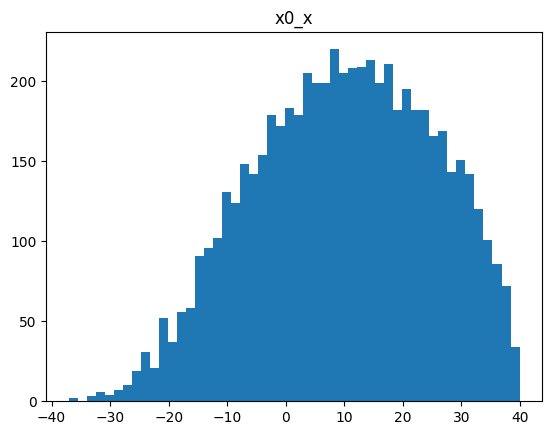

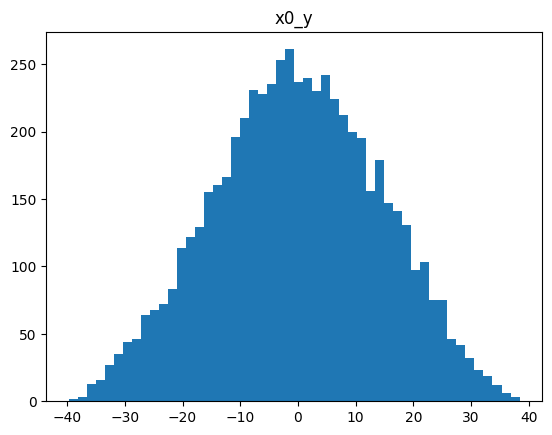

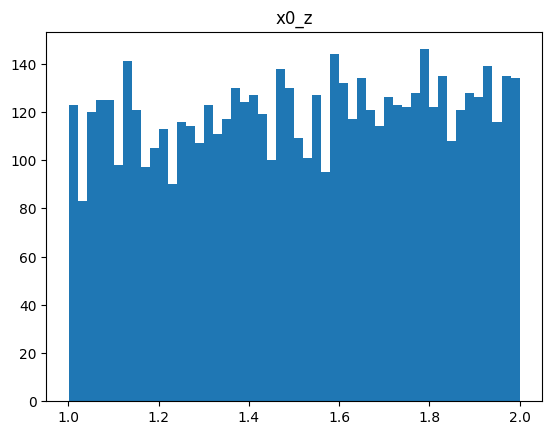

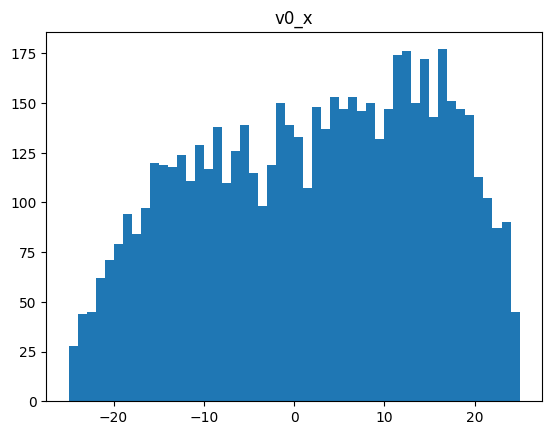

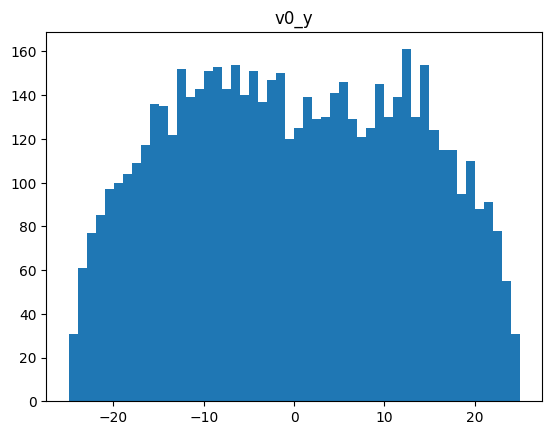

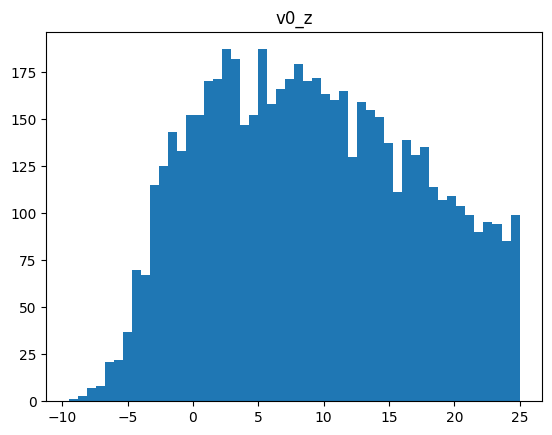

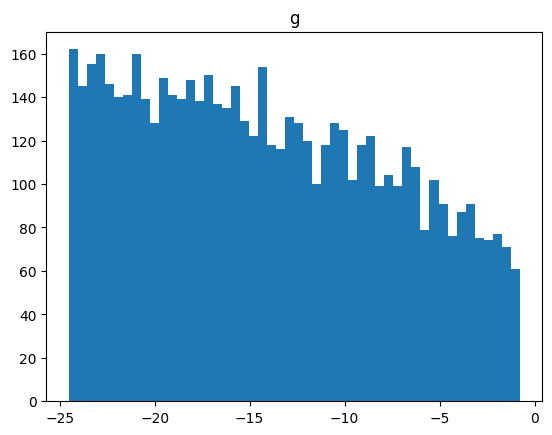

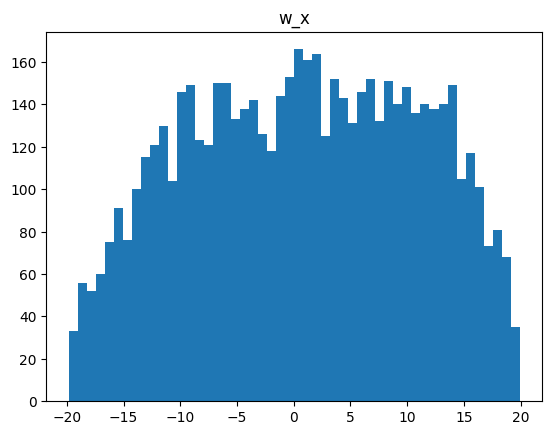

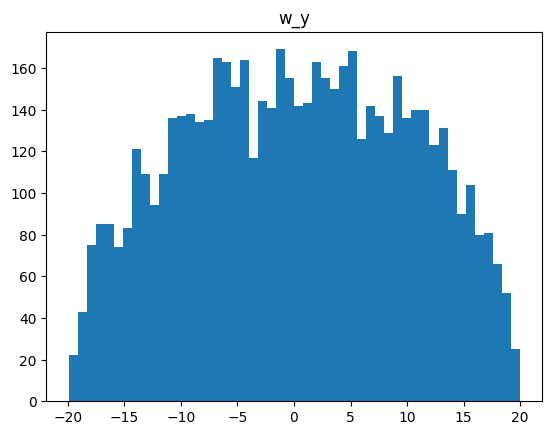

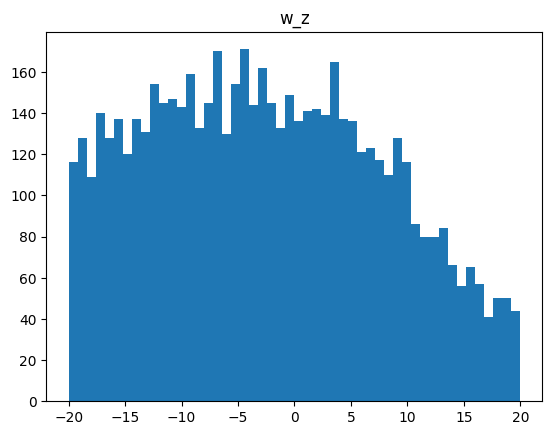

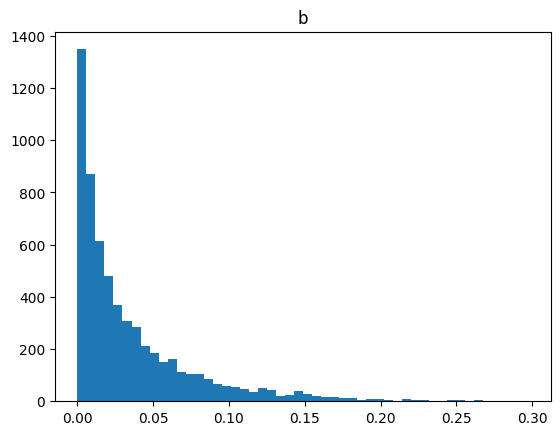

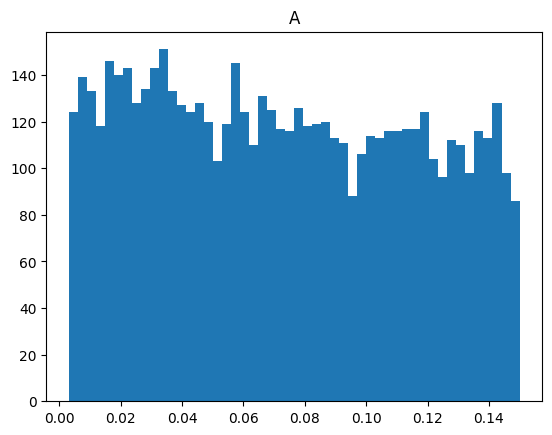

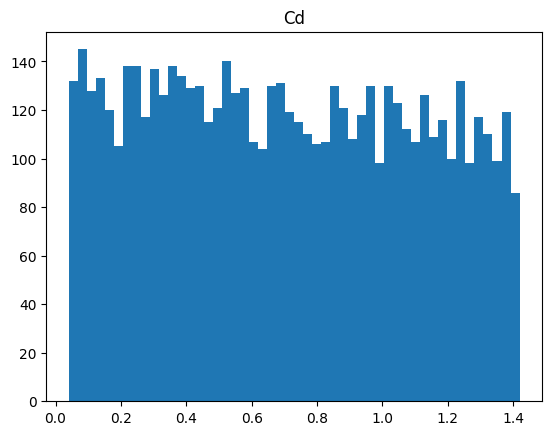

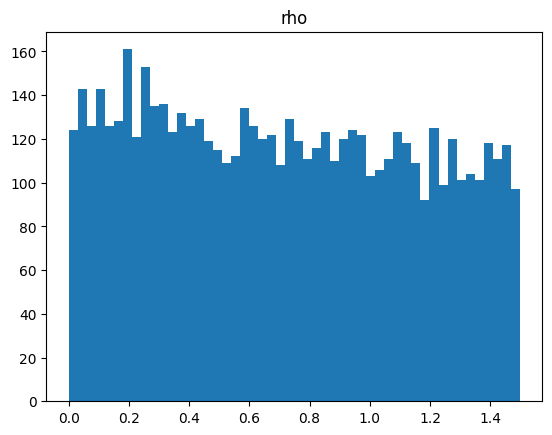

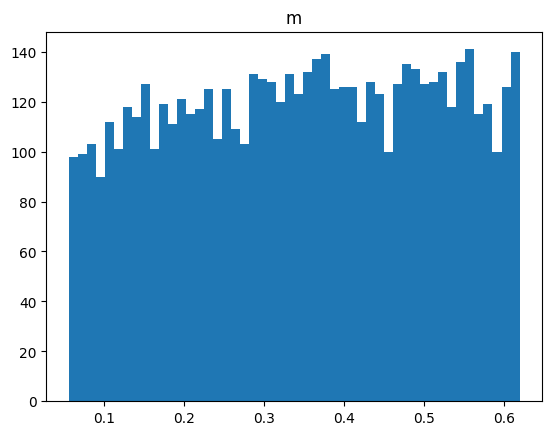

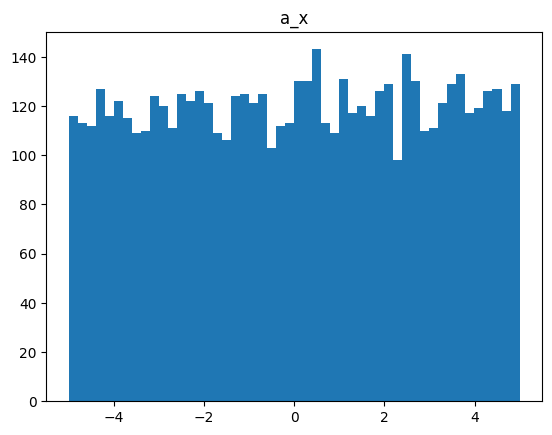

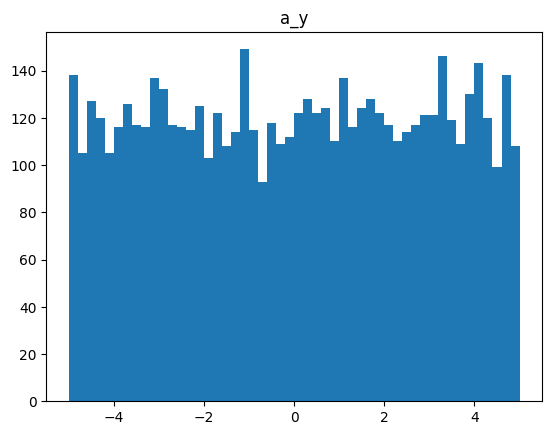

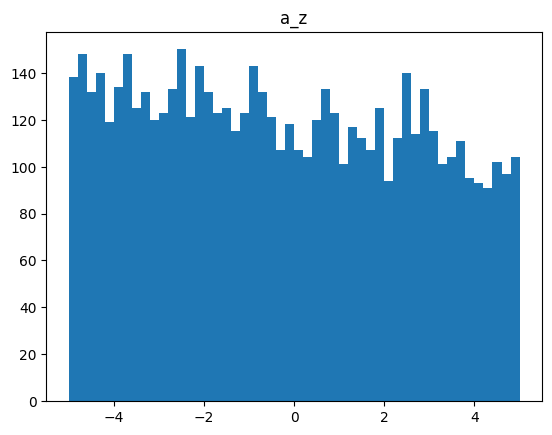

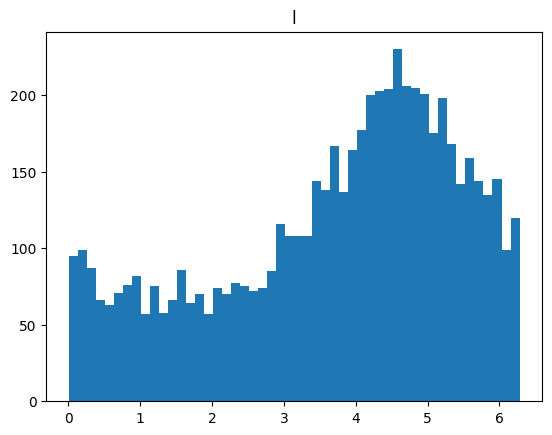

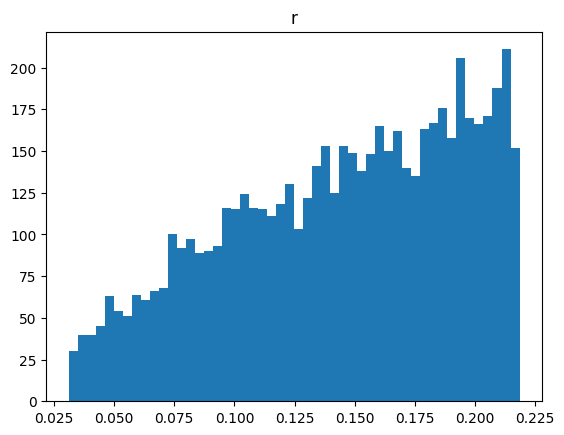

In [5]:
# plot each variable
for col in df.columns:
    plt.hist(df[col], bins=50)
    plt.title(col)
    plt.show()

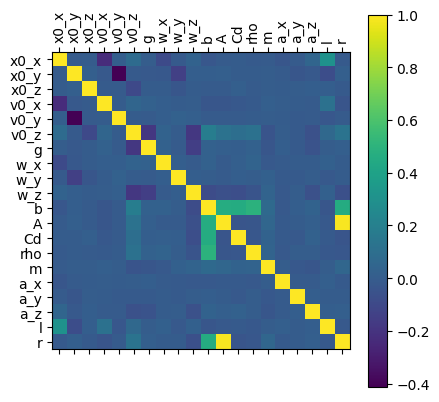

In [6]:
# plot correlation matrix
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

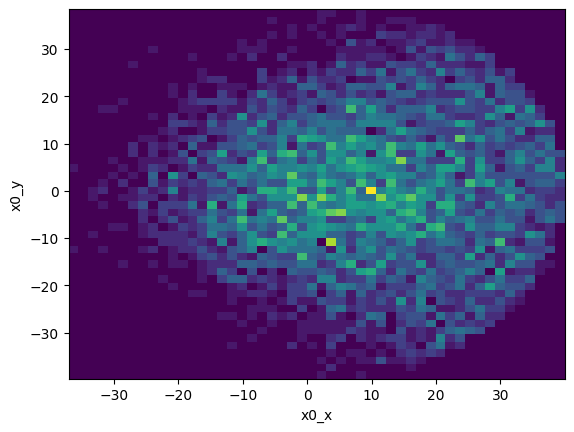

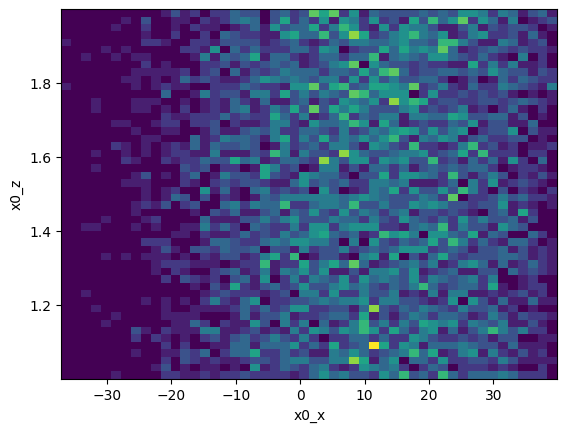

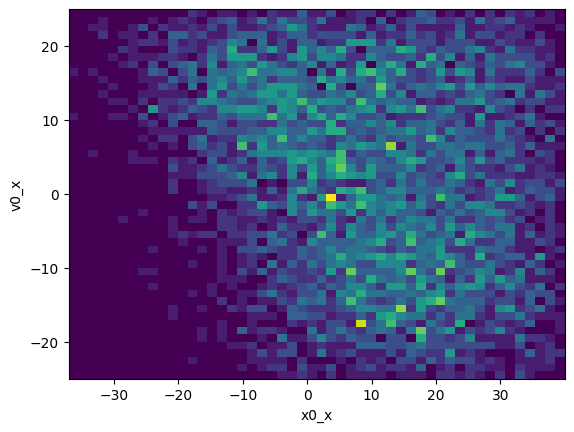

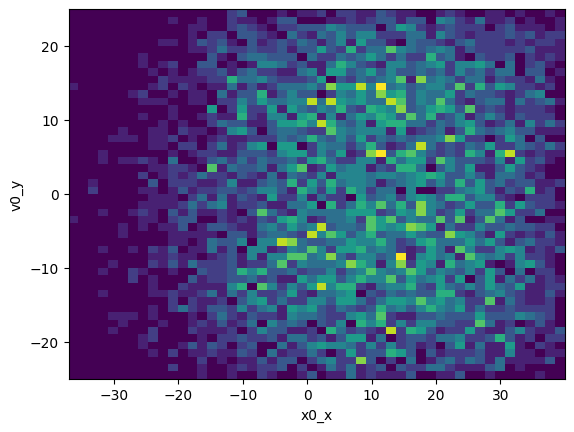

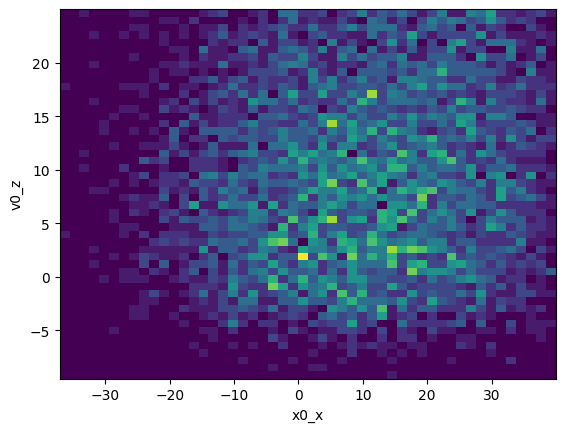

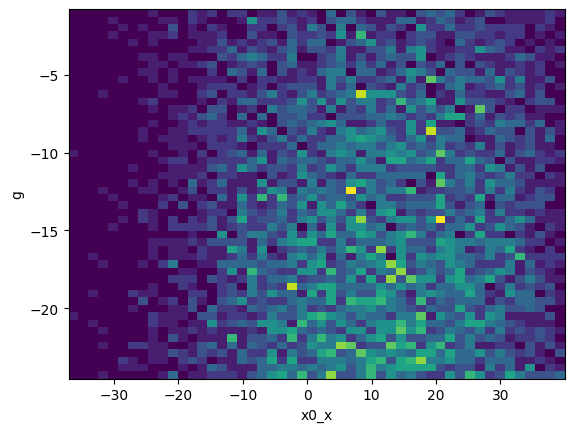

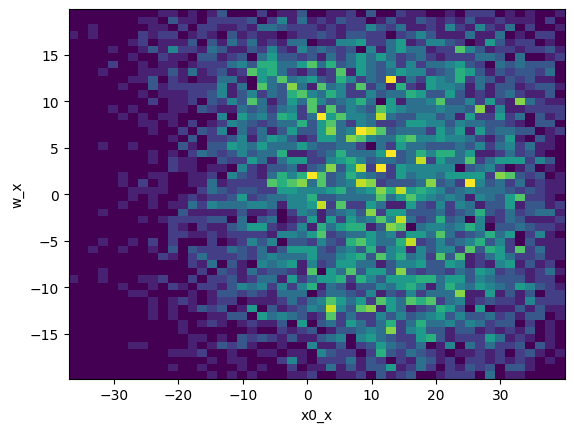

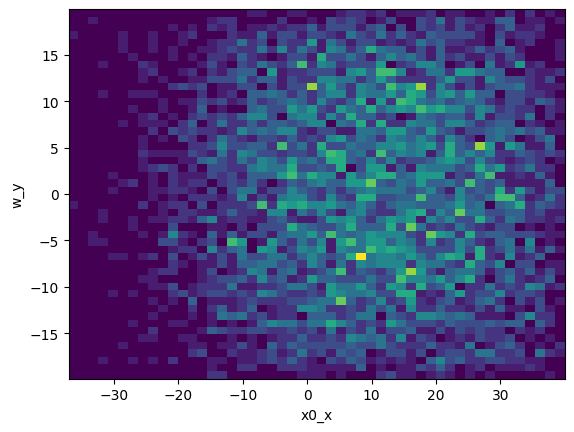

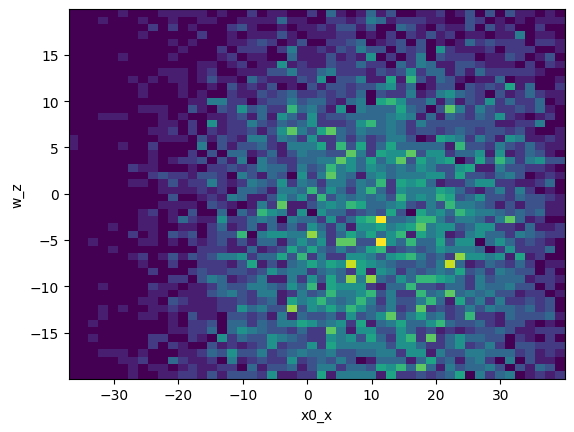

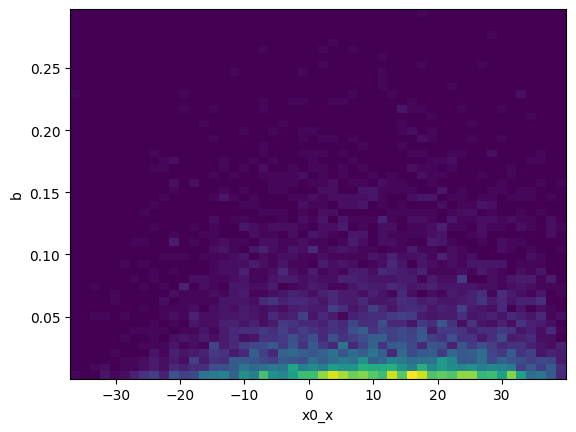

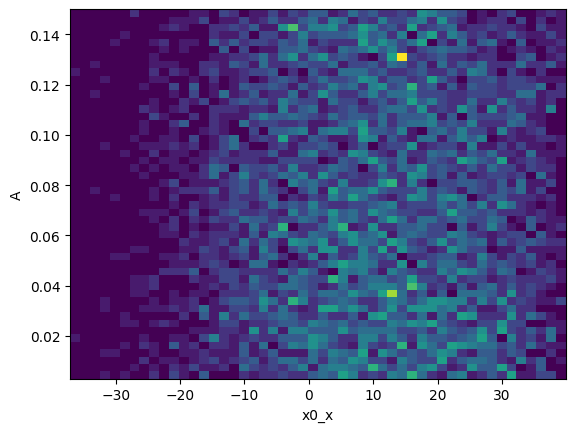

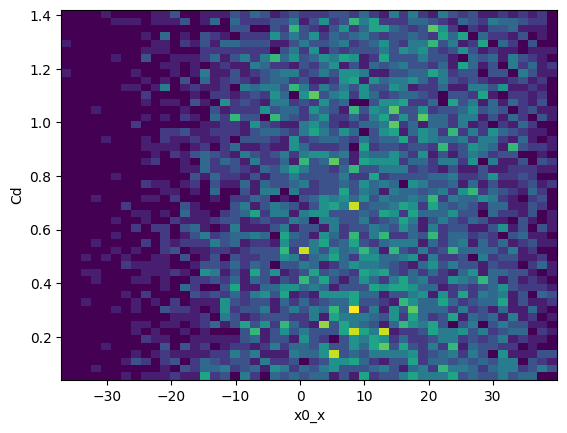

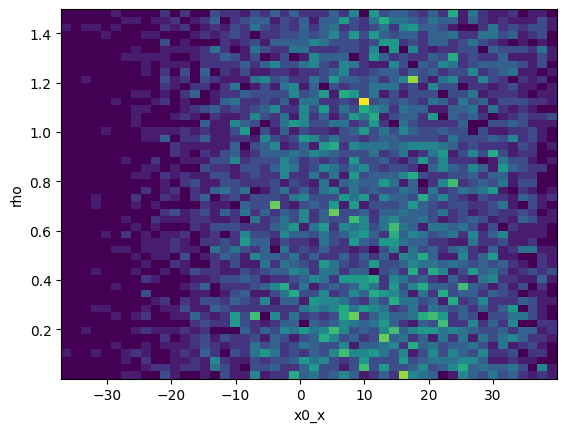

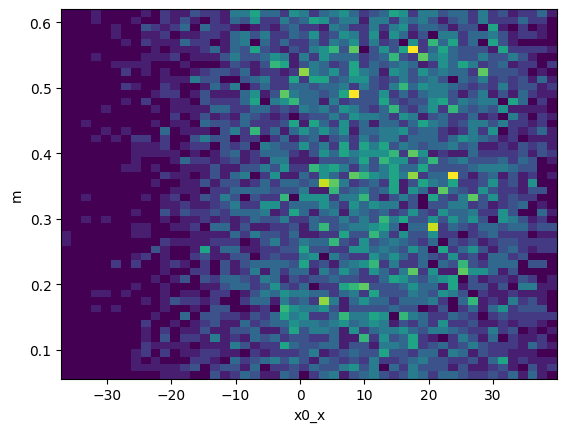

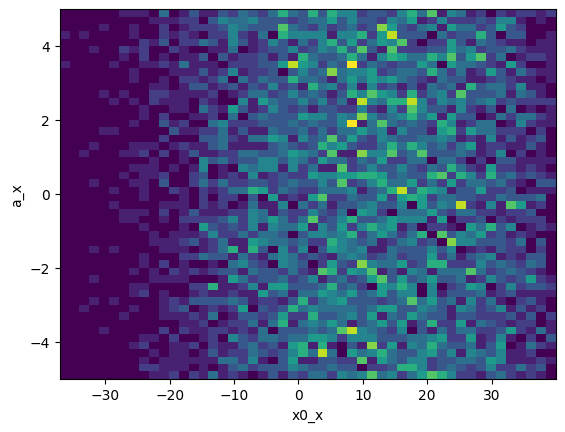

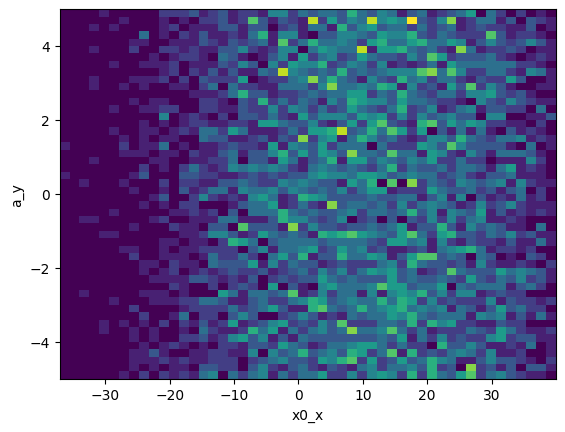

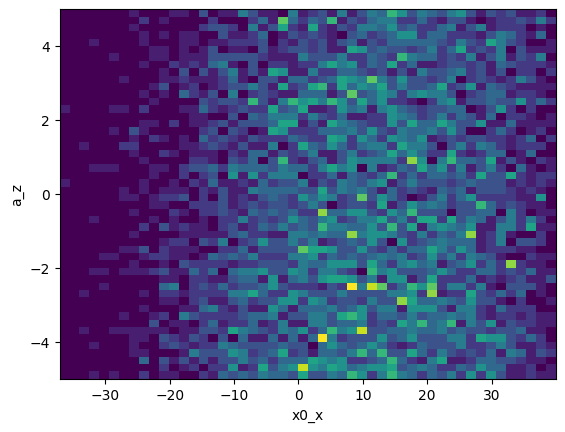

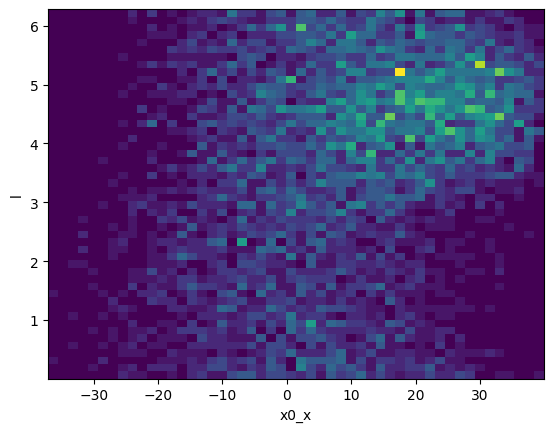

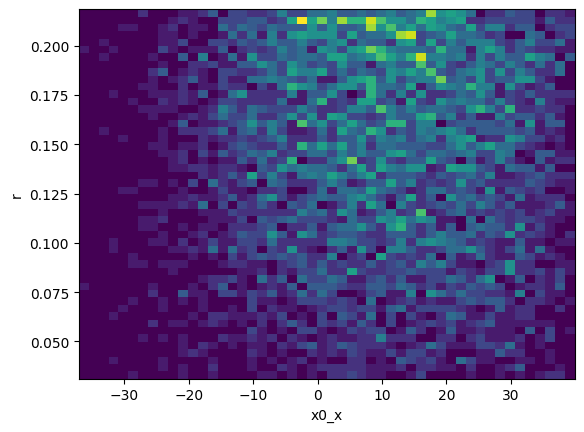

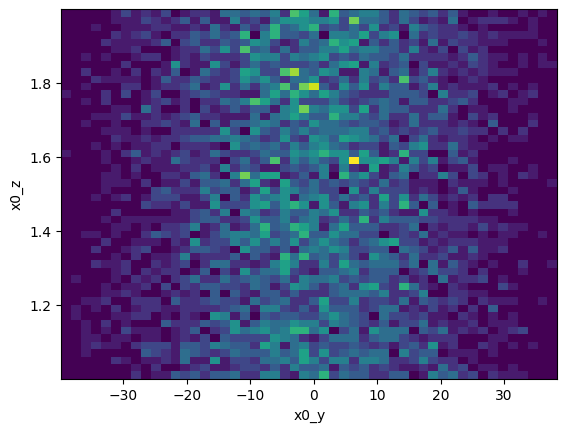

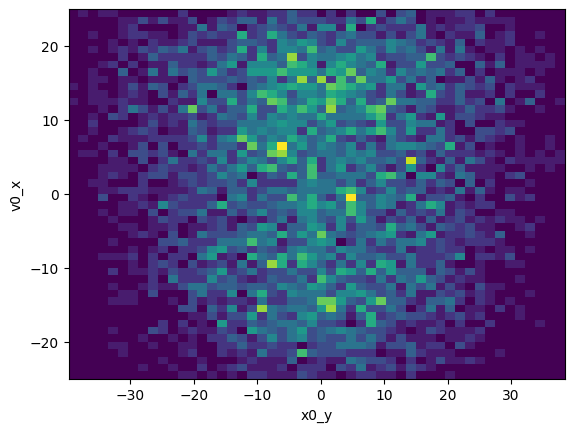

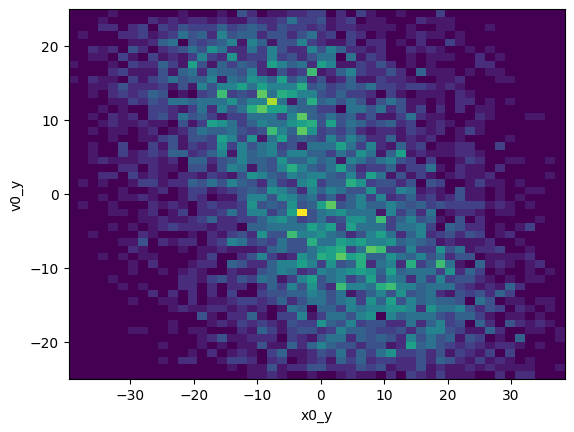

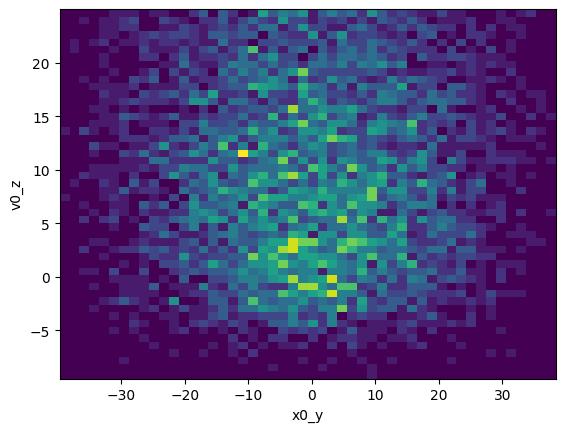

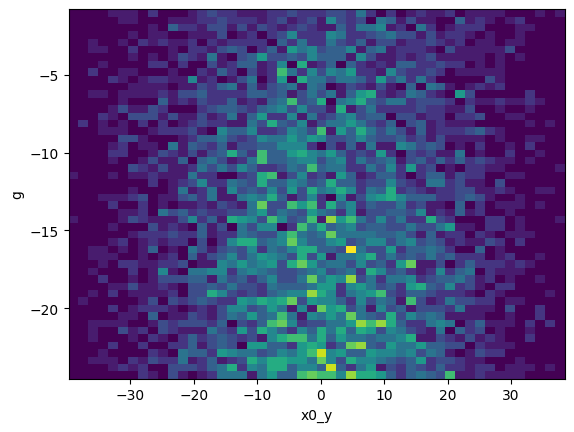

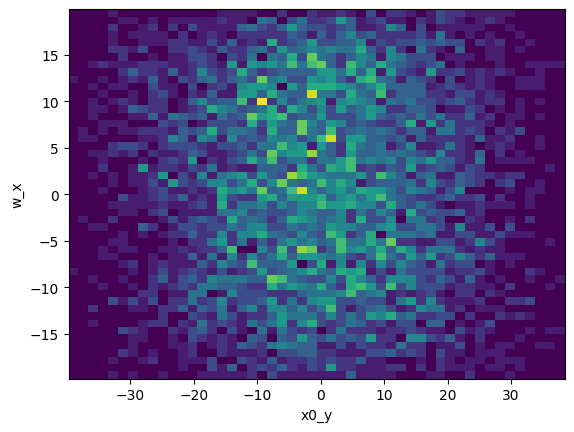

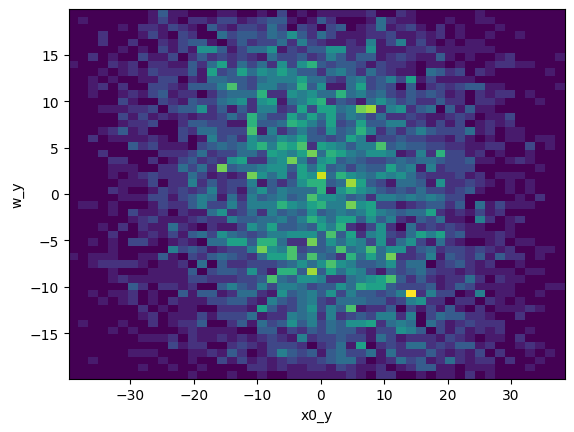

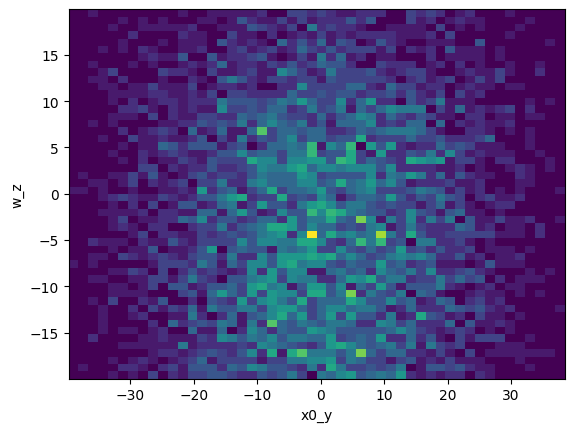

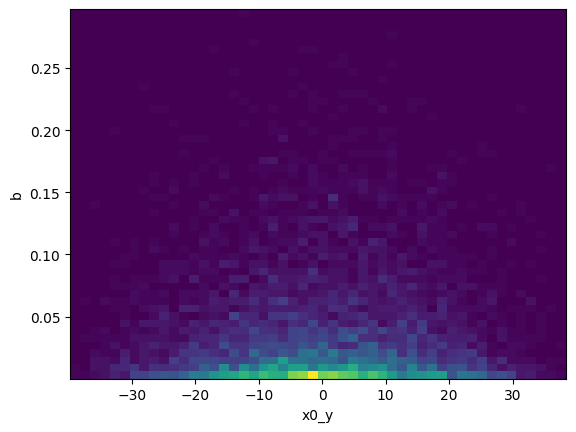

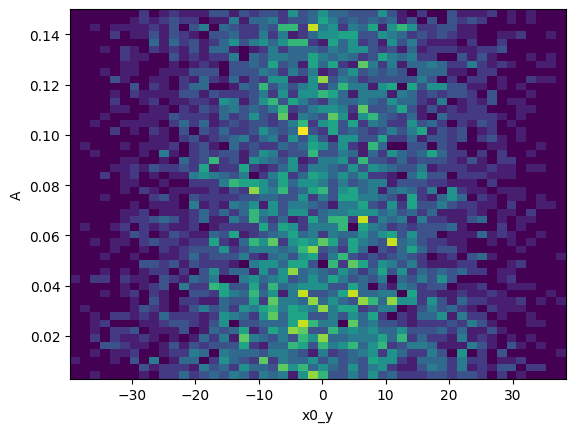

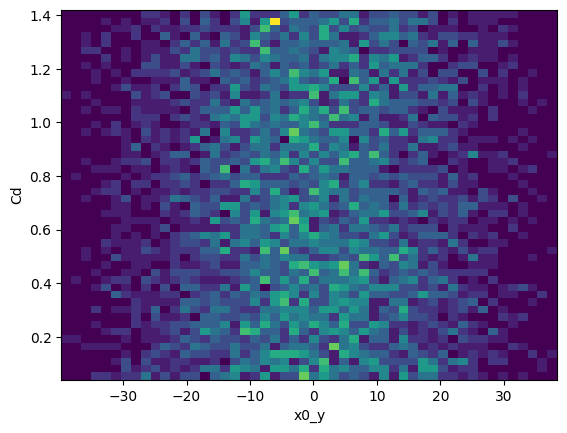

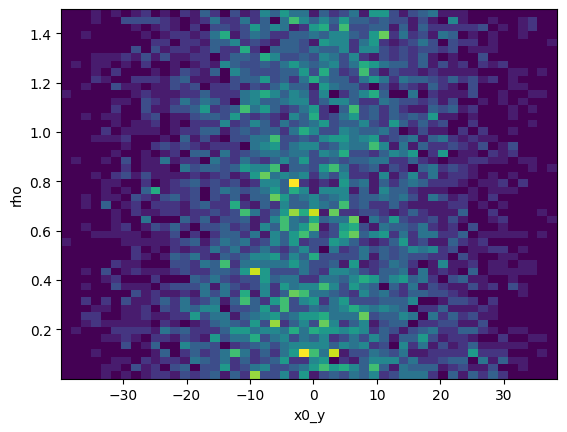

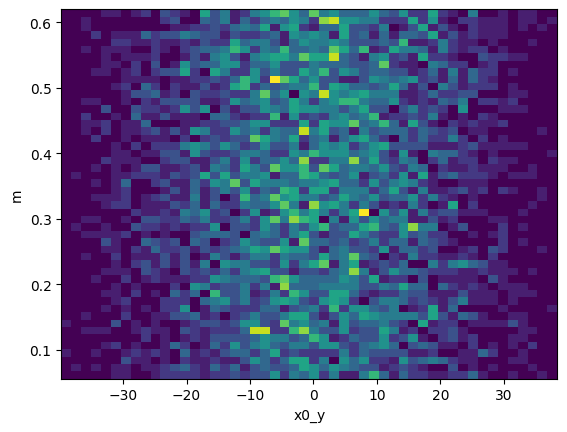

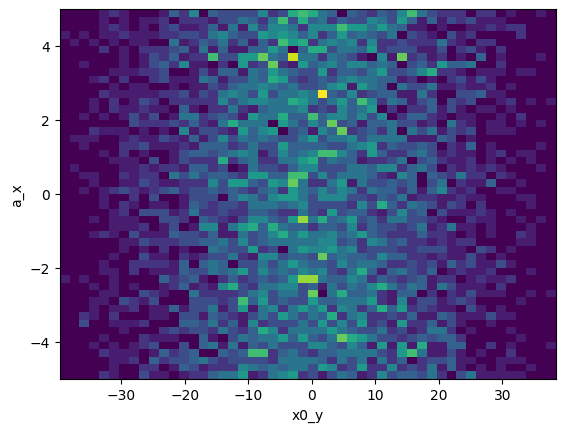

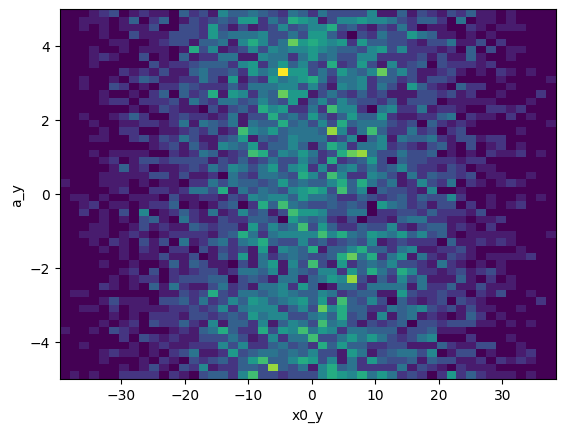

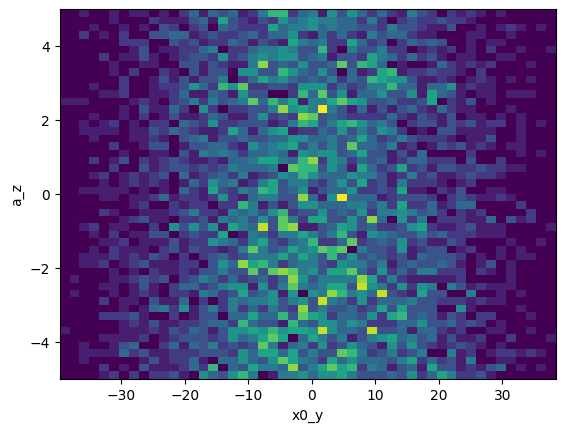

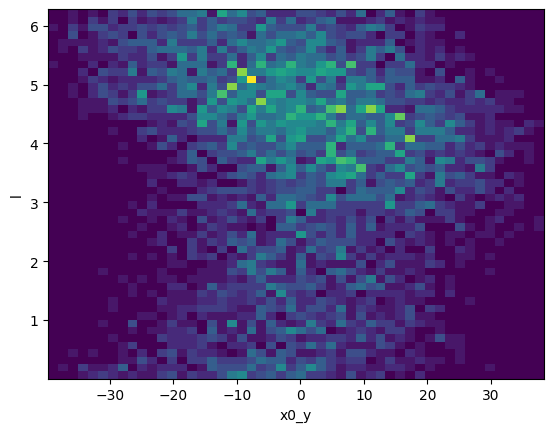

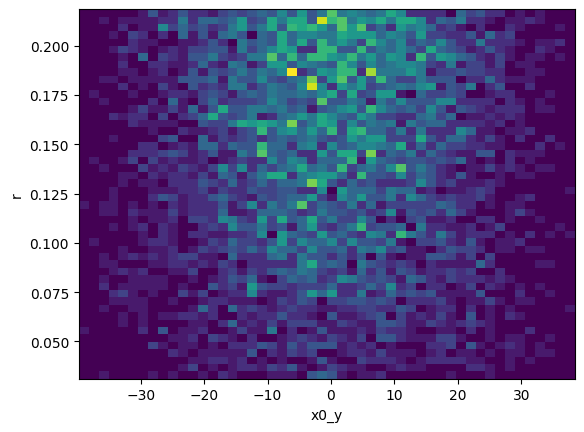

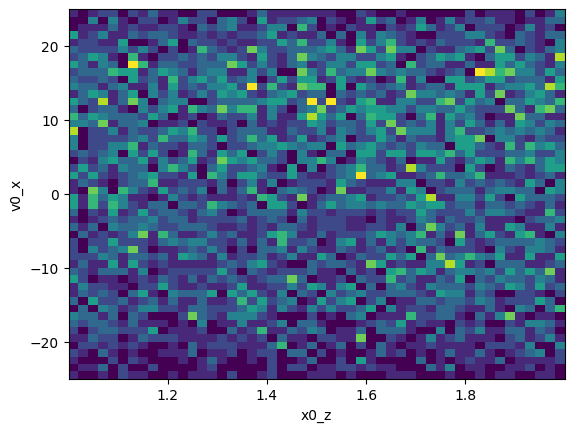

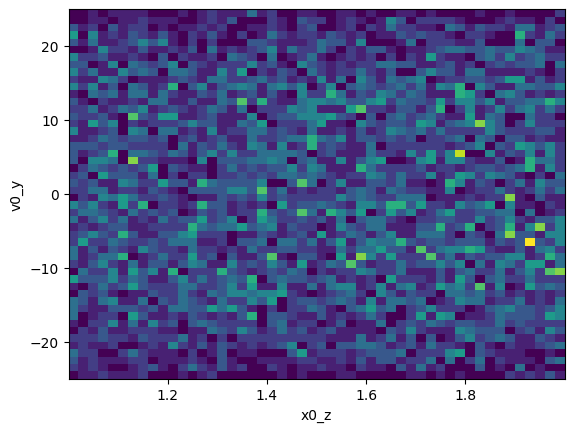

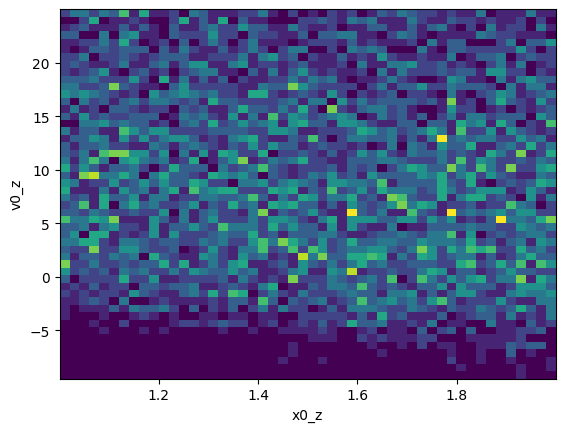

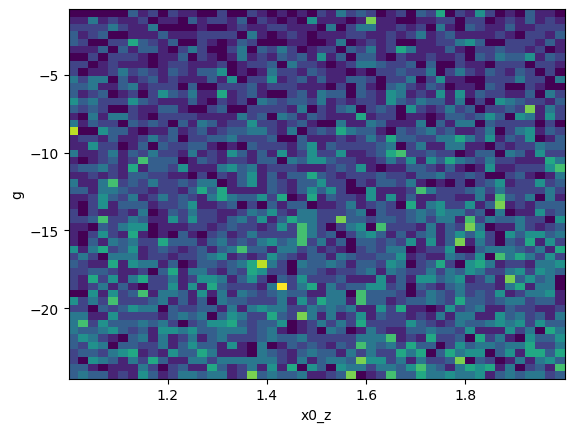

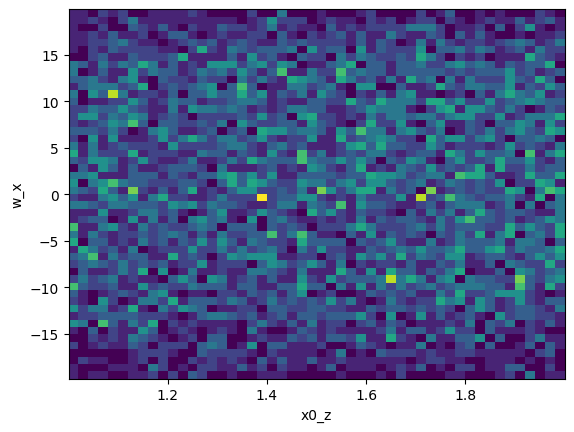

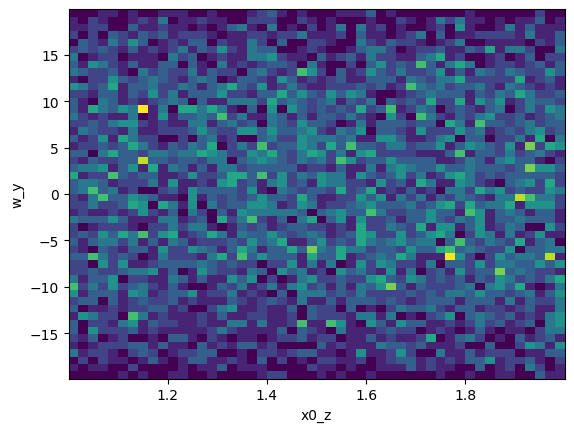

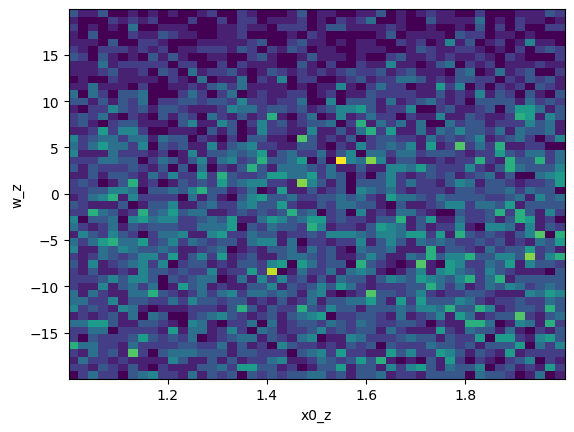

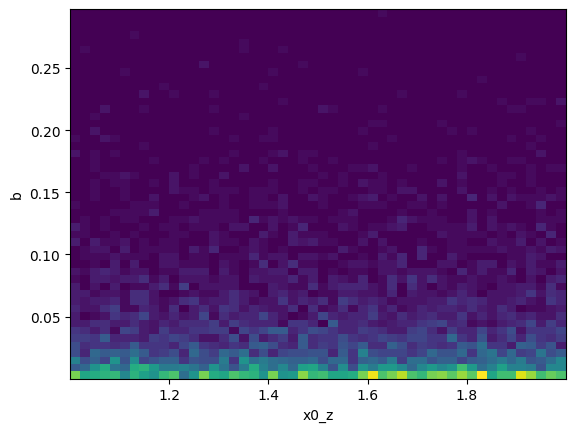

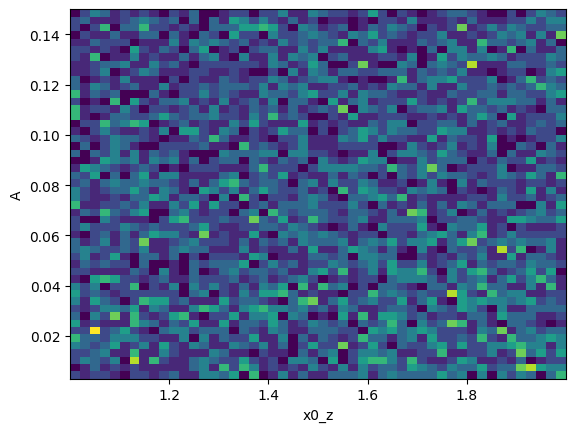

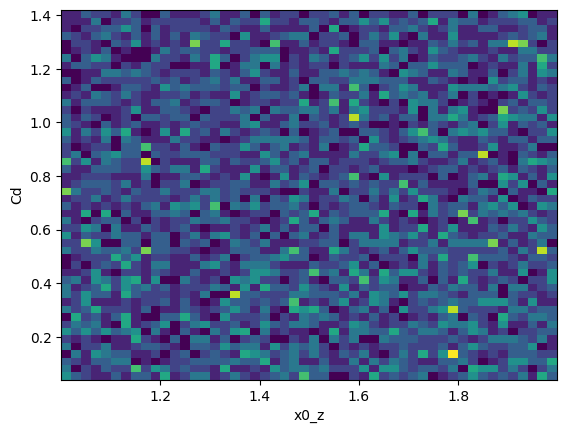

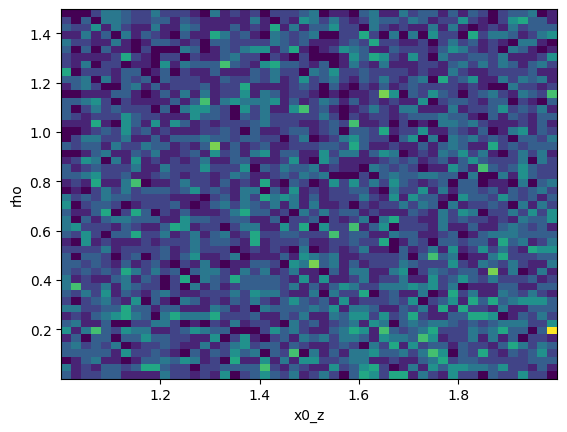

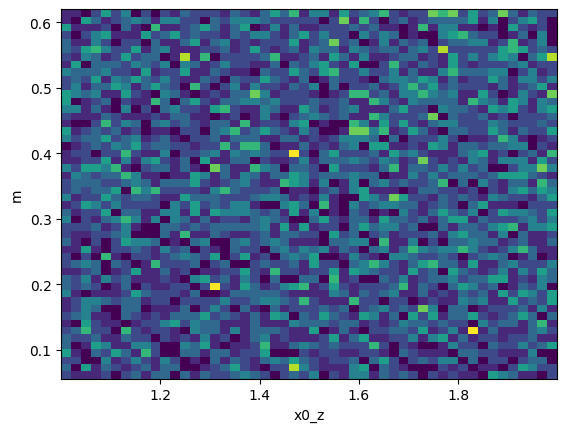

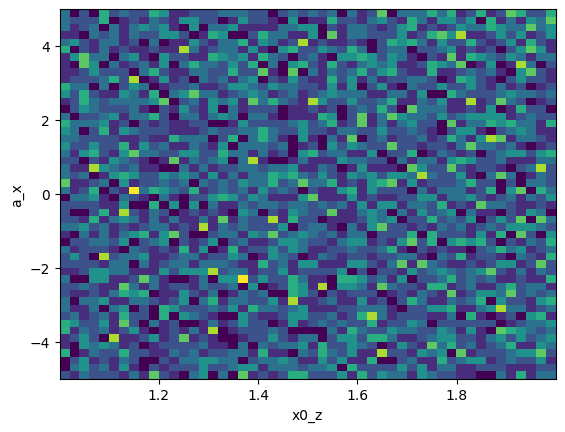

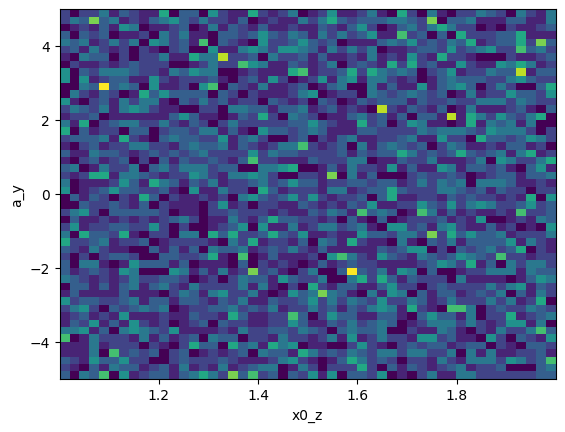

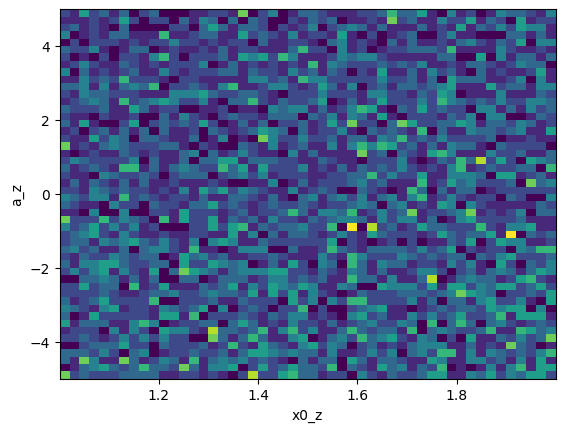

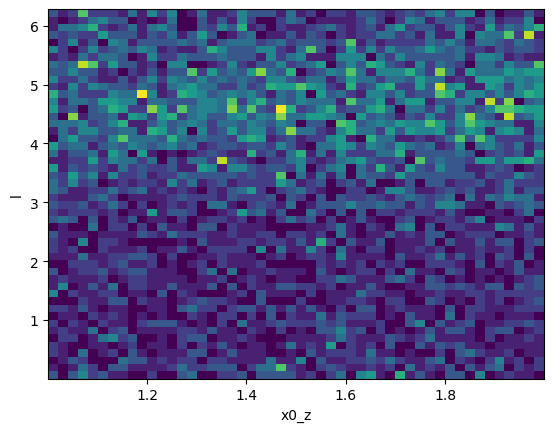

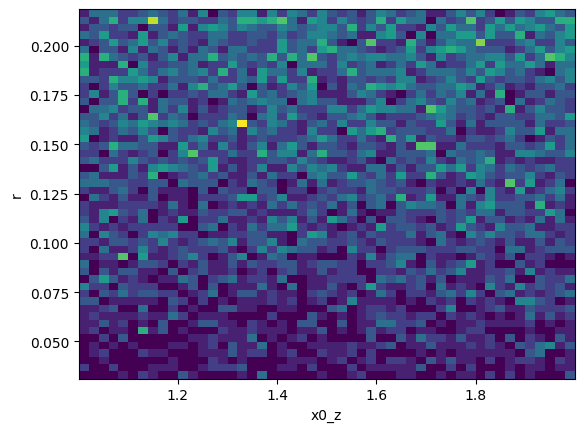

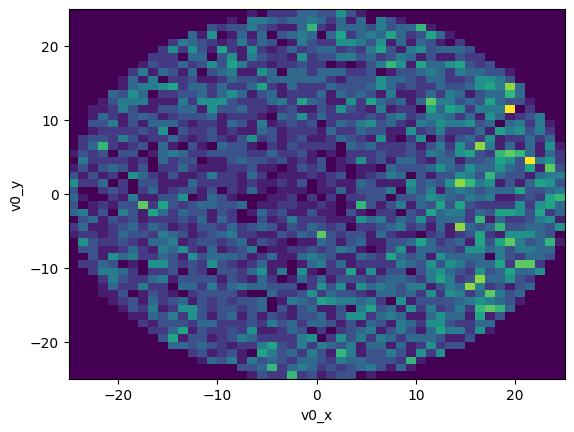

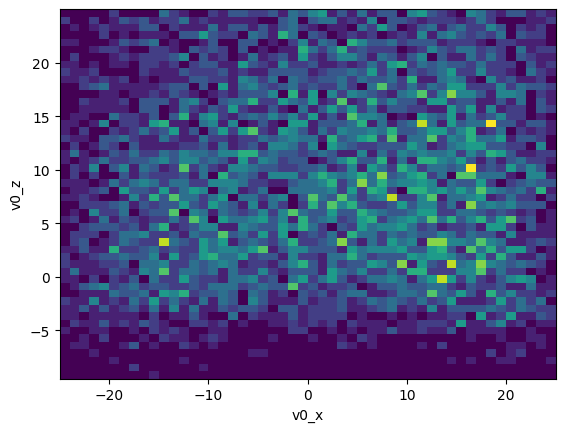

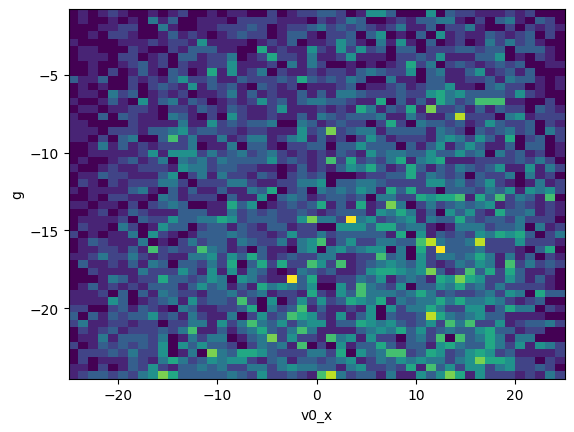

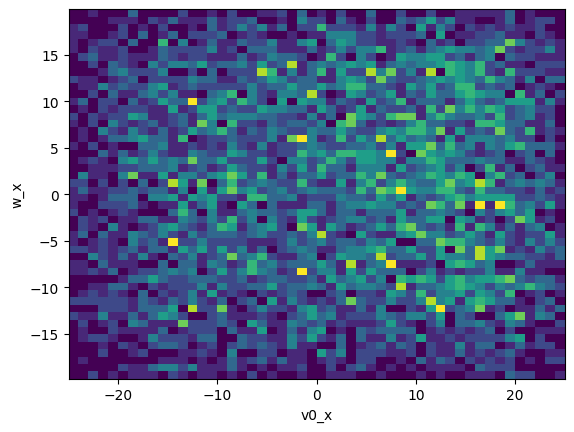

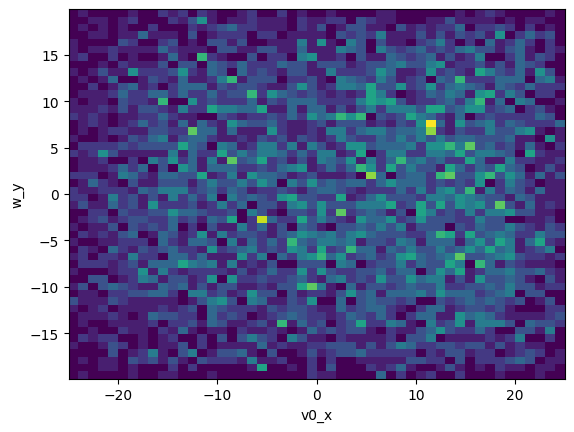

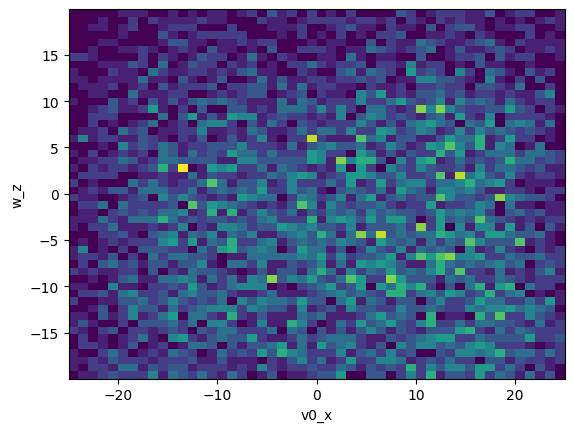

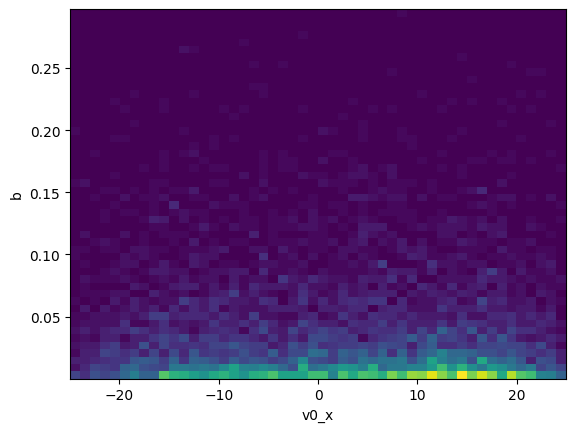

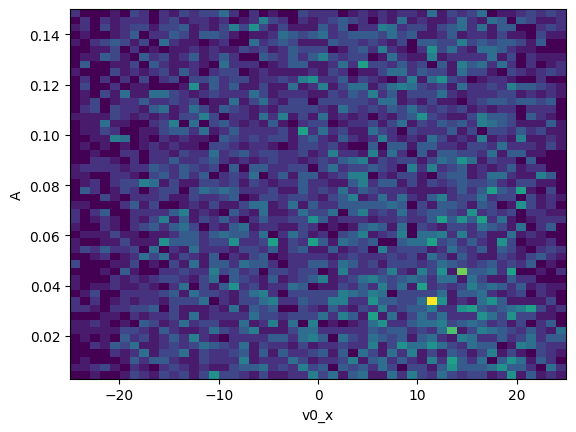

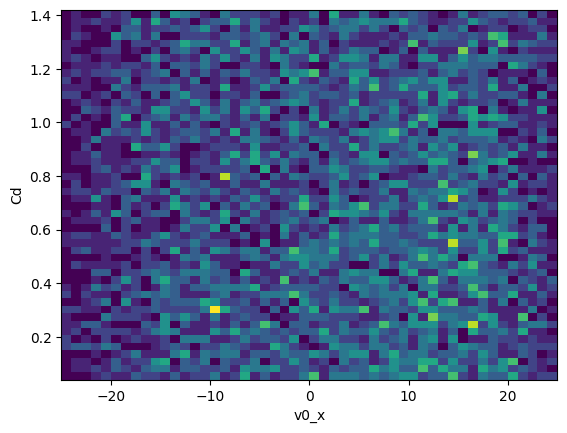

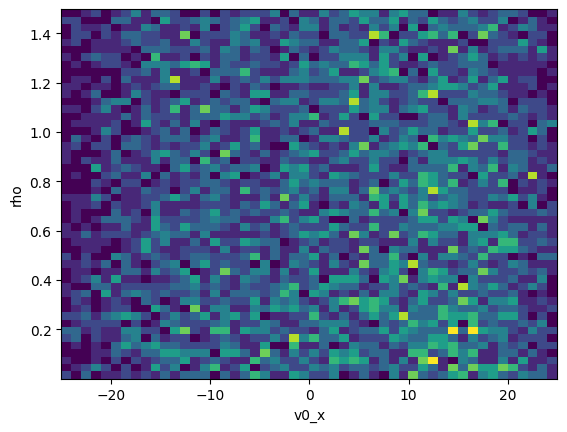

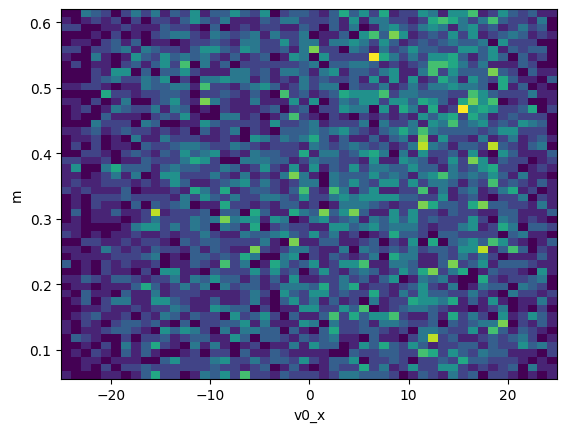

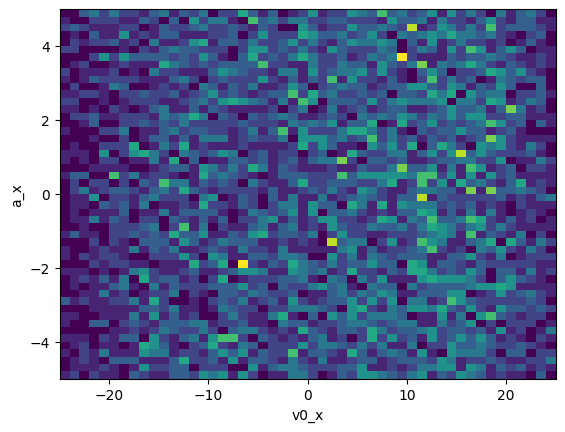

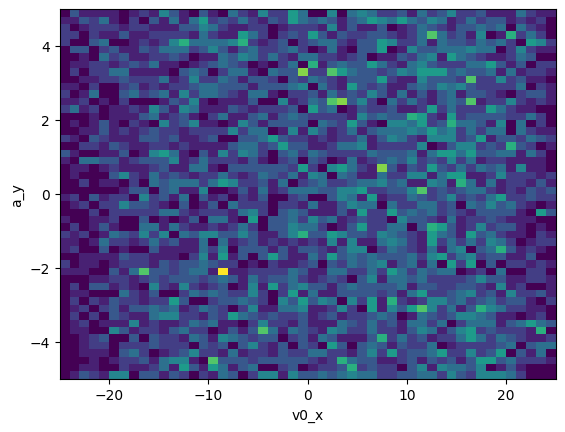

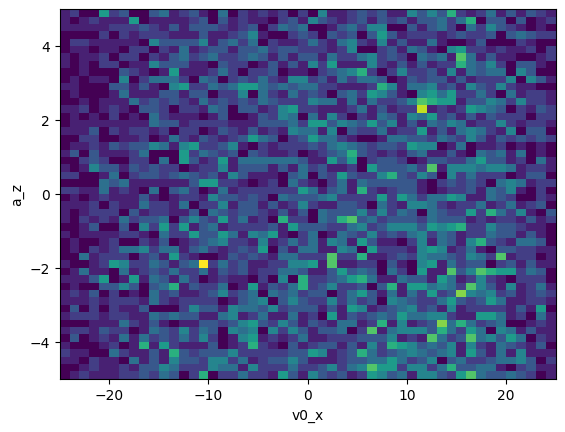

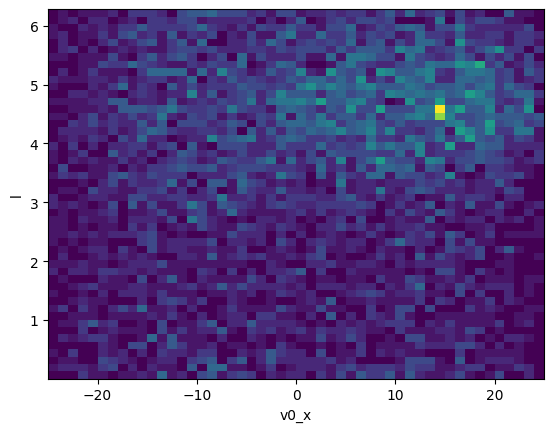

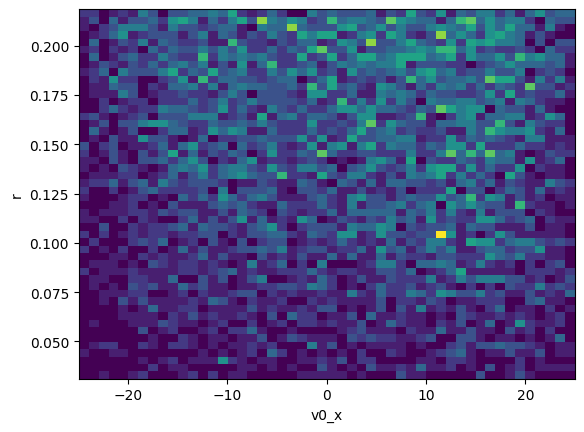

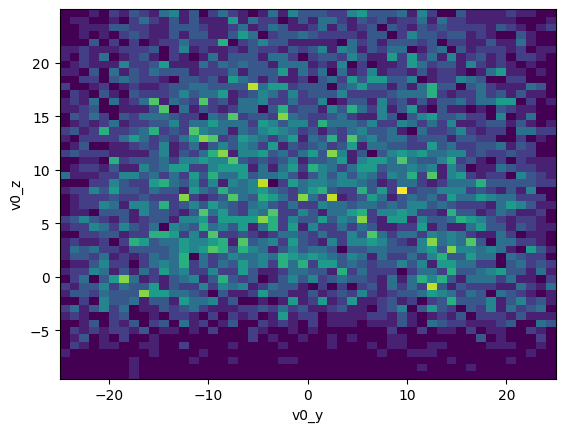

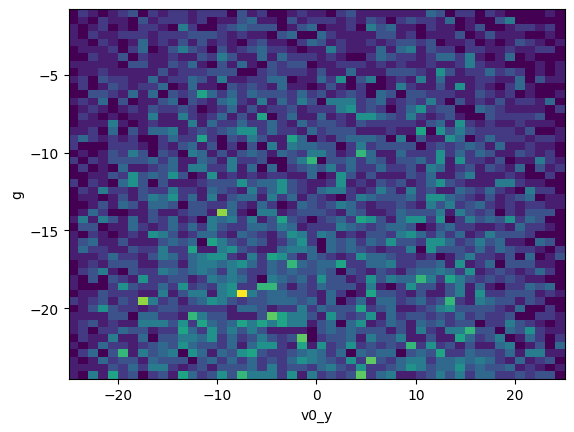

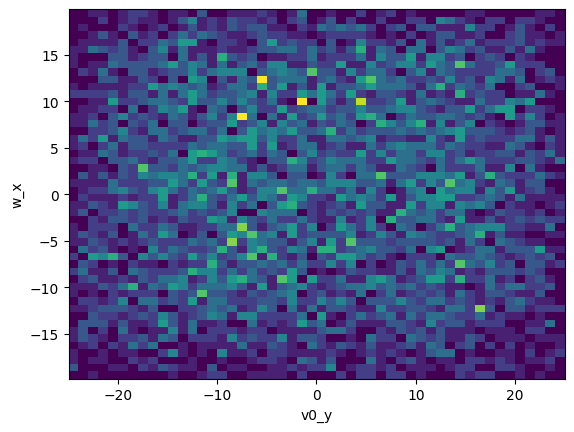

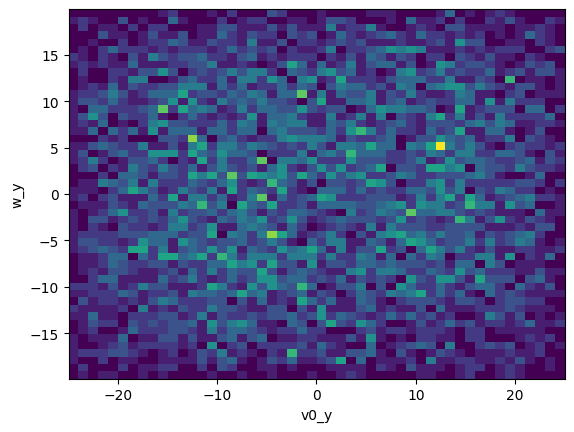

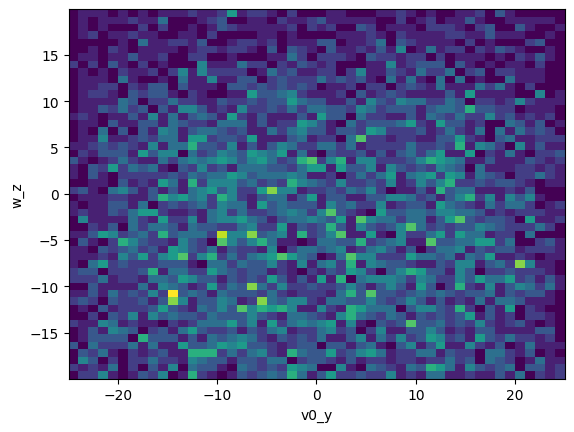

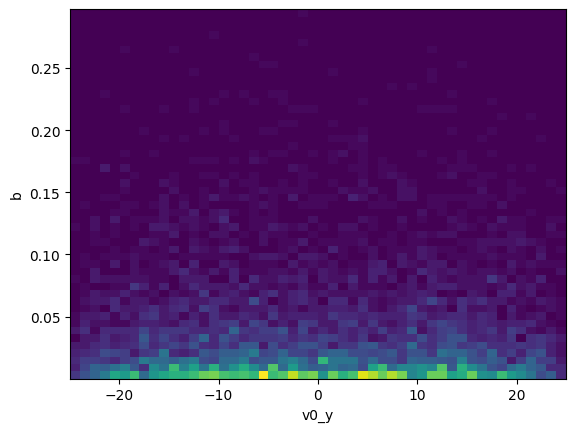

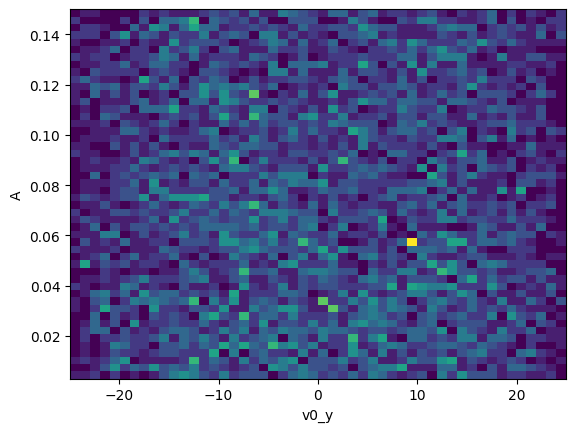

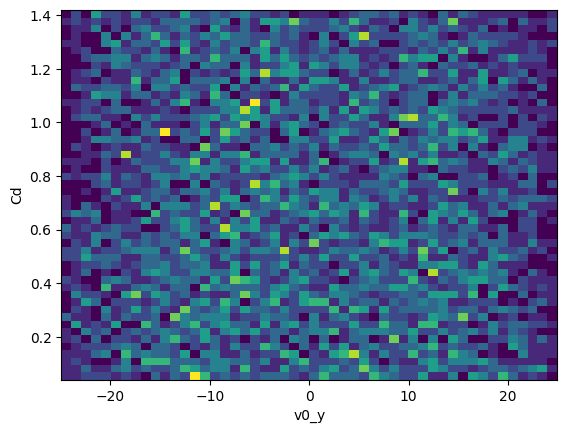

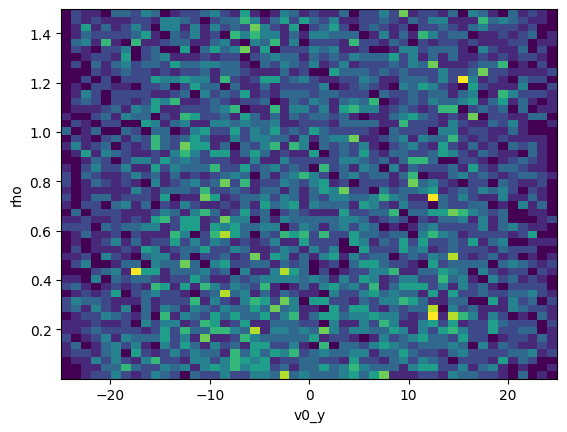

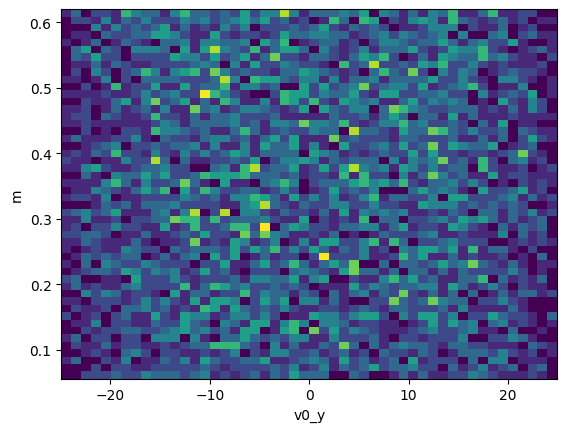

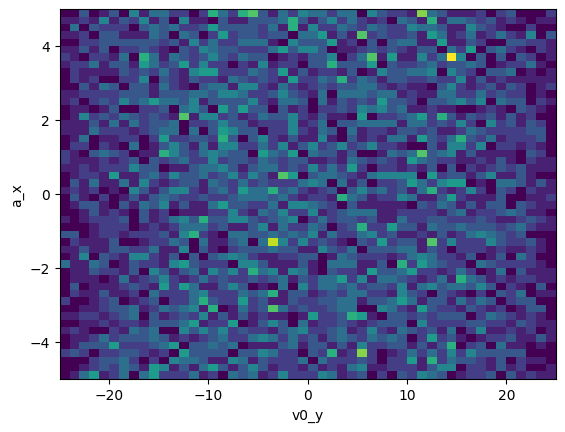

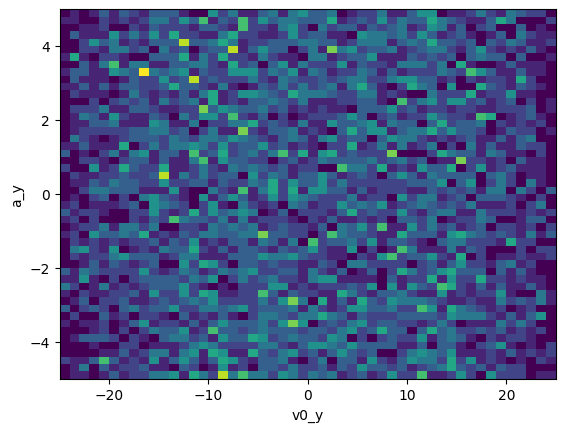

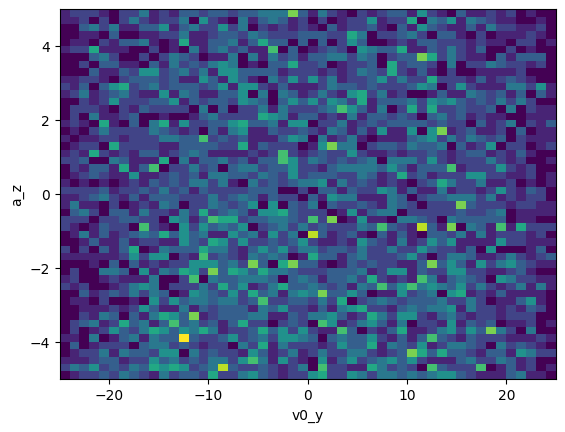

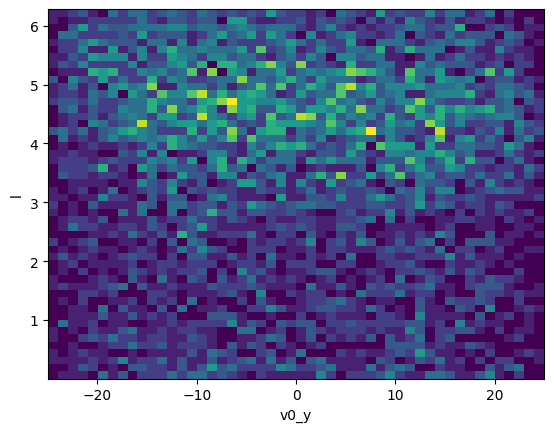

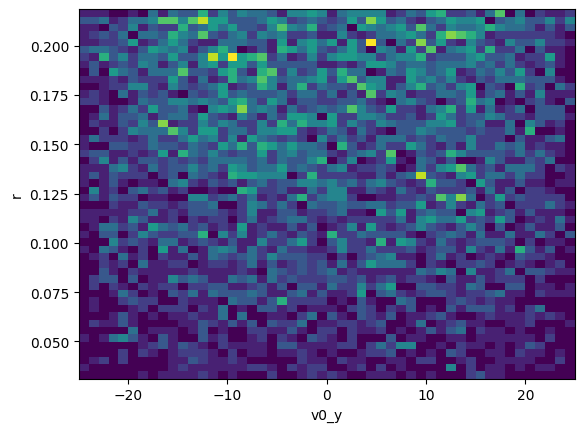

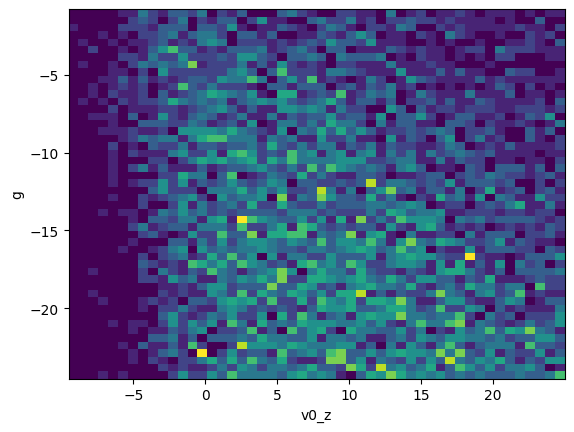

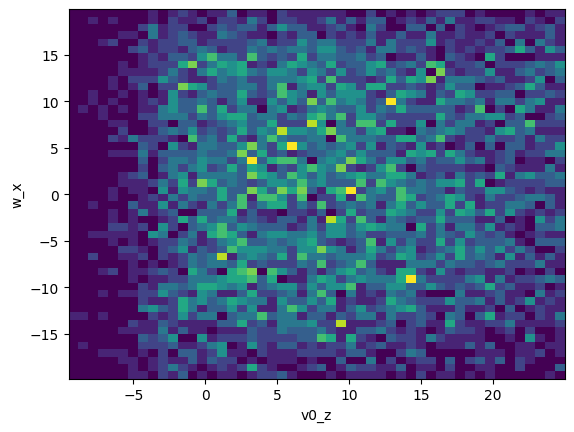

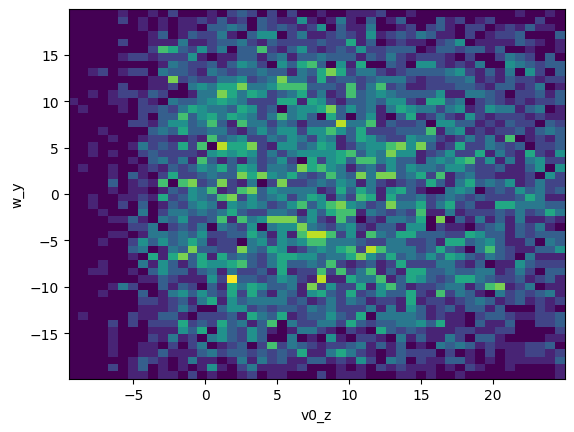

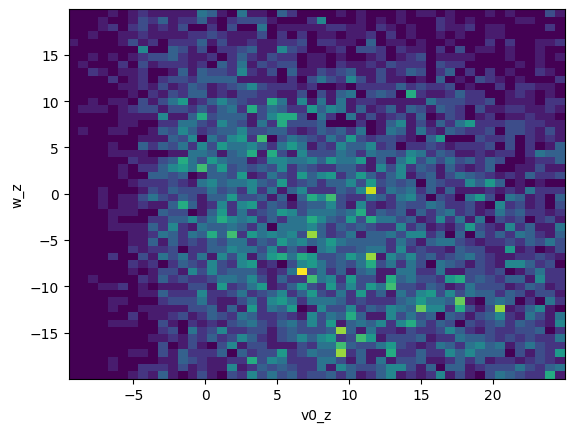

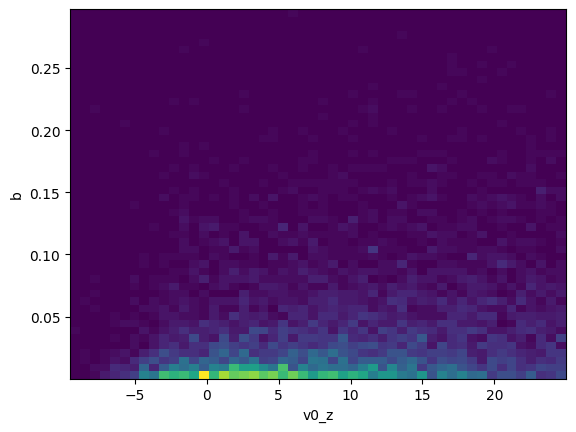

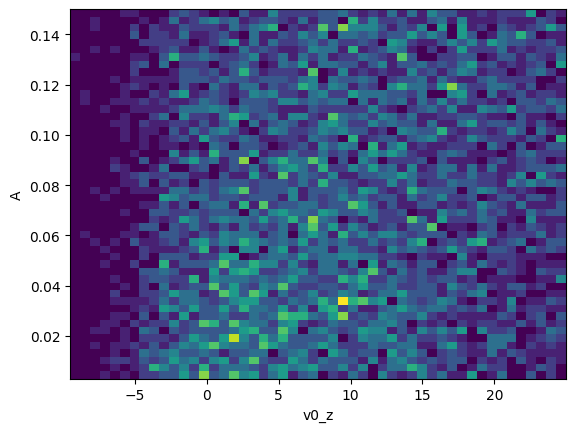

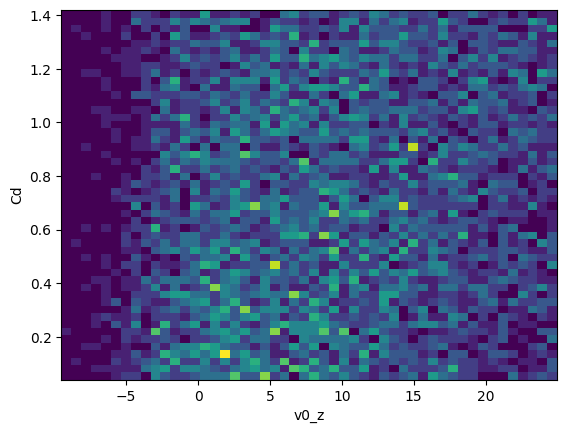

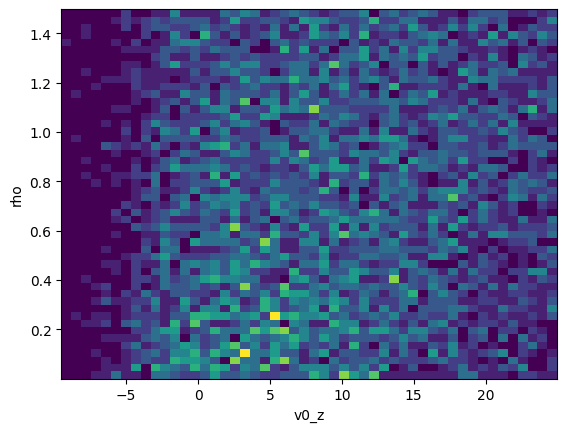

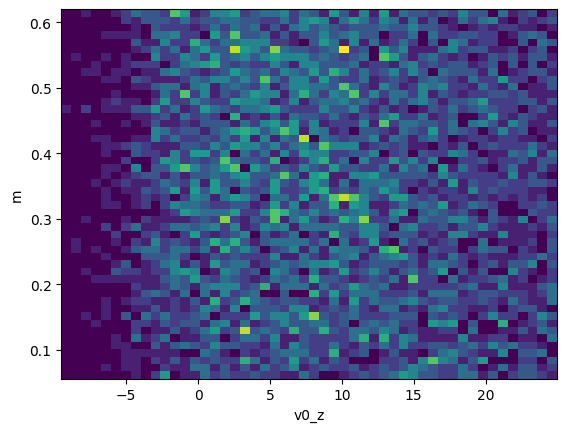

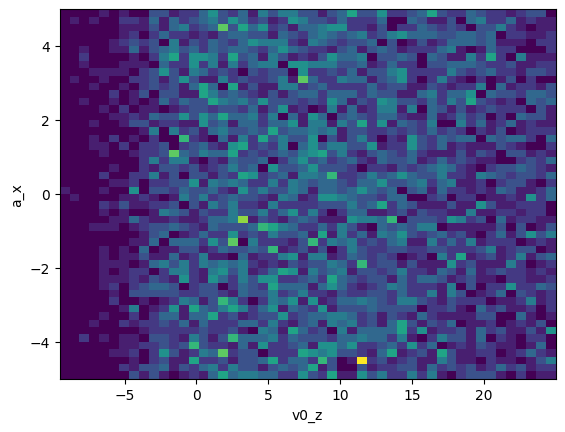

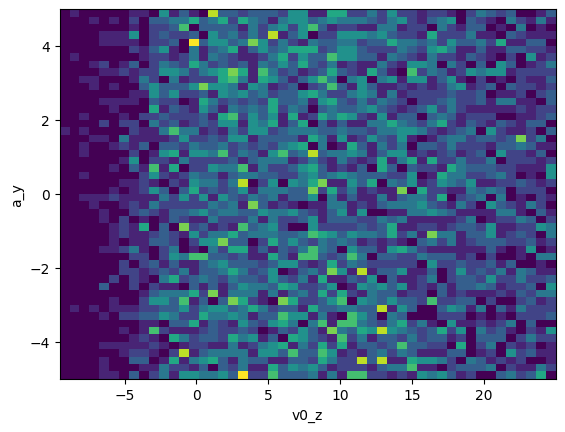

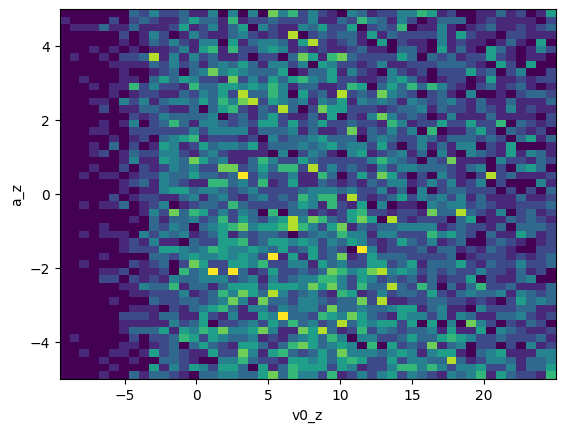

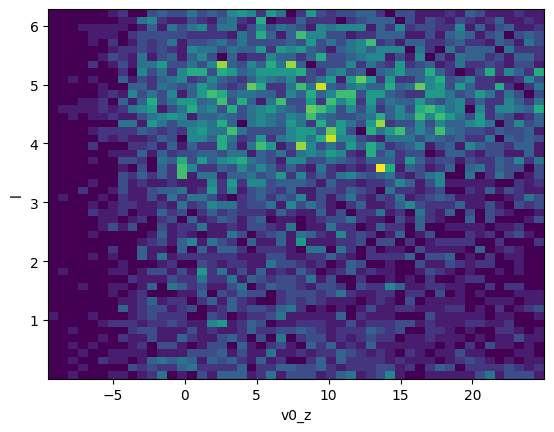

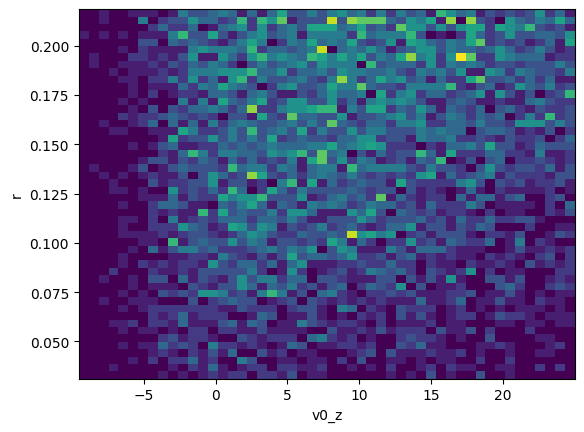

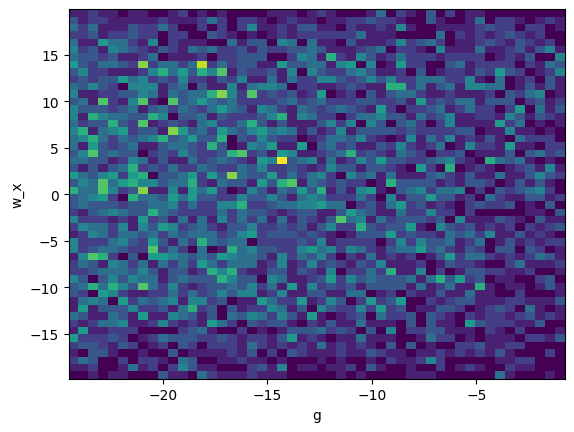

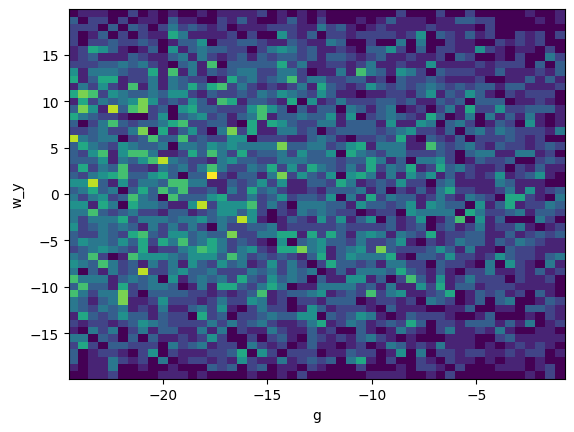

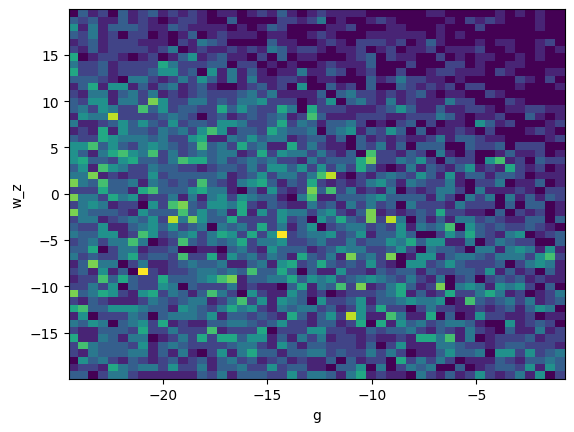

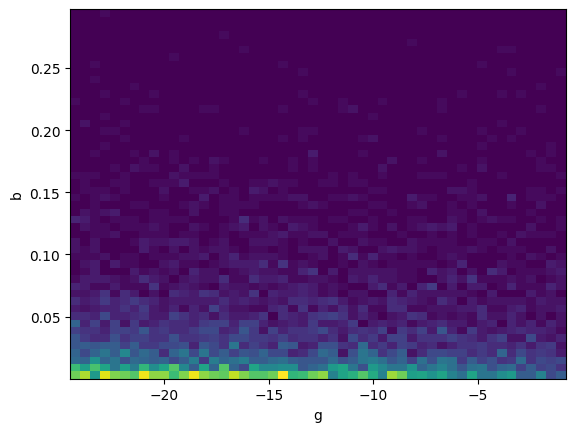

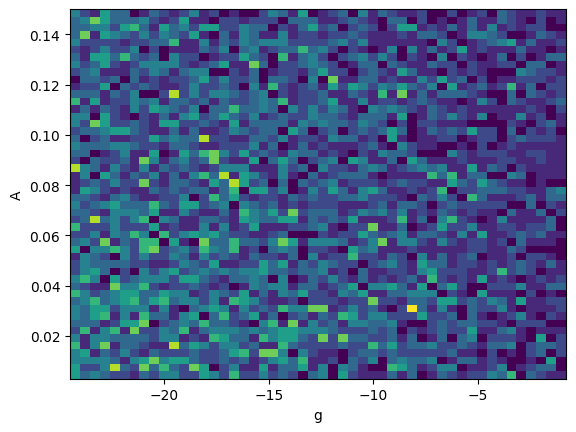

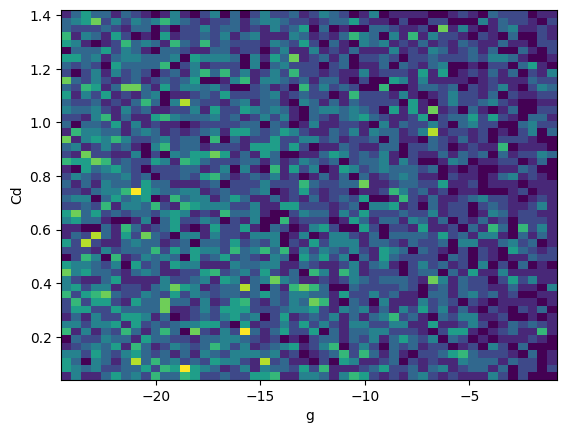

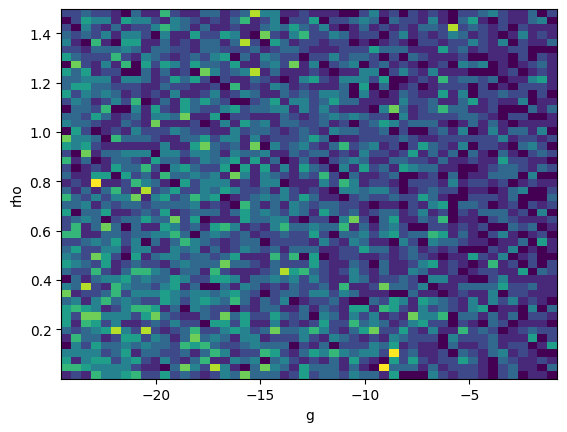

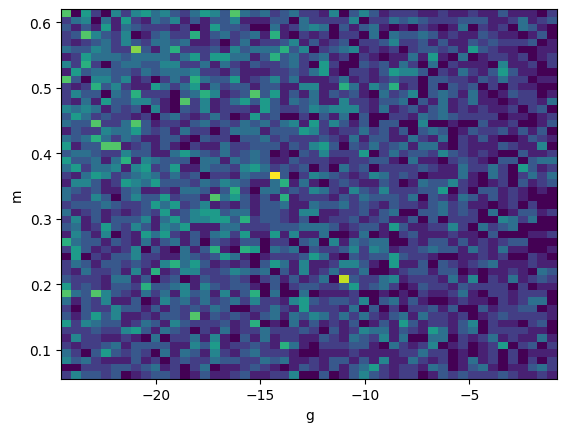

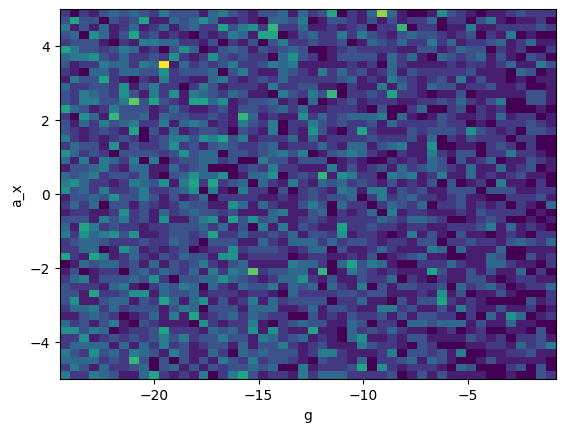

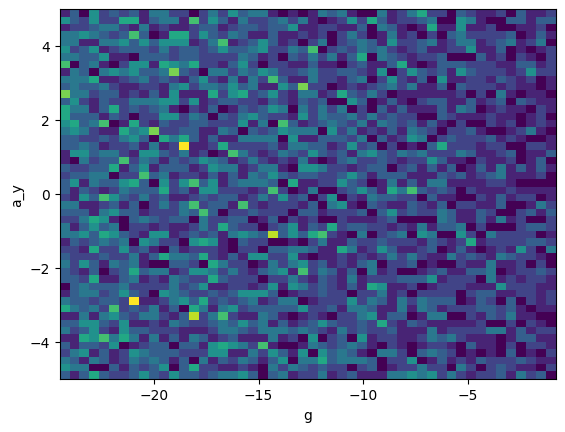

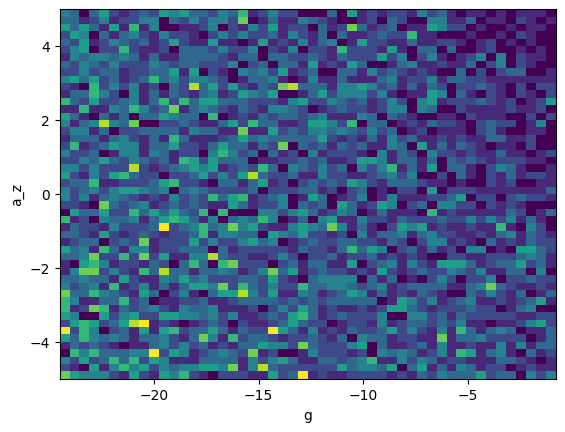

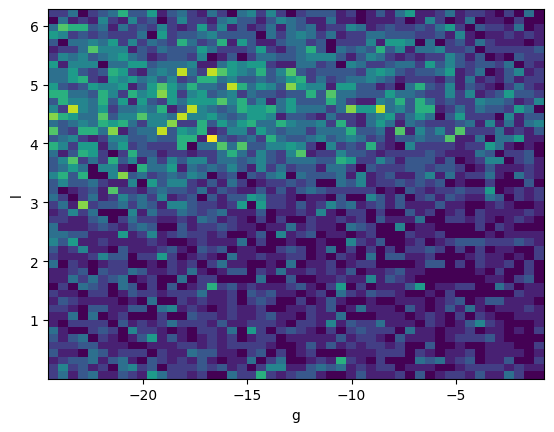

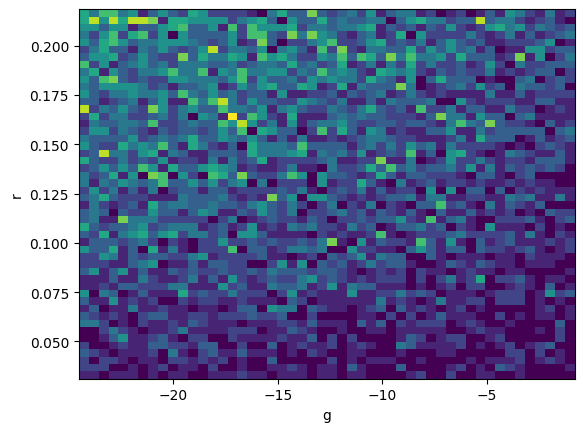

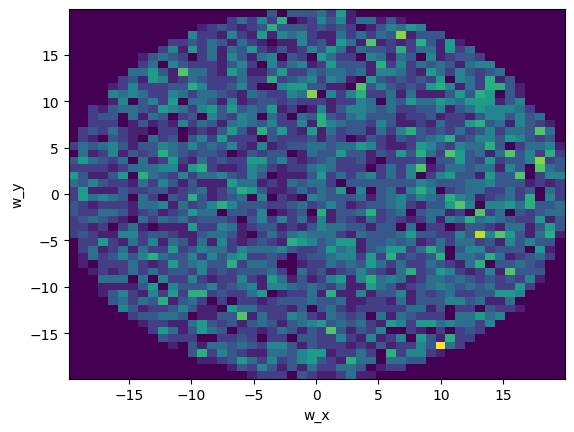

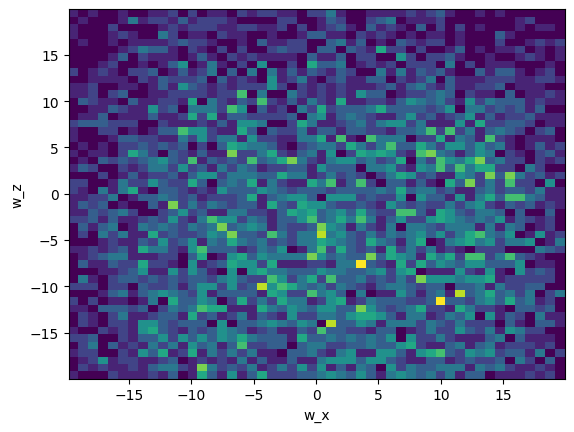

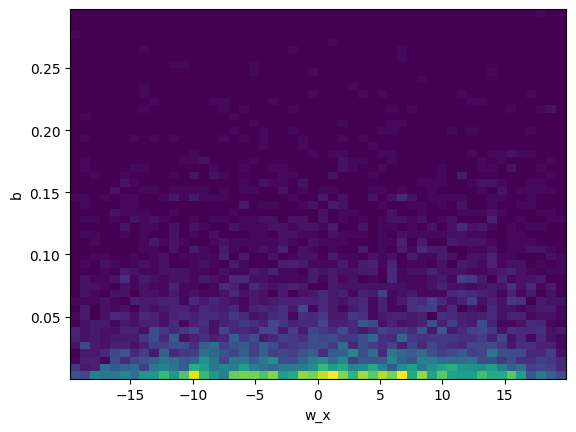

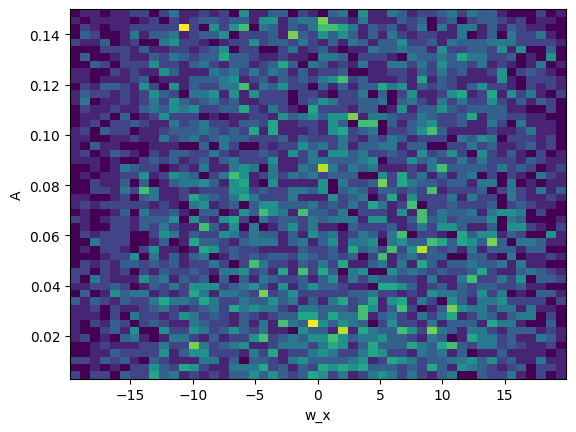

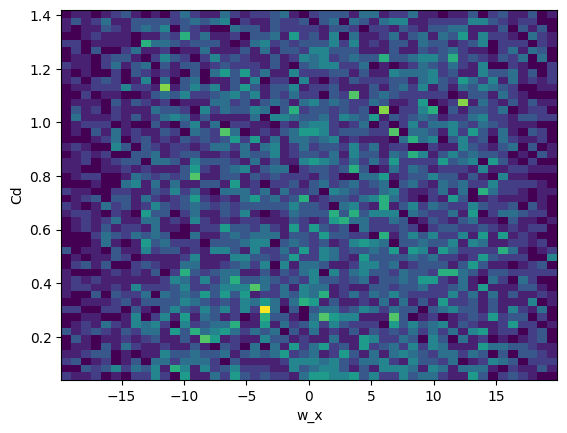

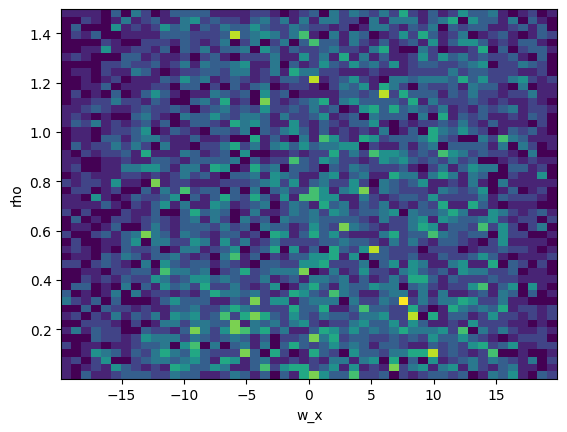

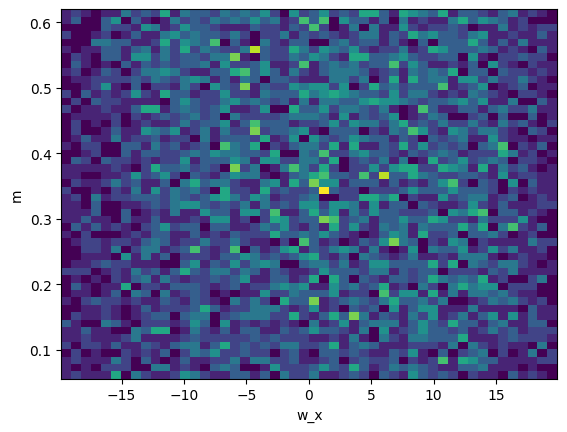

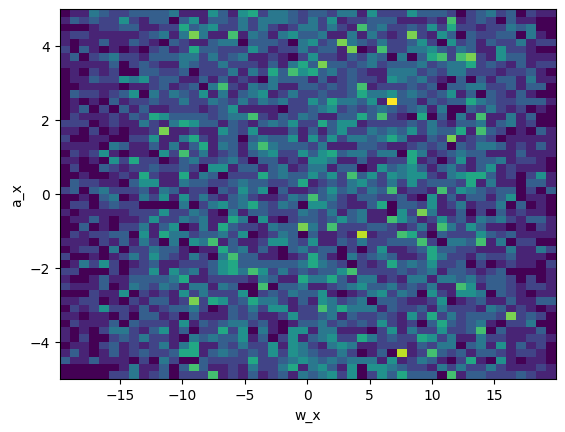

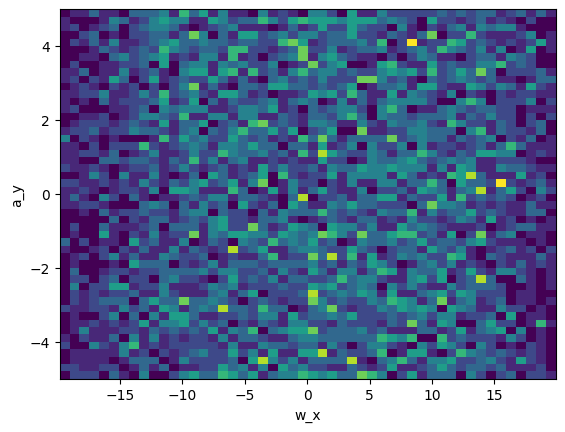

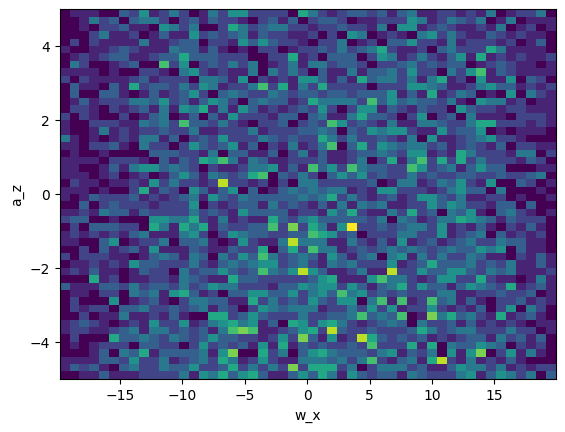

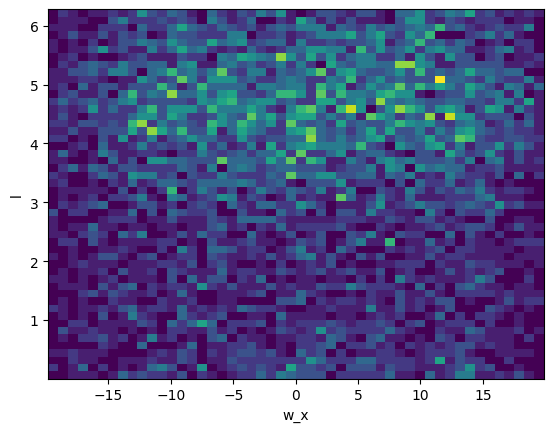

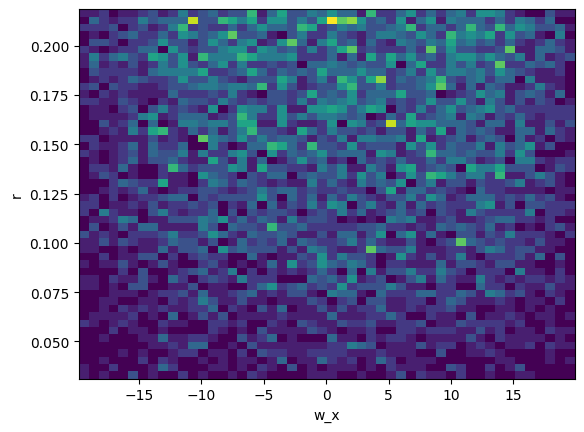

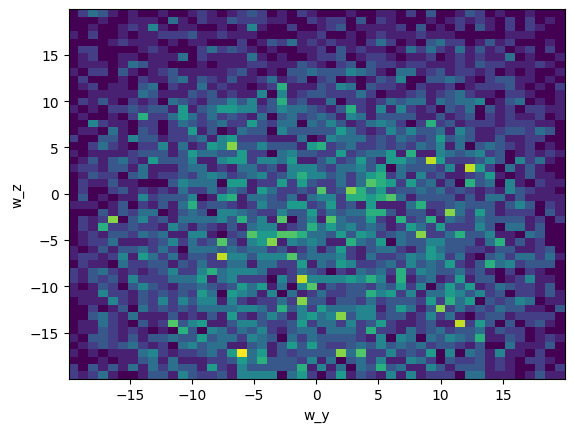

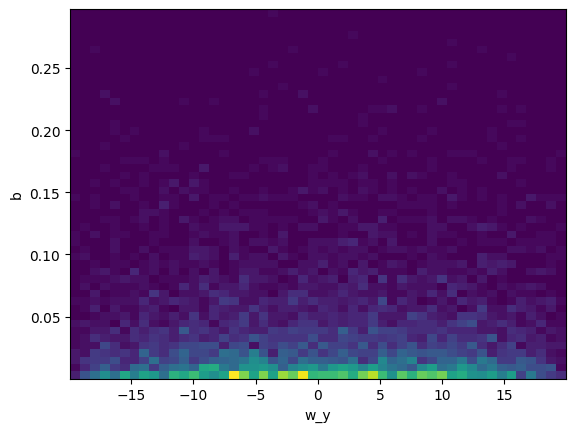

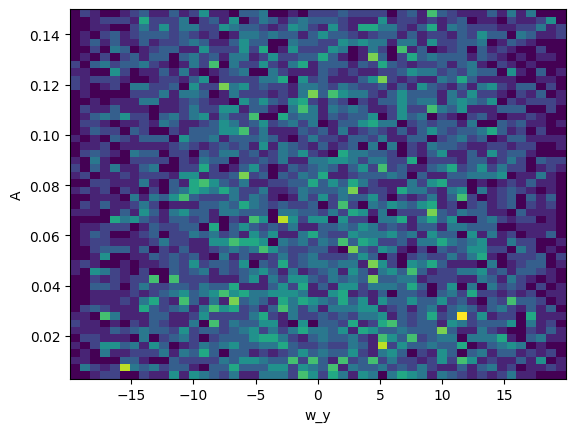

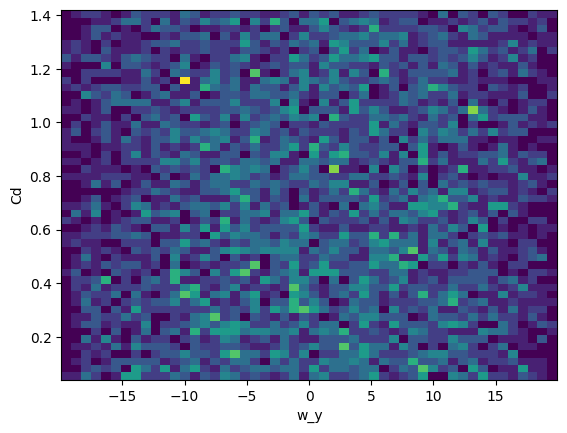

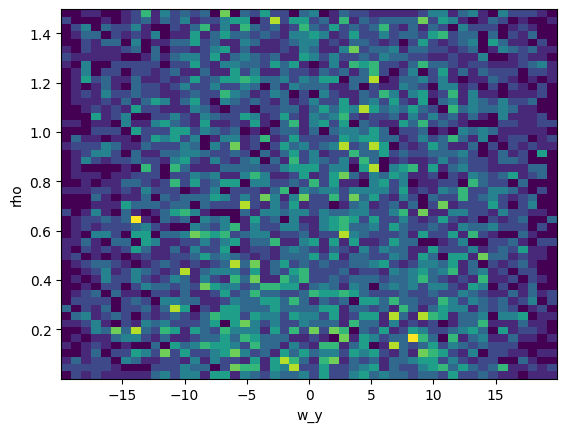

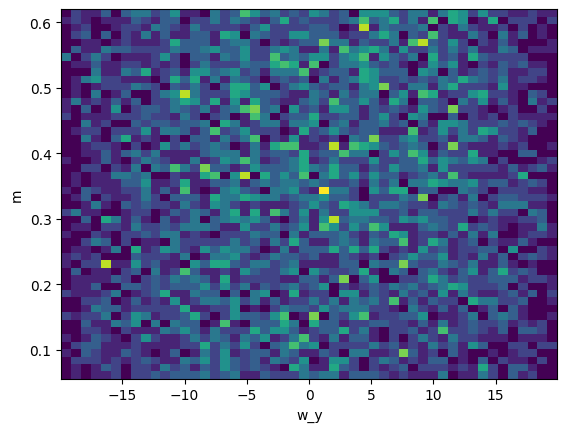

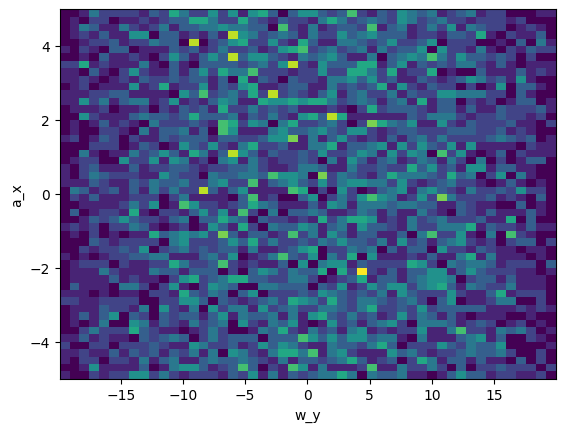

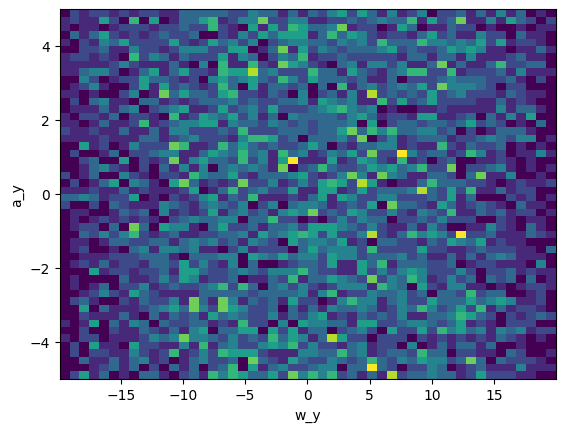

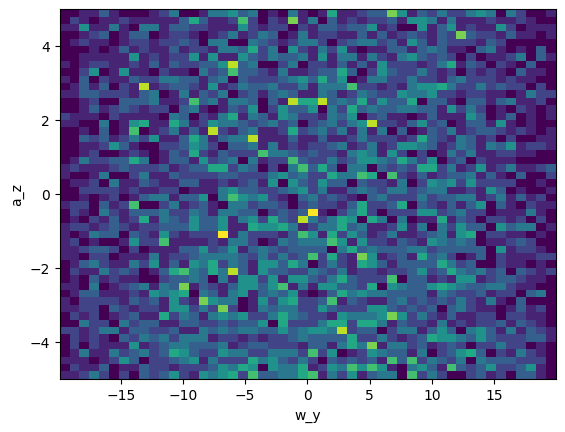

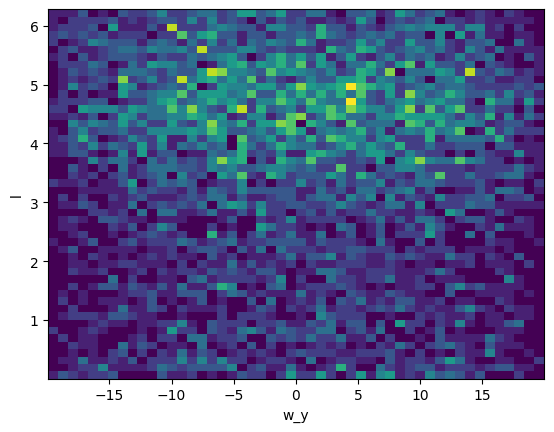

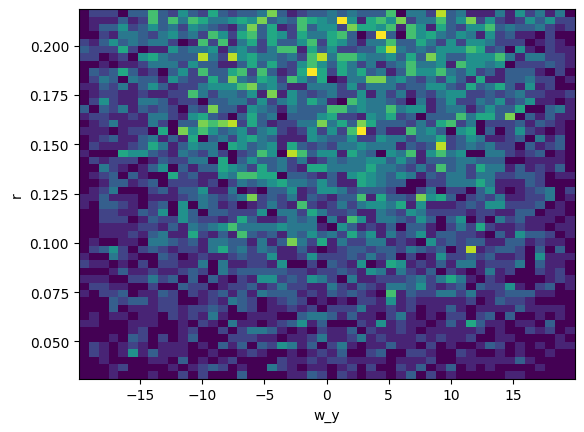

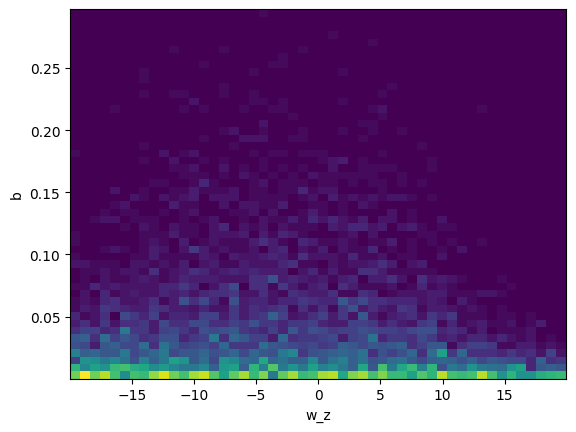

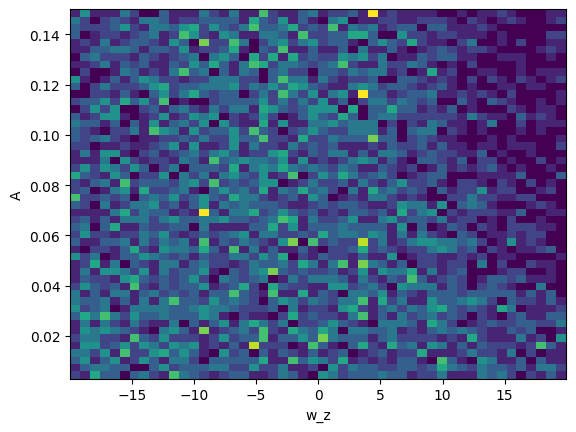

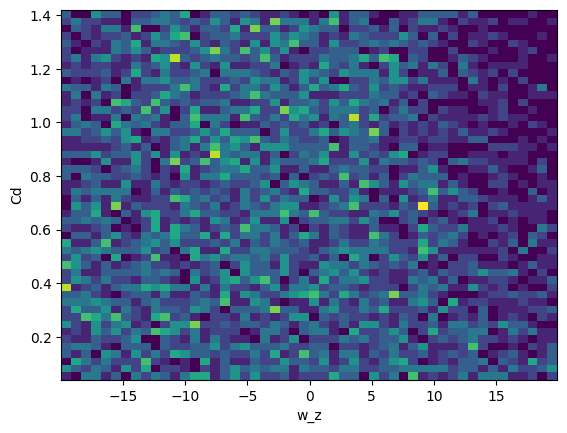

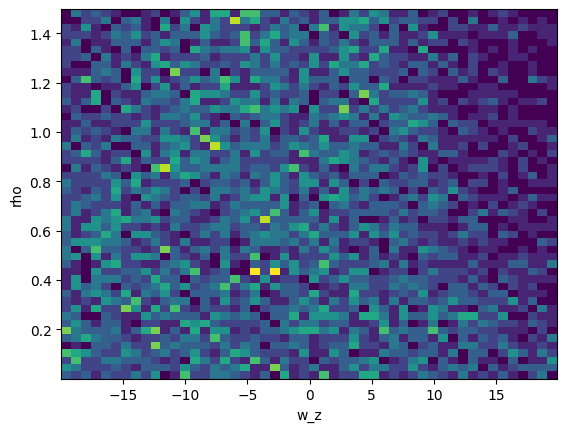

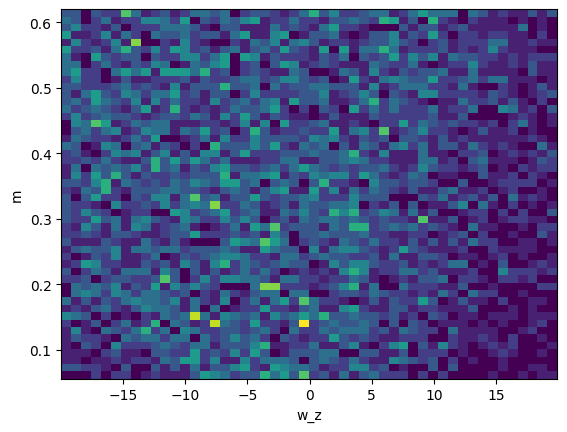

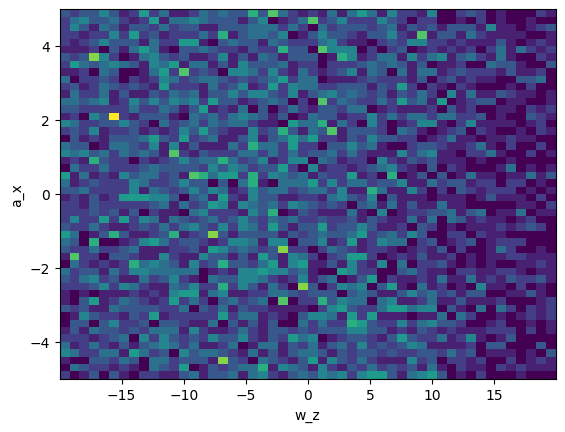

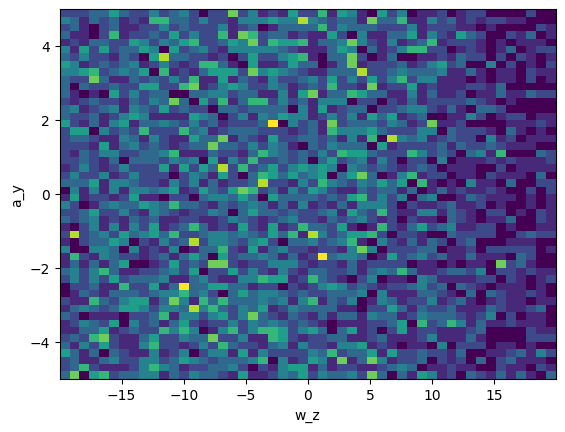

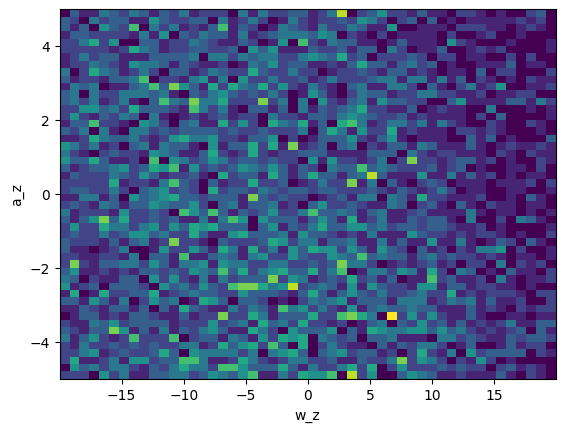

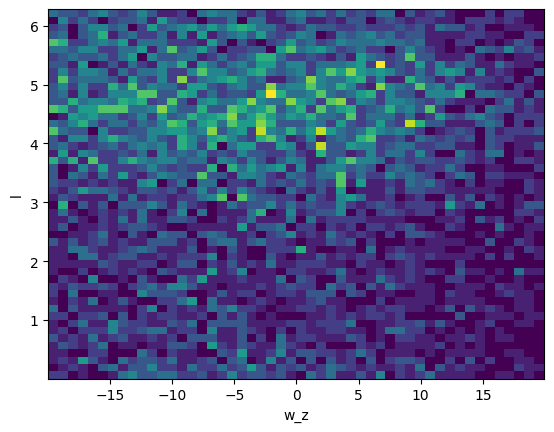

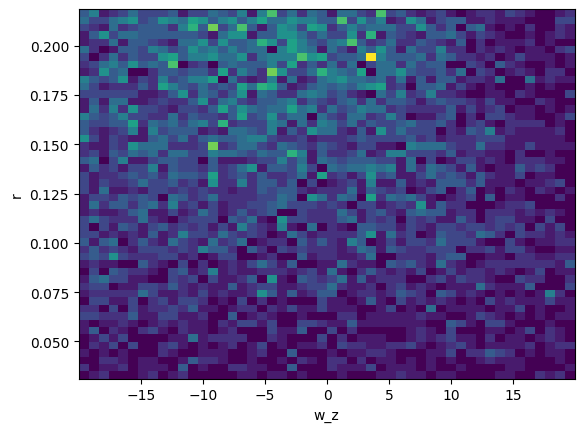

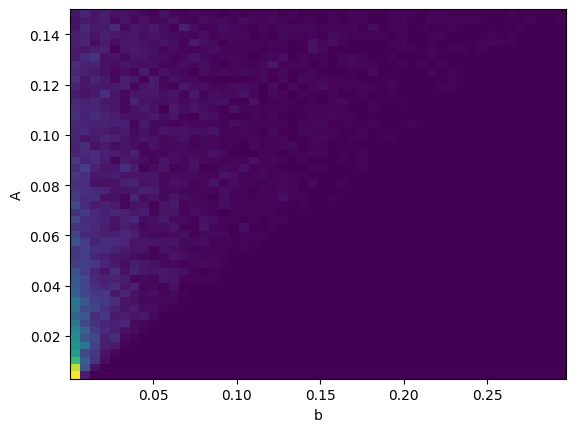

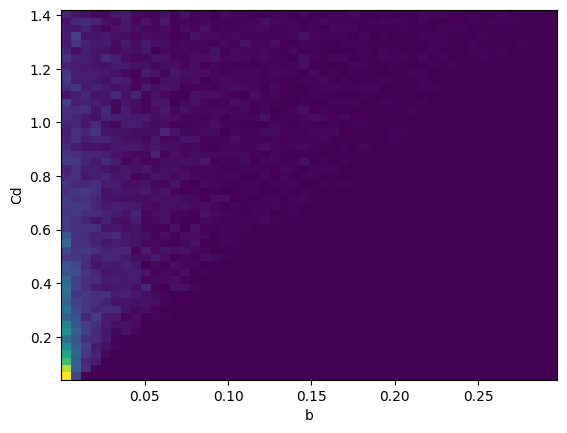

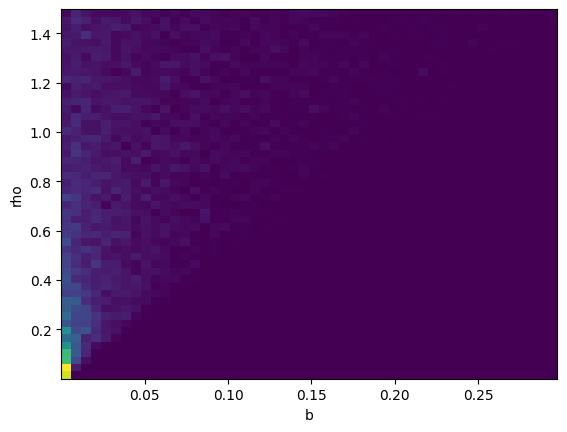

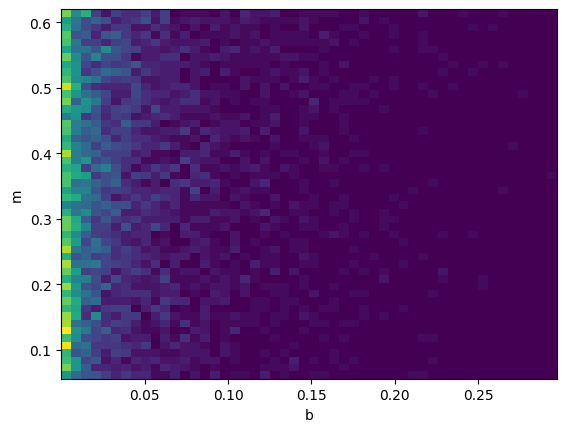

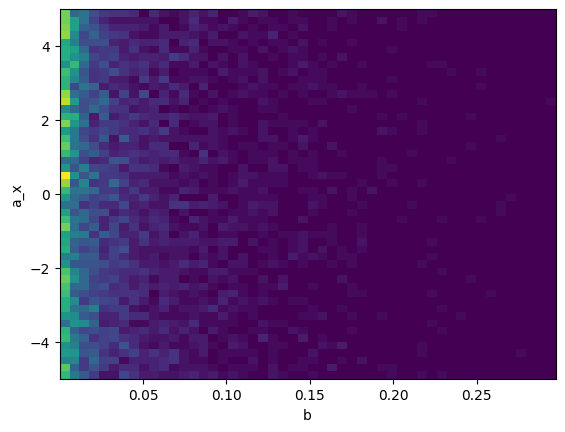

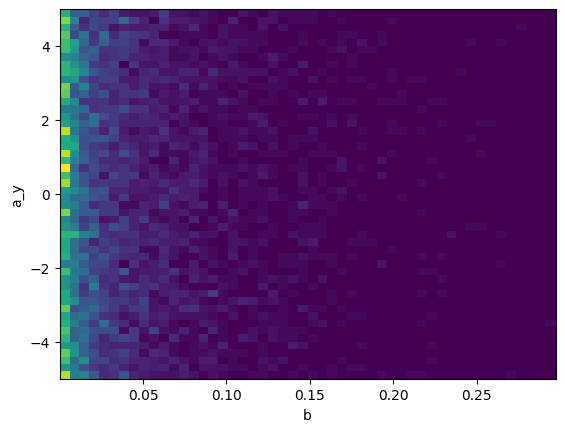

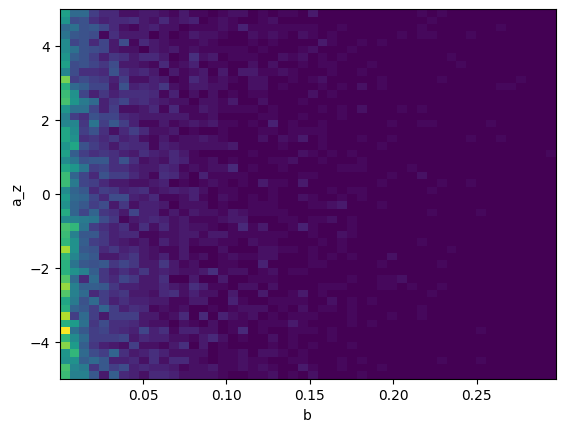

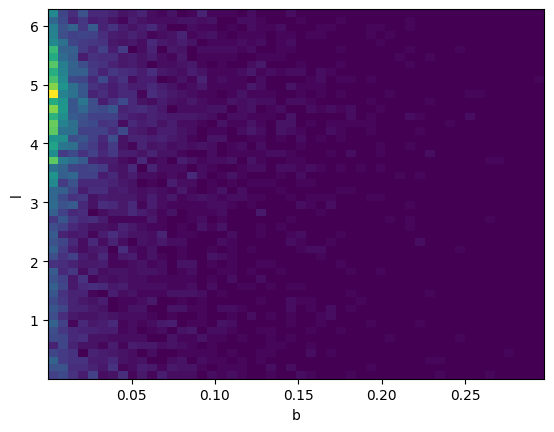

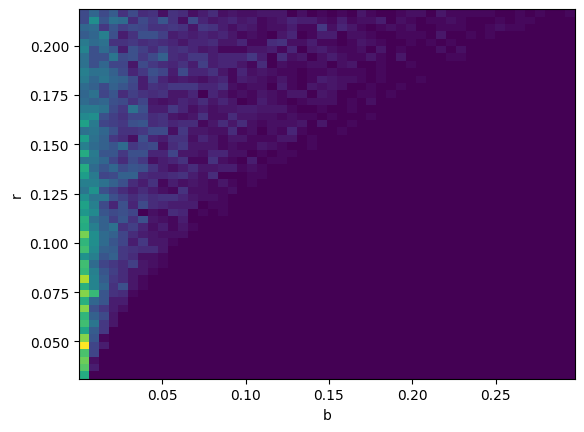

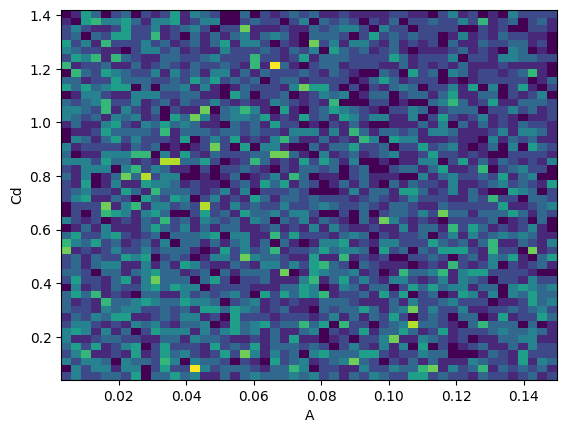

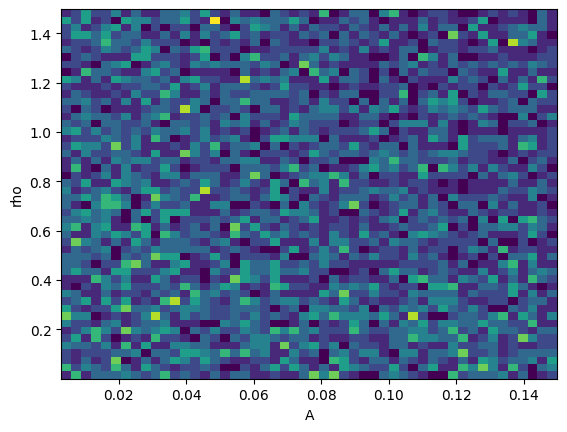

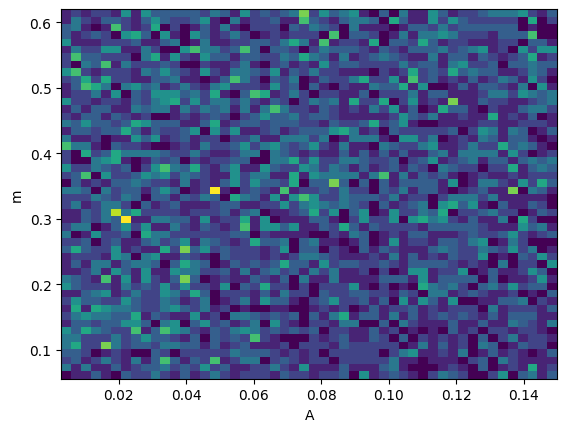

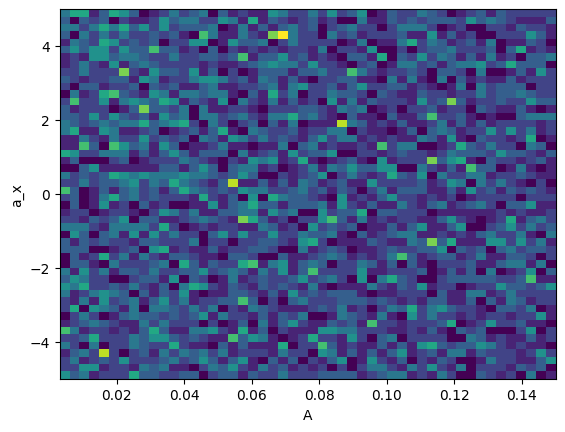

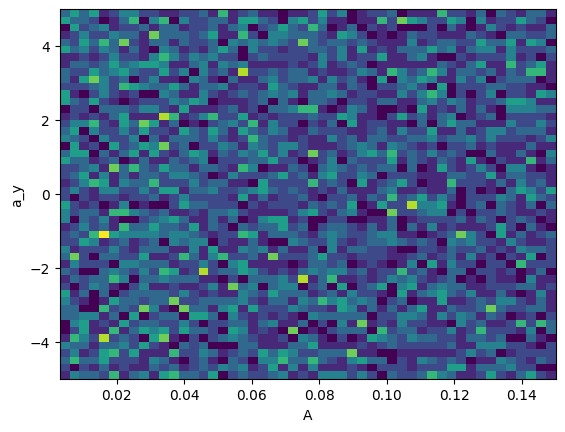

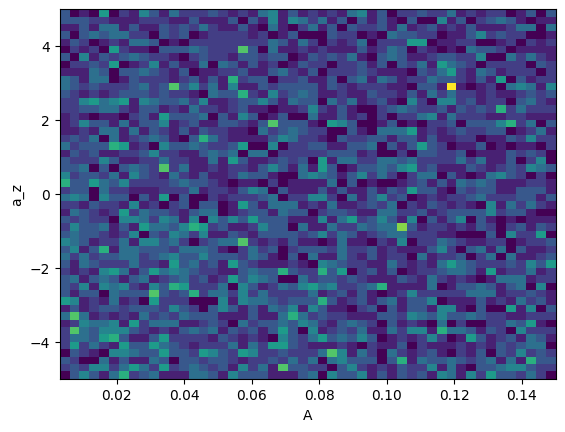

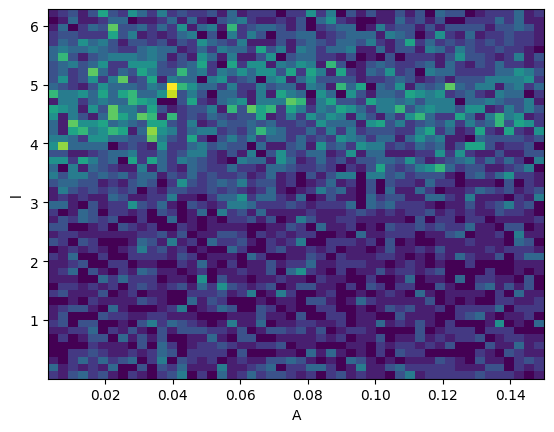

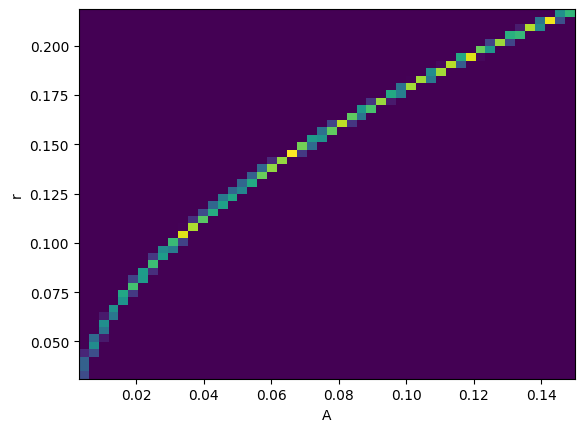

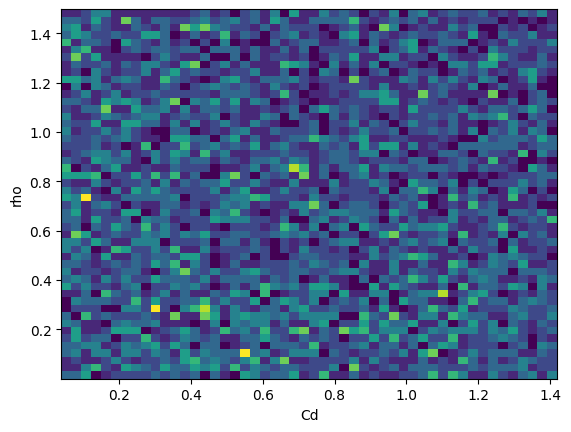

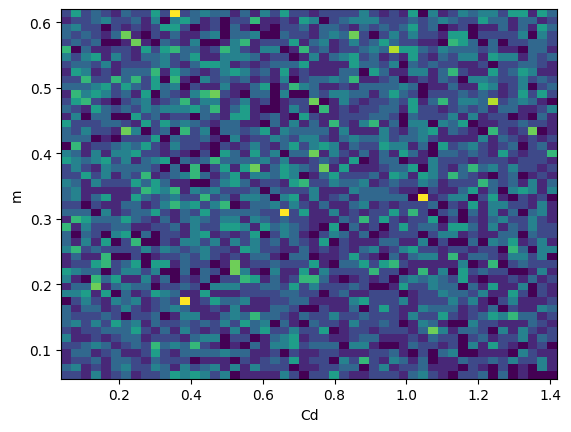

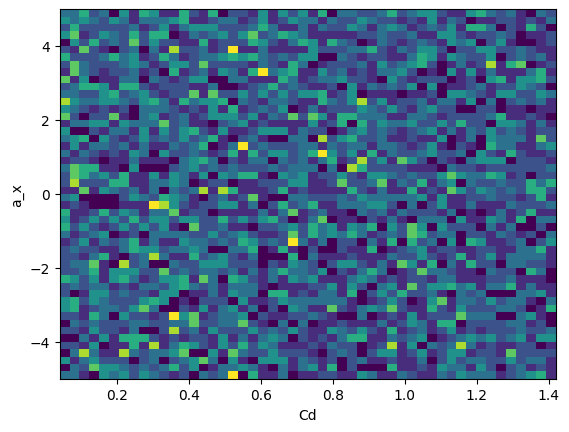

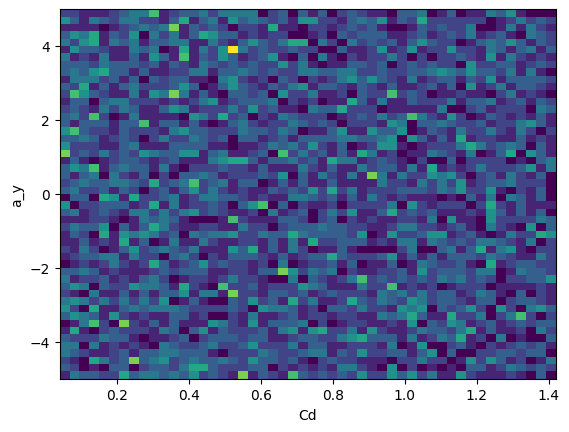

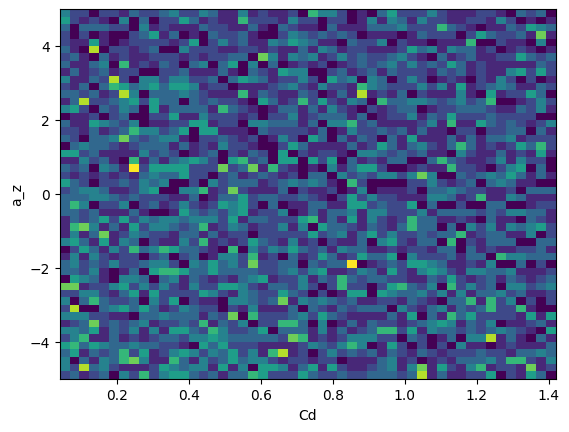

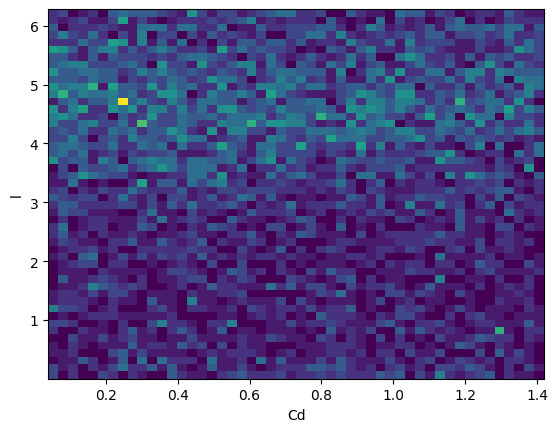

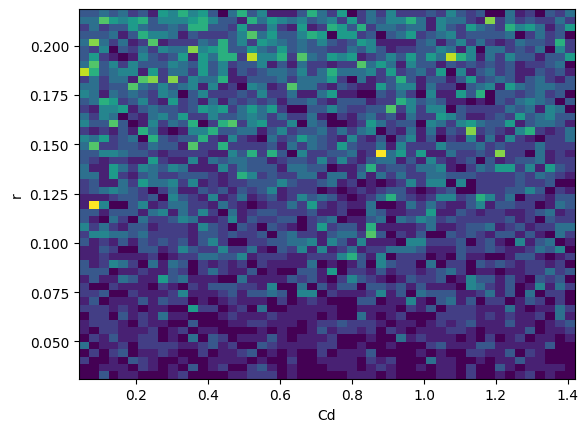

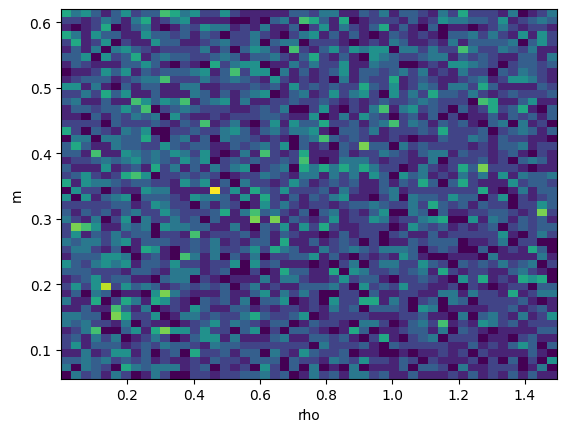

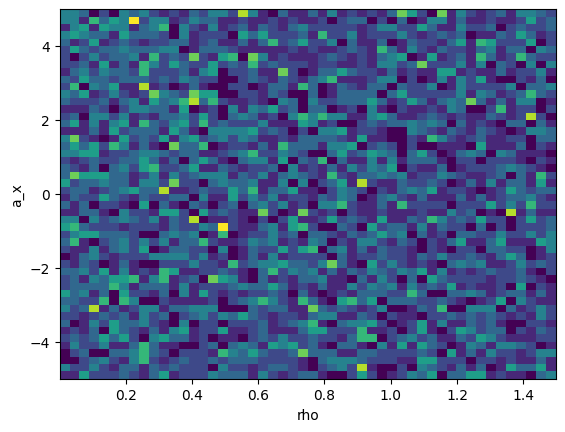

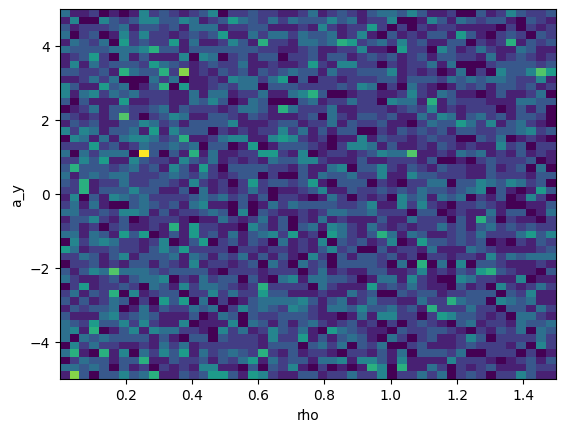

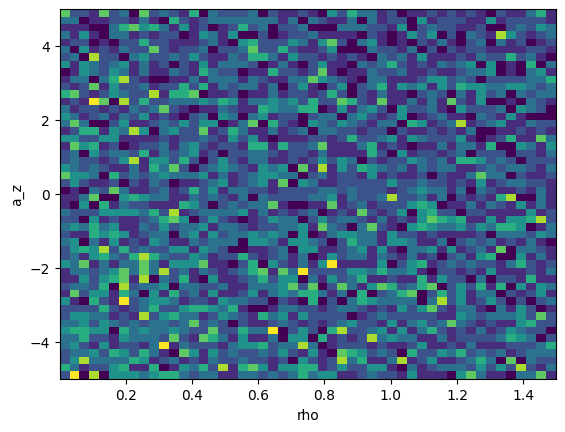

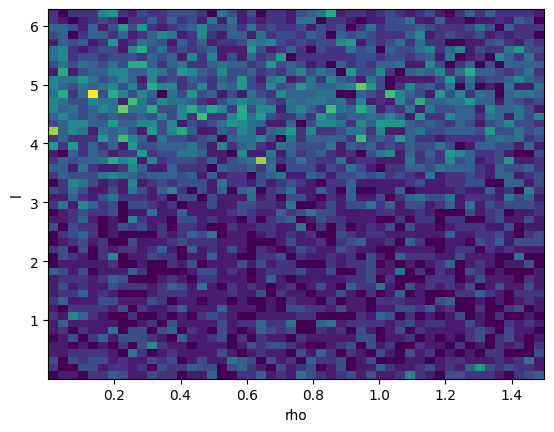

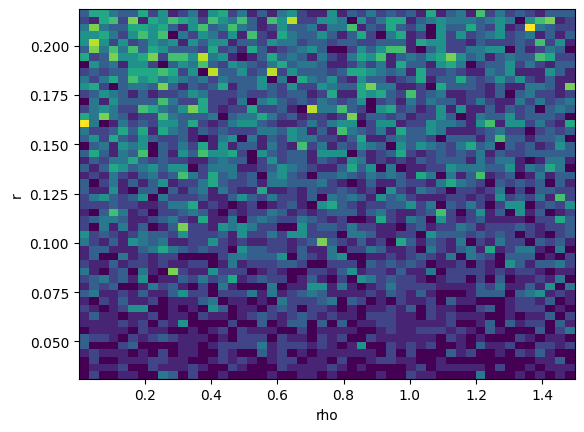

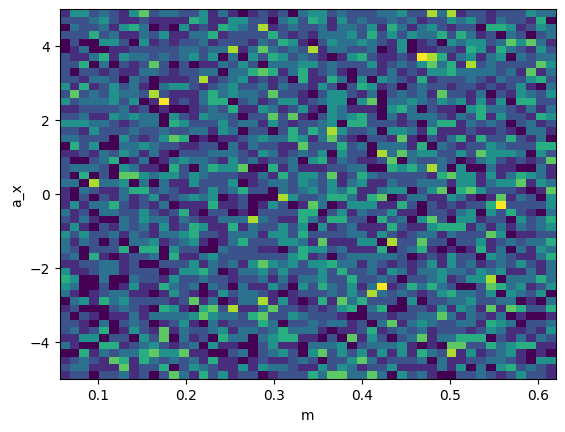

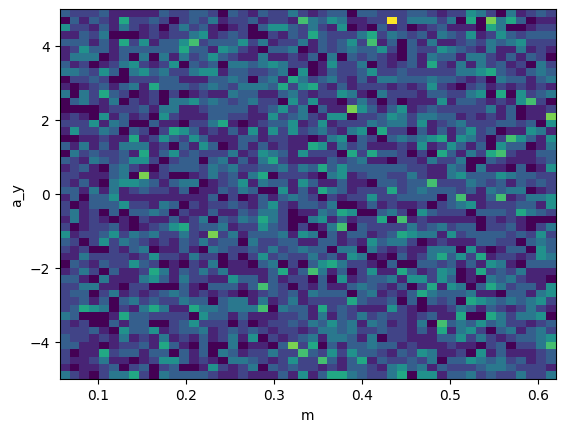

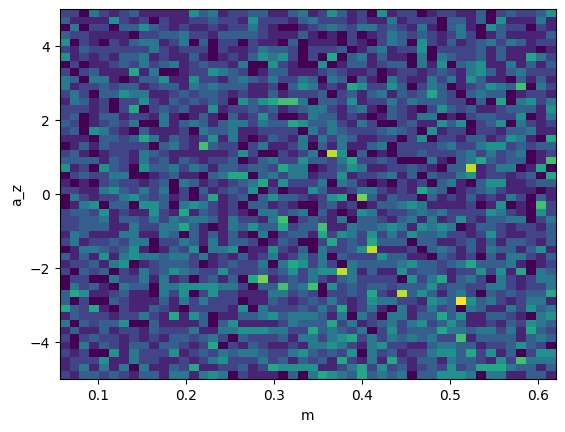

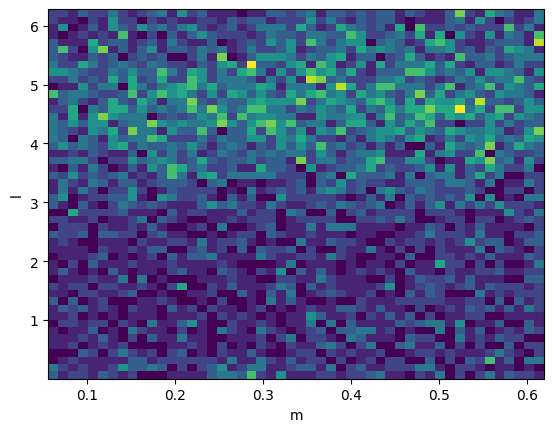

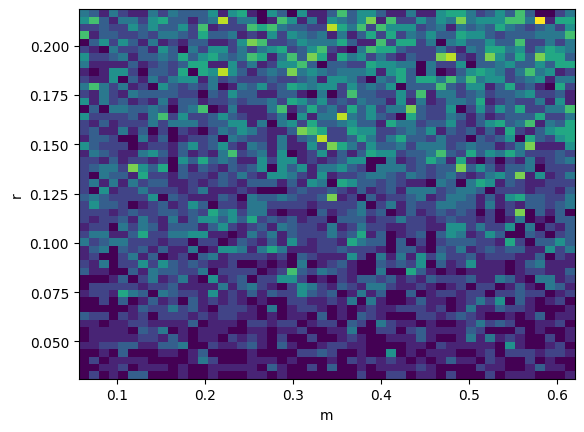

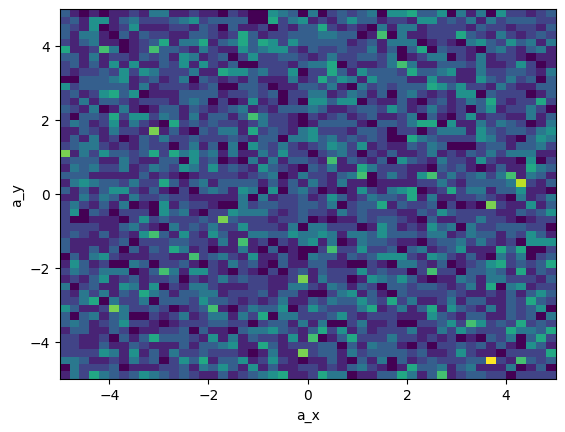

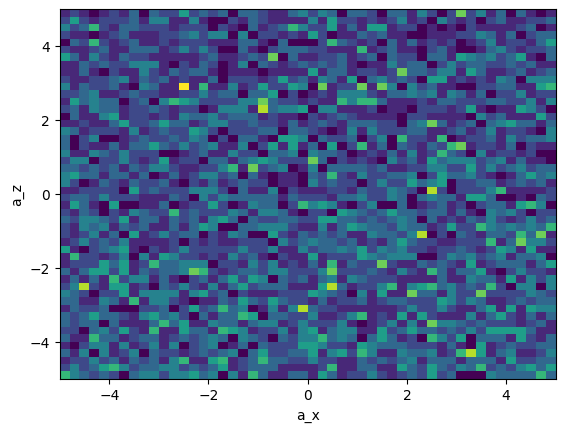

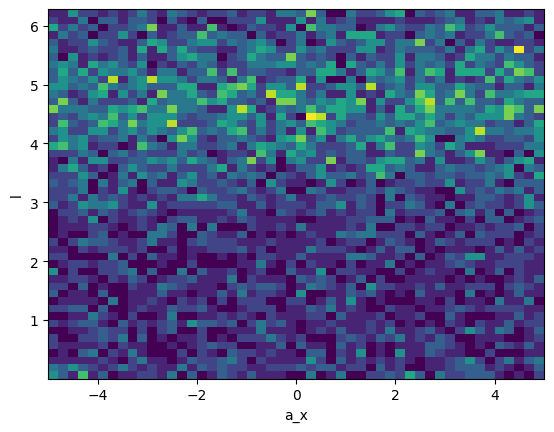

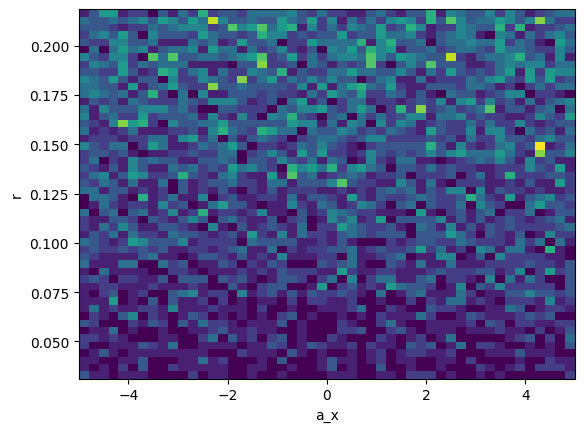

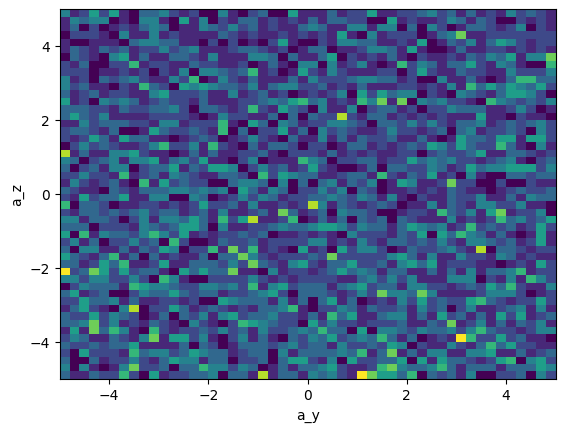

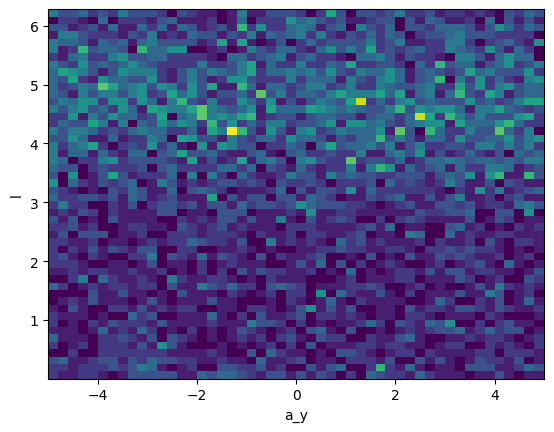

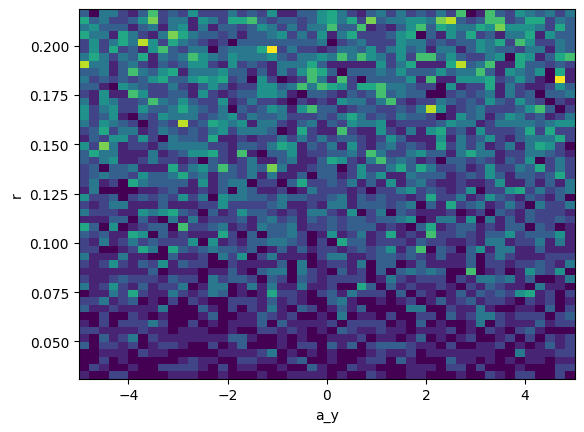

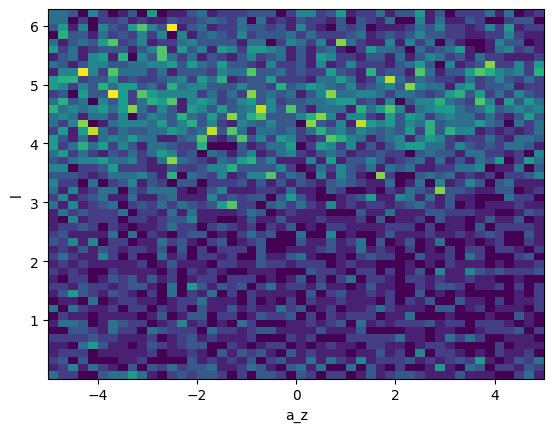

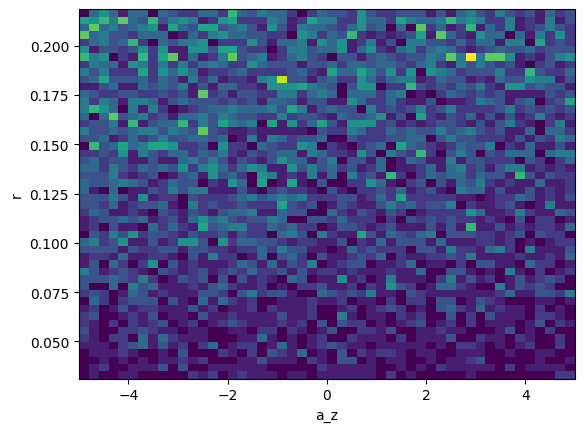

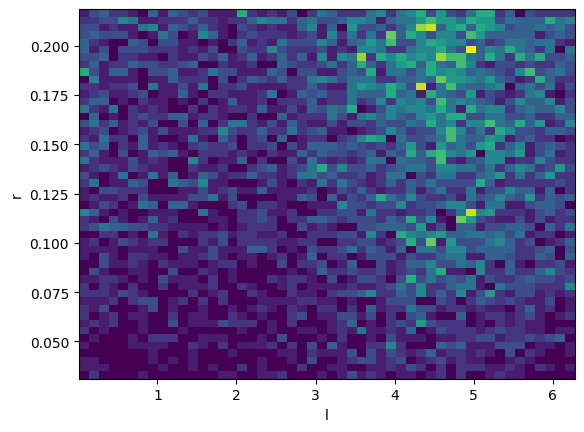

In [7]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=50)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

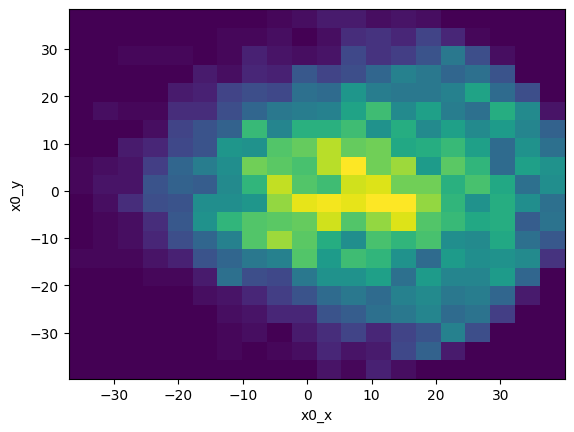

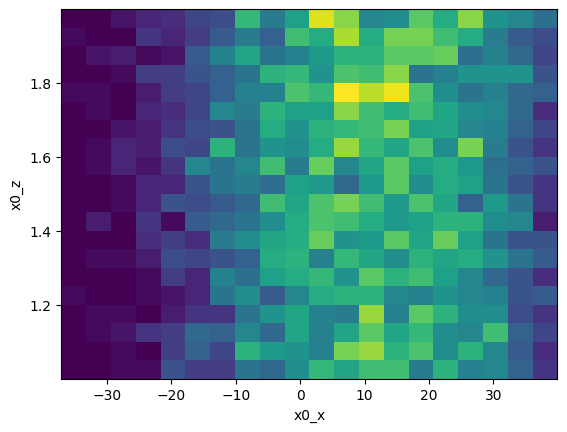

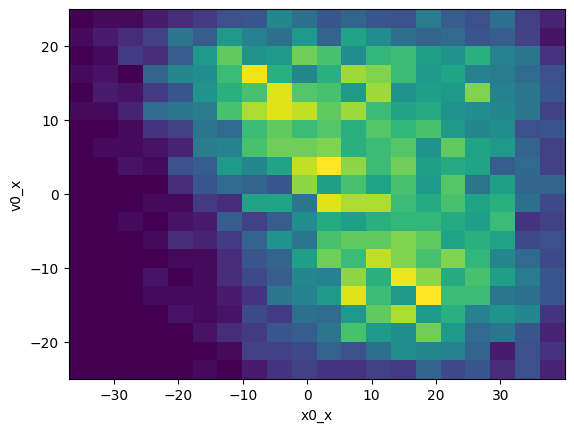

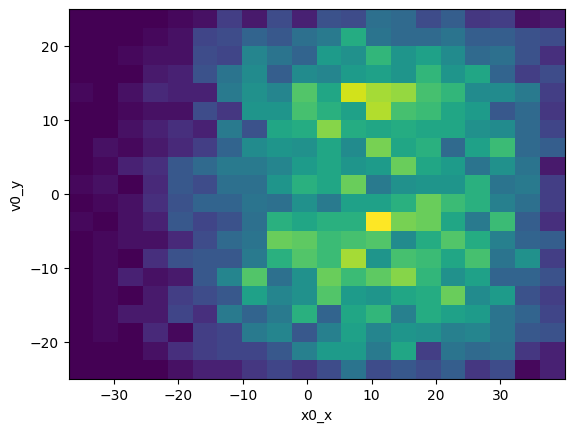

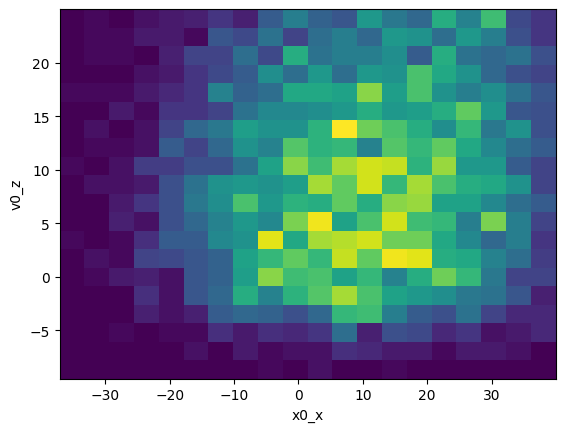

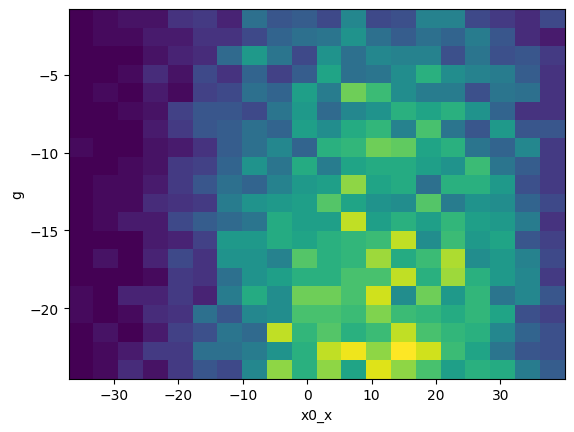

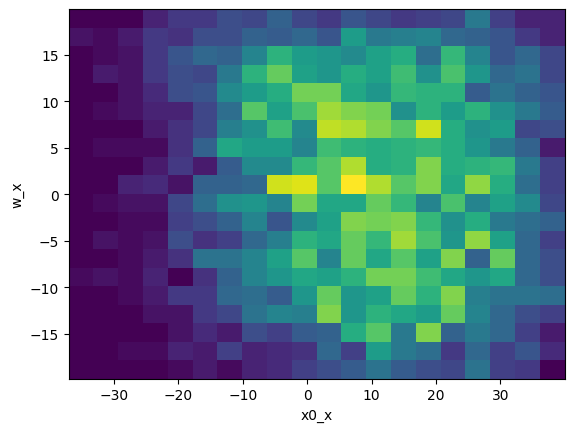

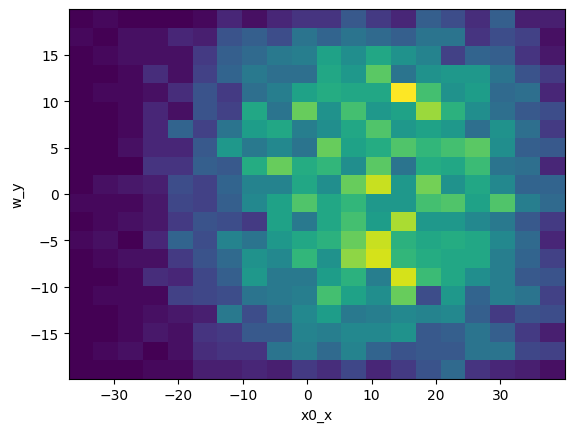

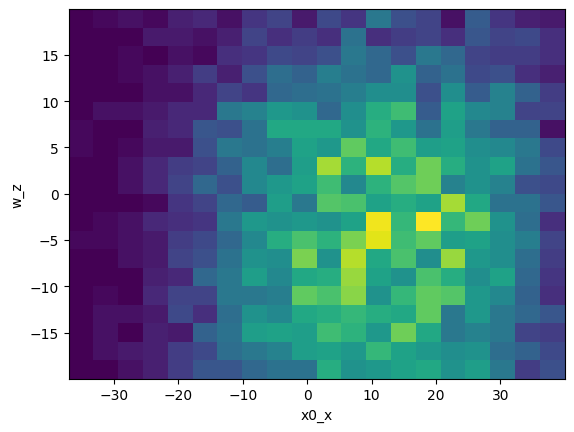

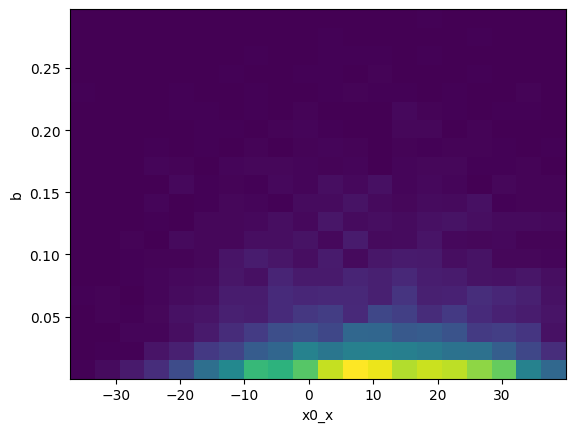

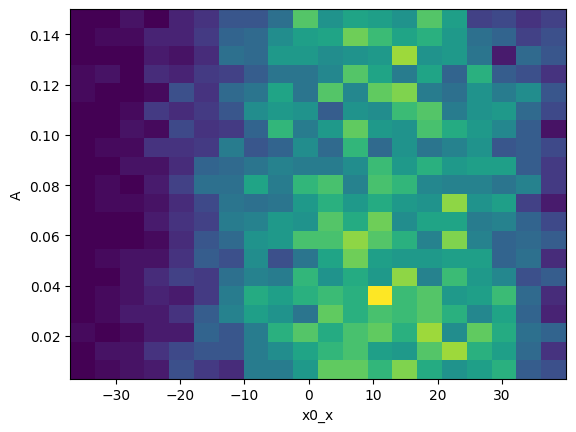

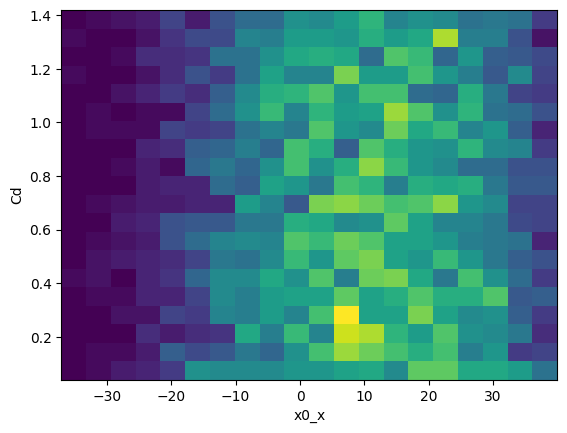

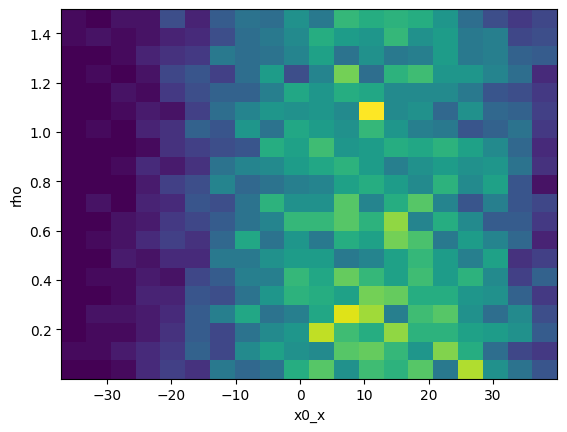

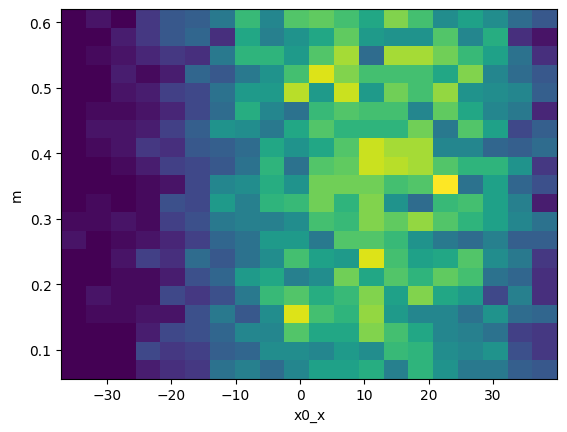

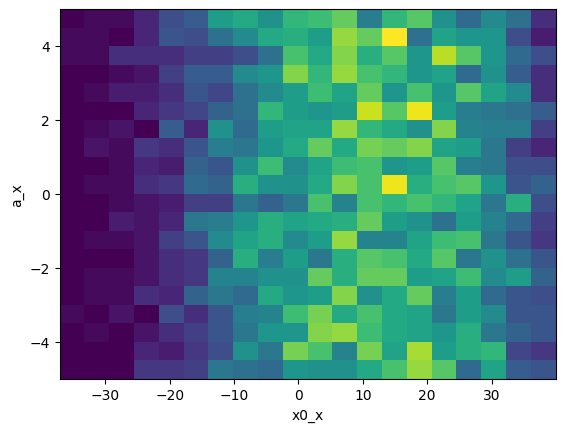

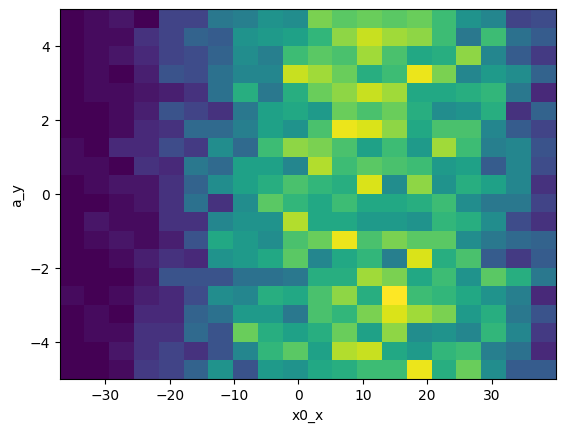

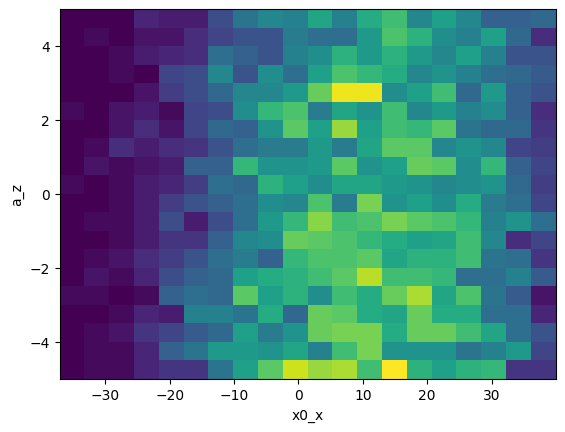

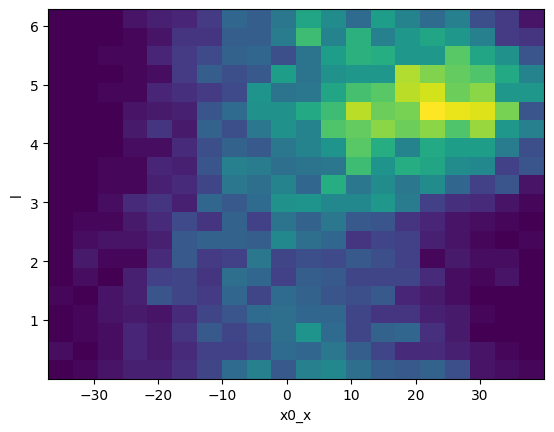

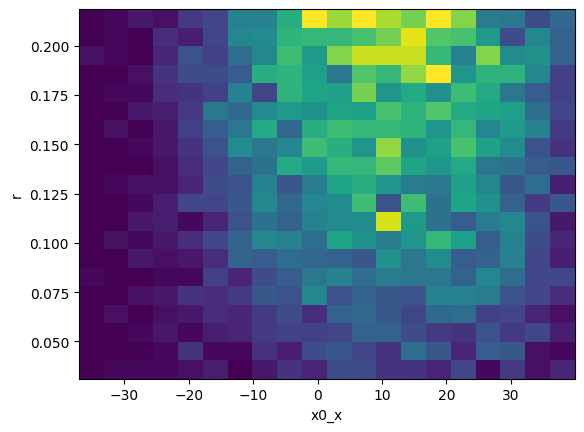

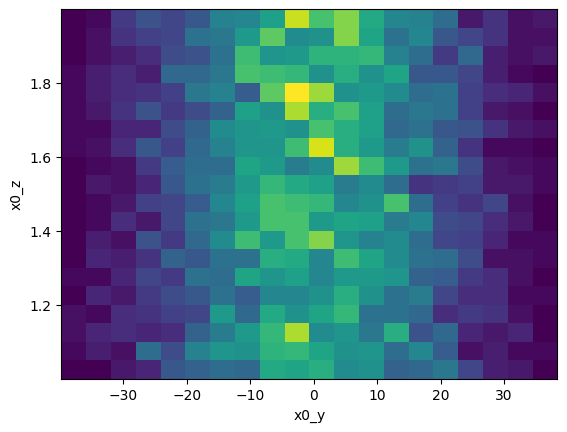

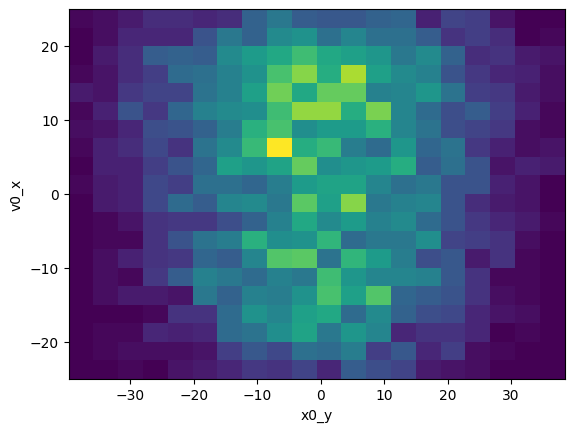

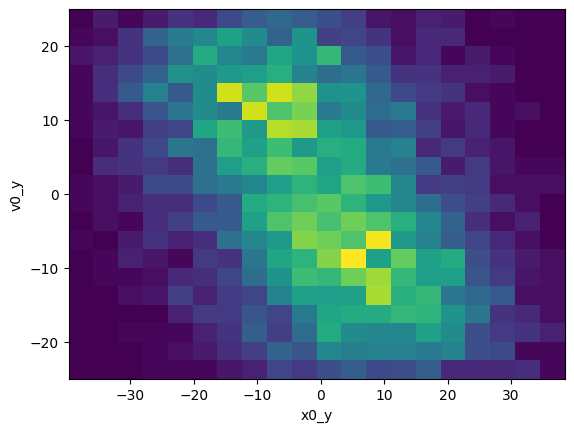

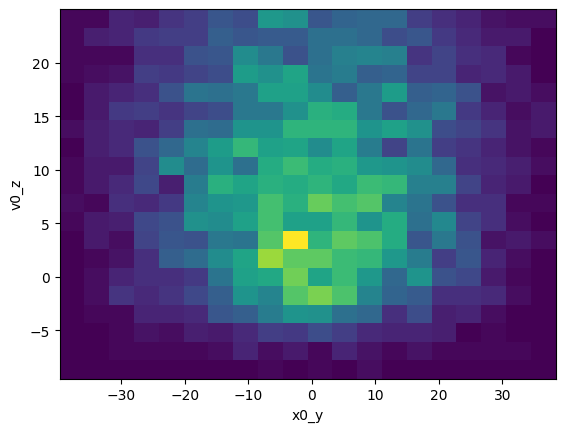

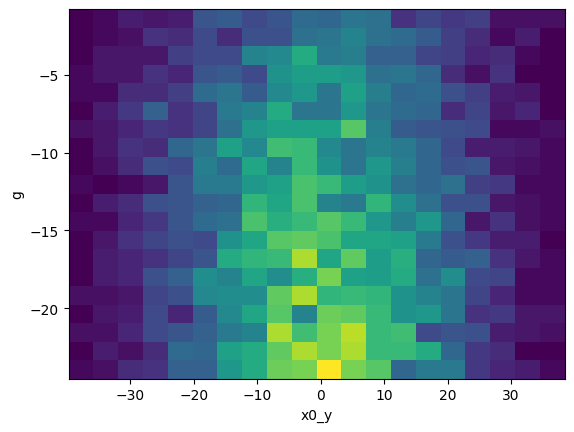

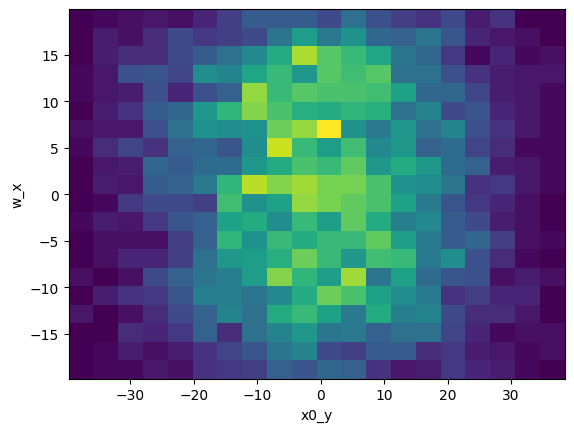

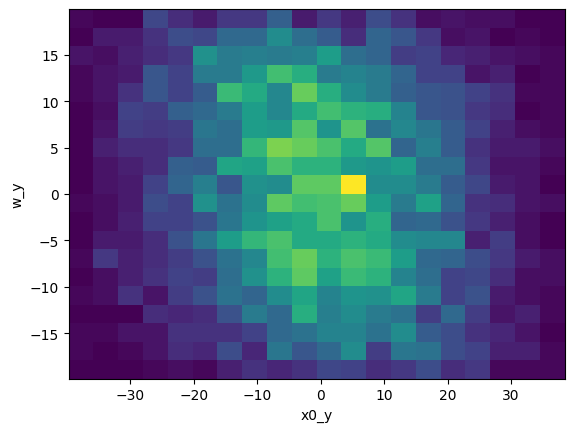

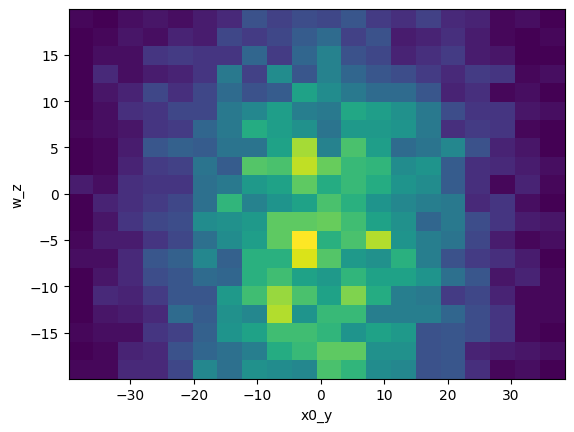

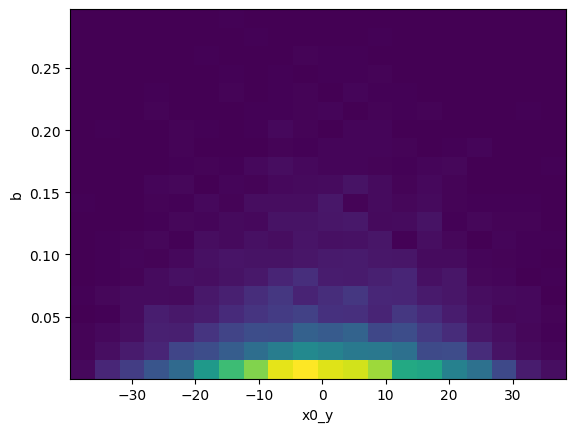

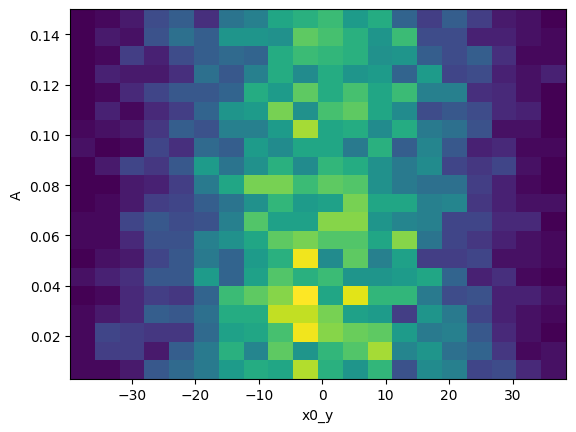

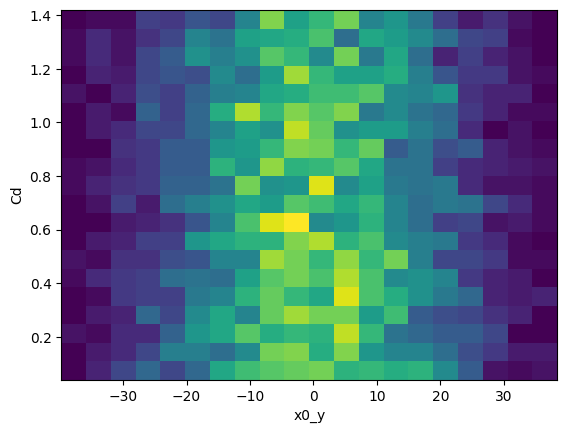

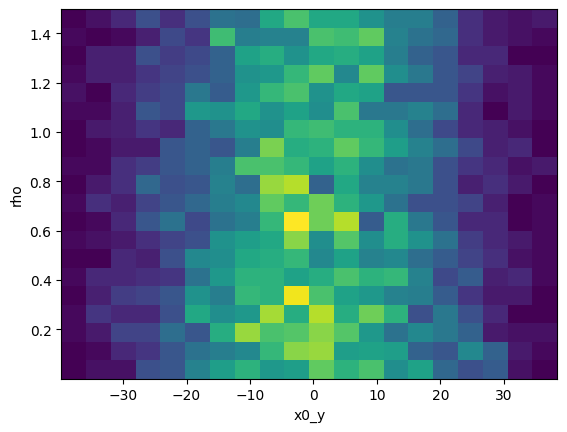

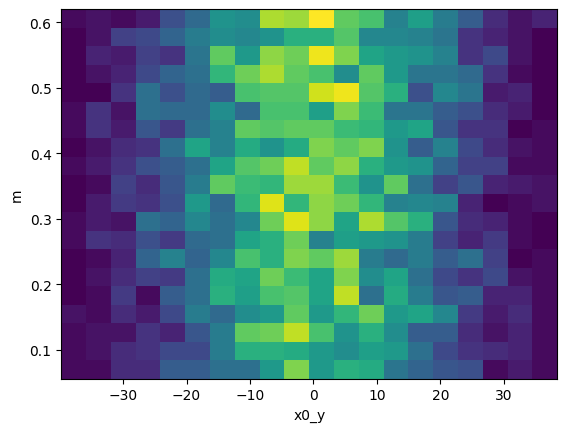

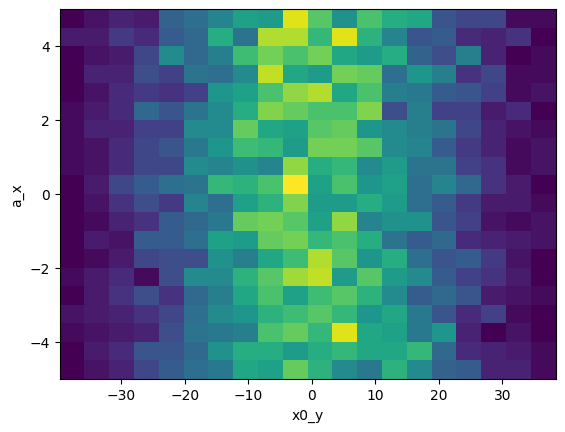

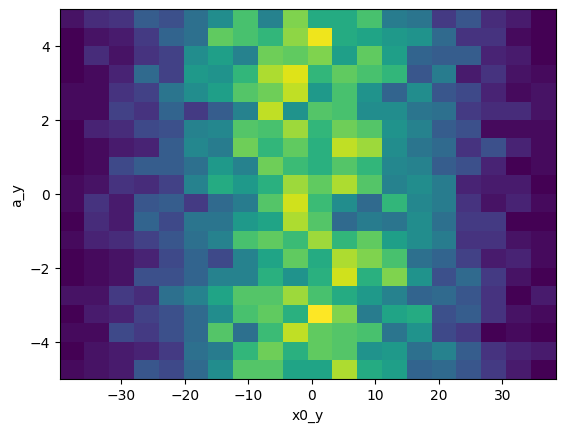

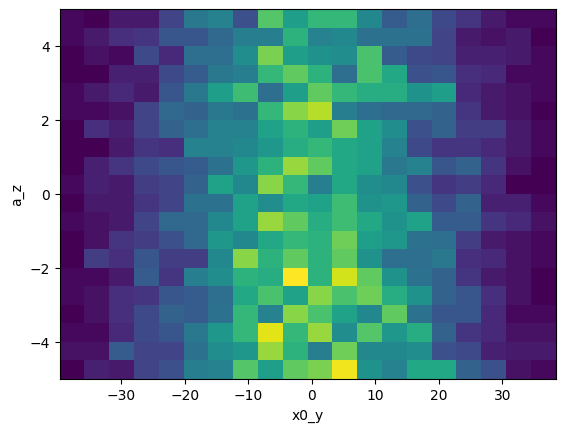

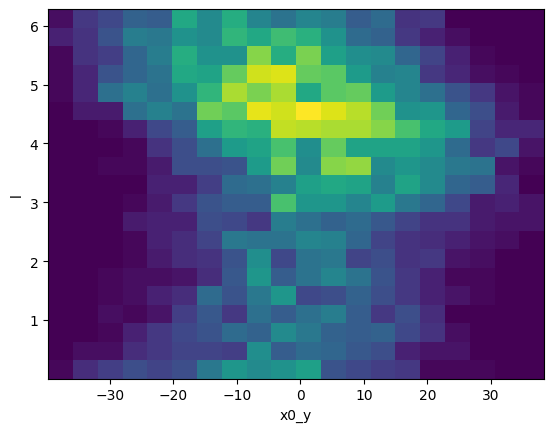

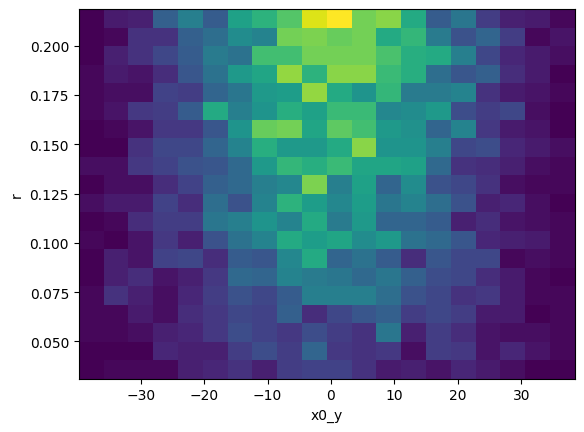

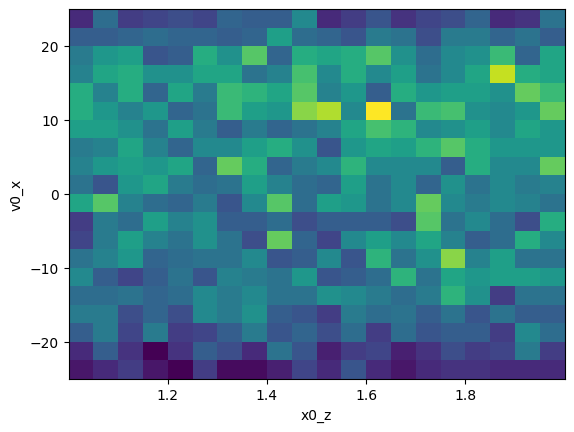

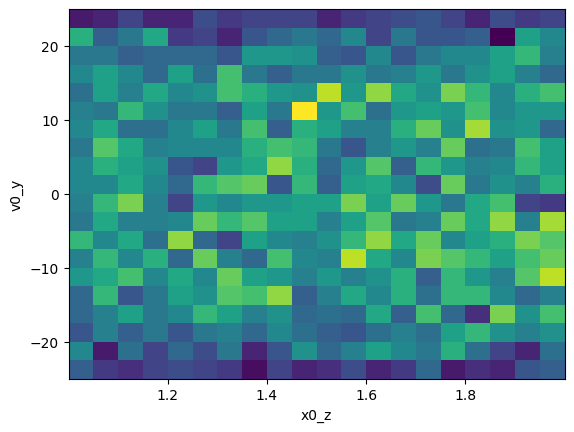

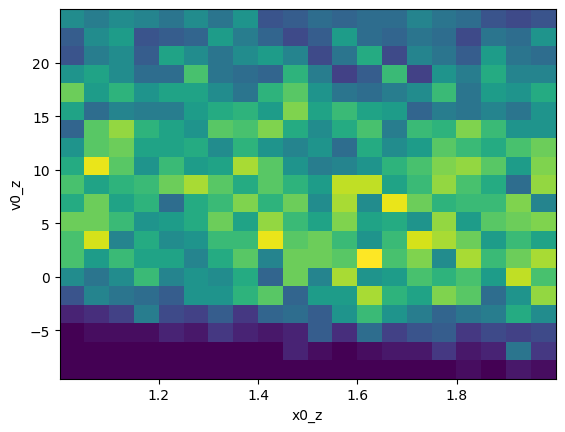

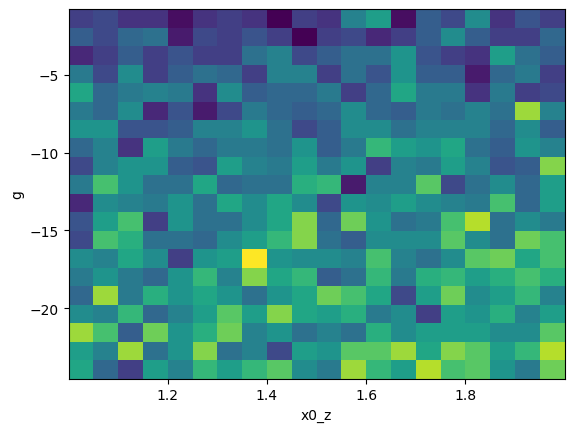

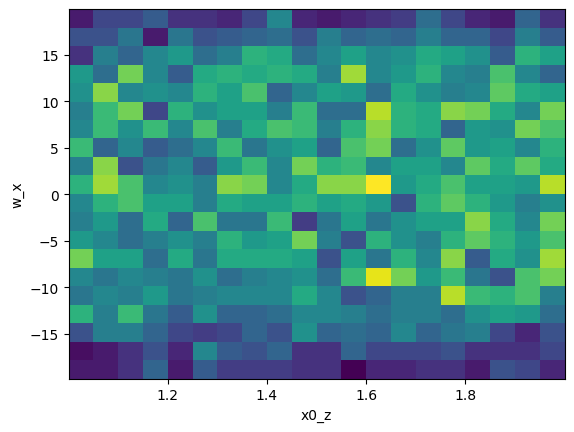

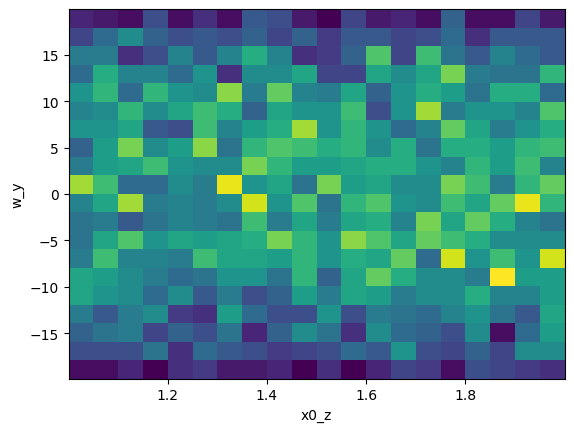

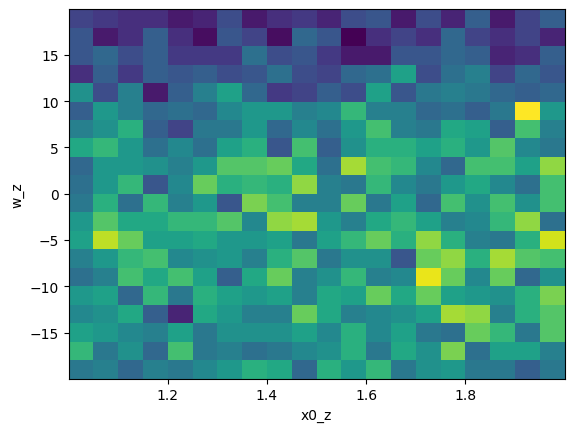

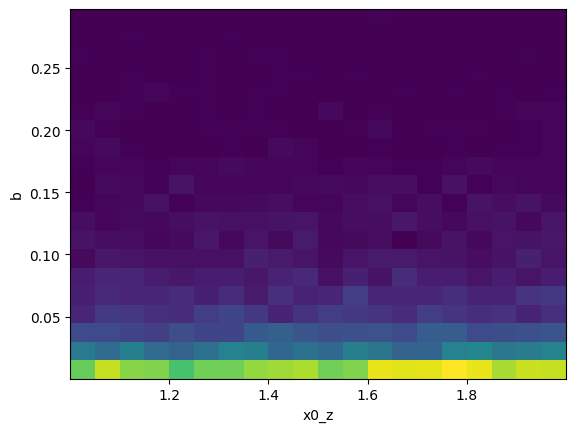

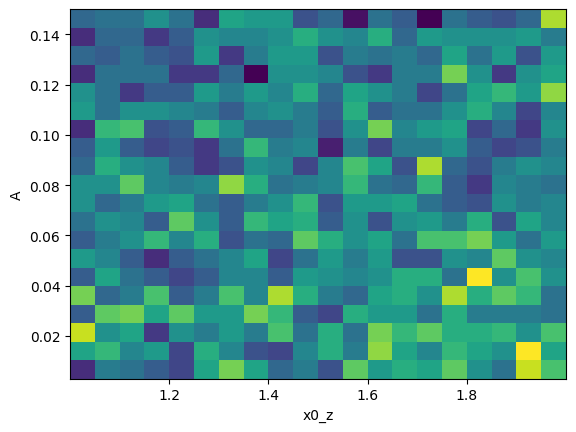

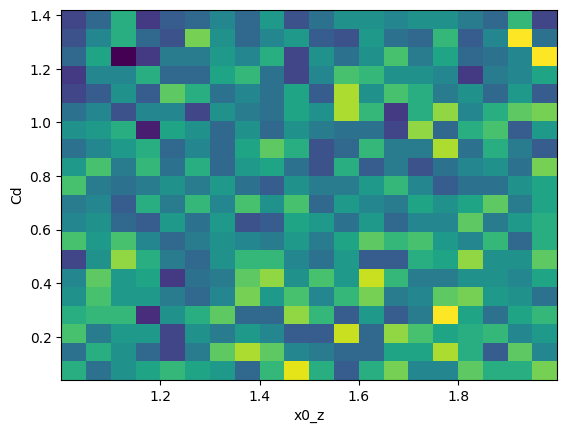

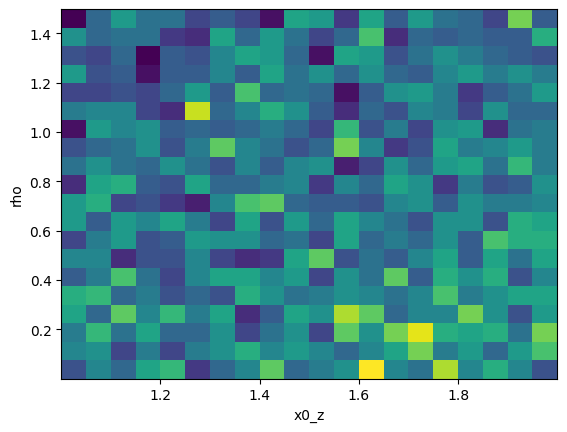

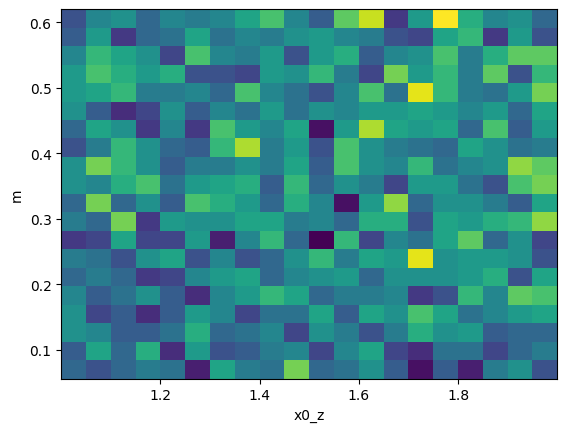

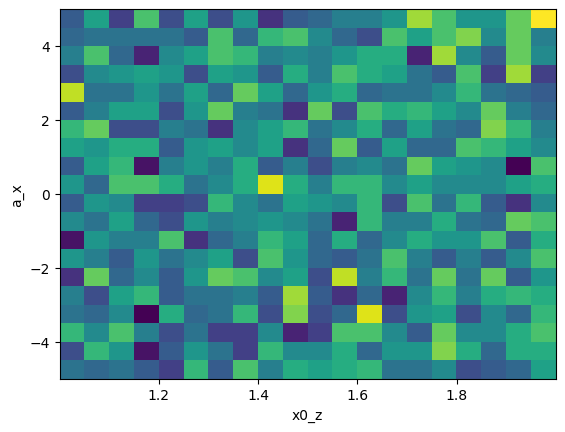

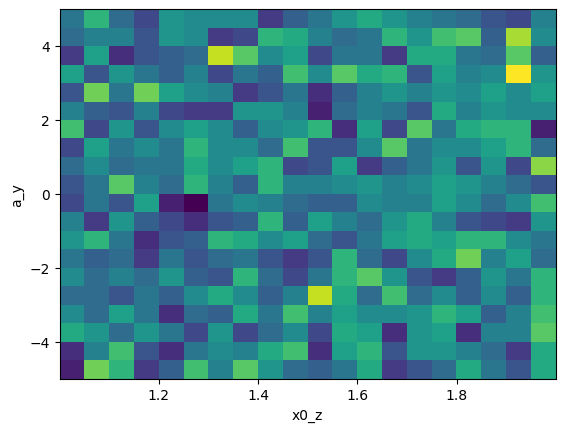

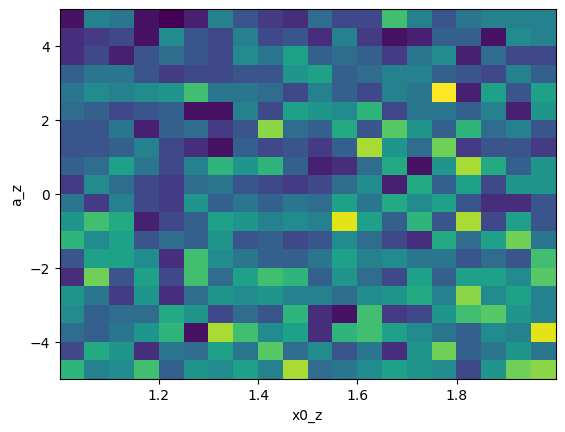

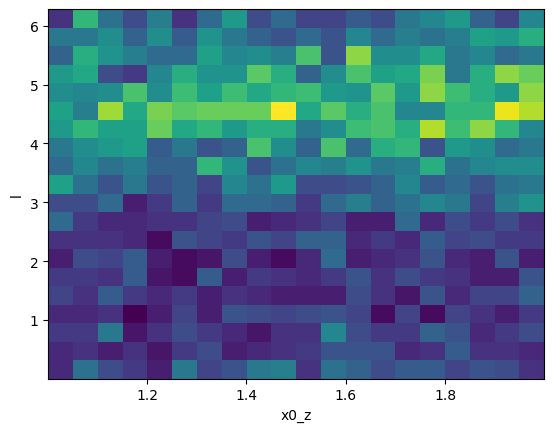

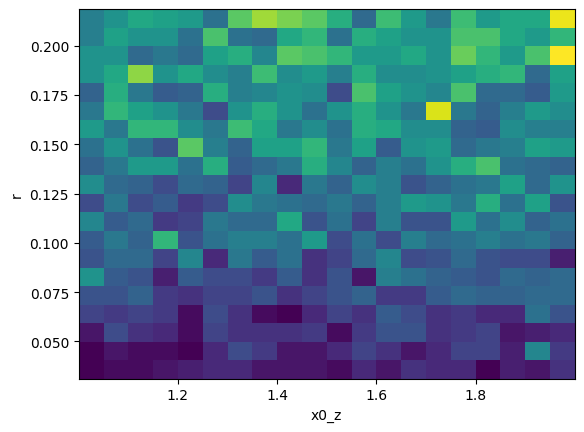

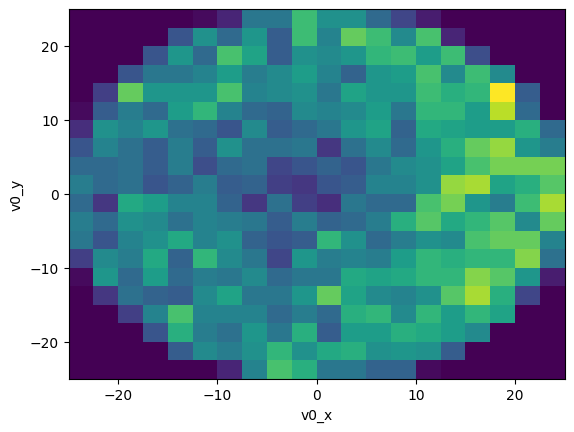

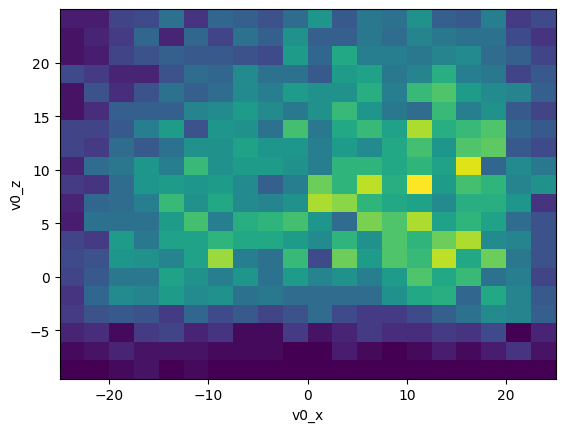

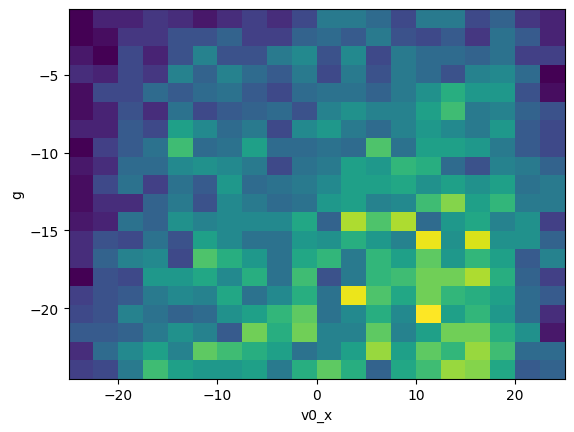

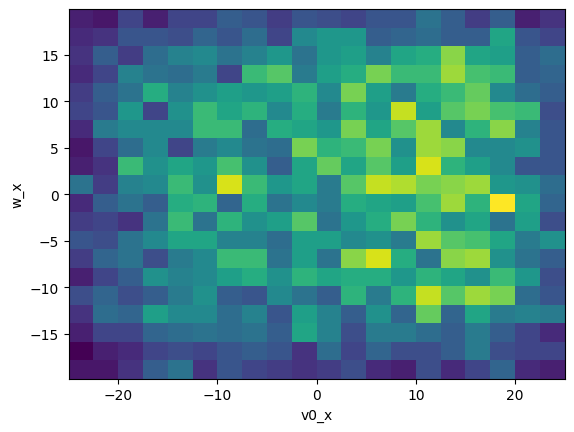

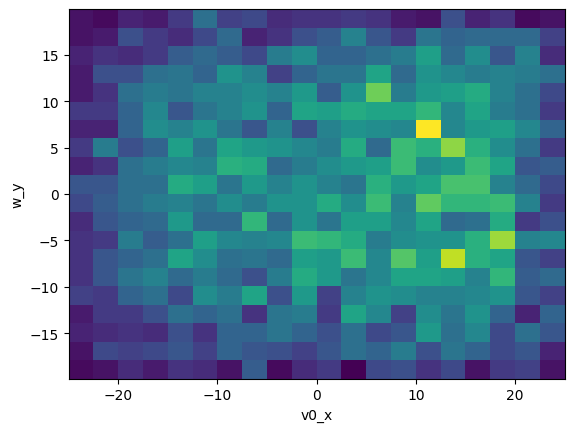

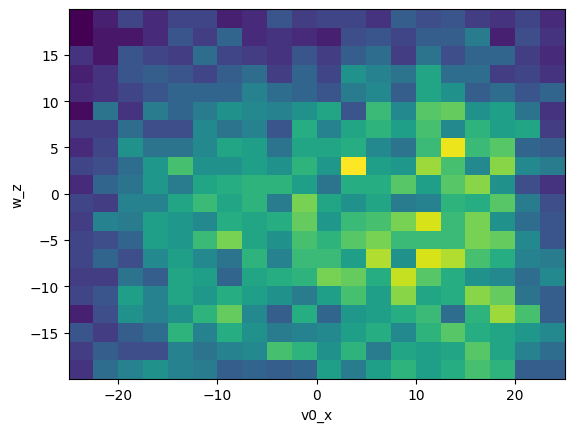

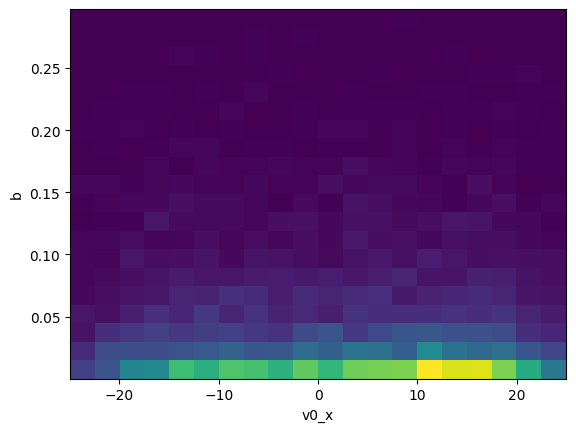

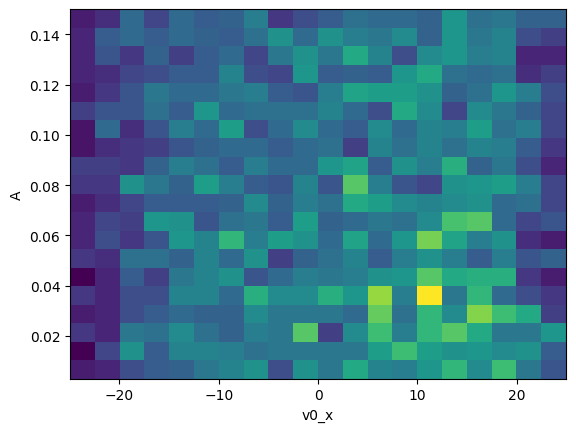

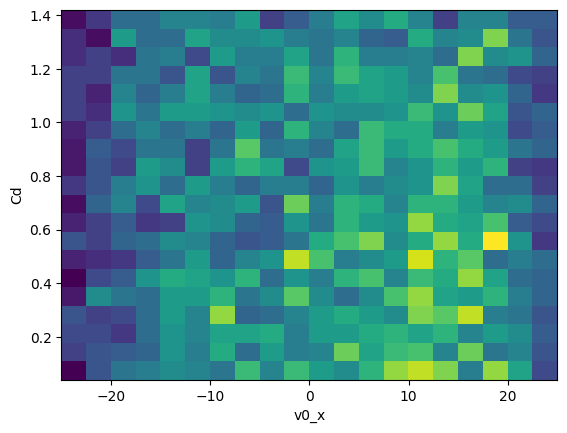

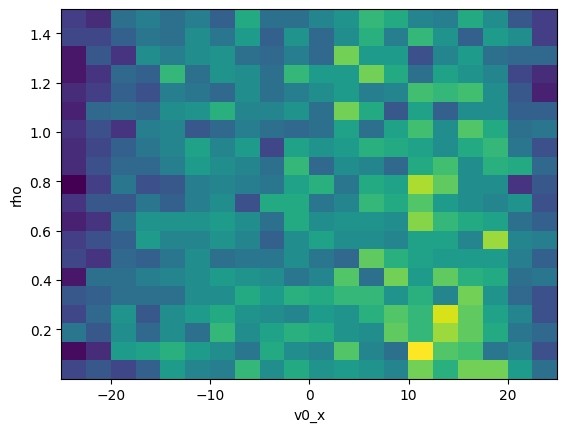

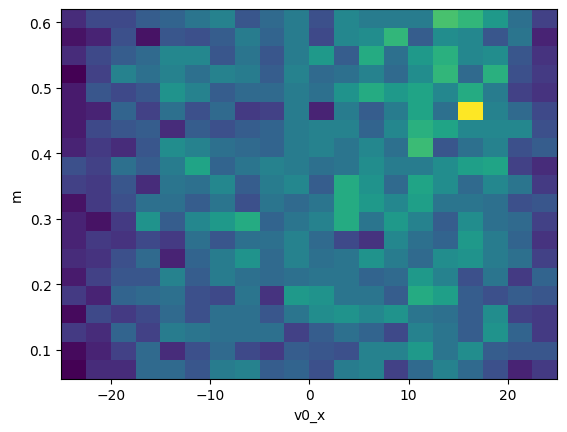

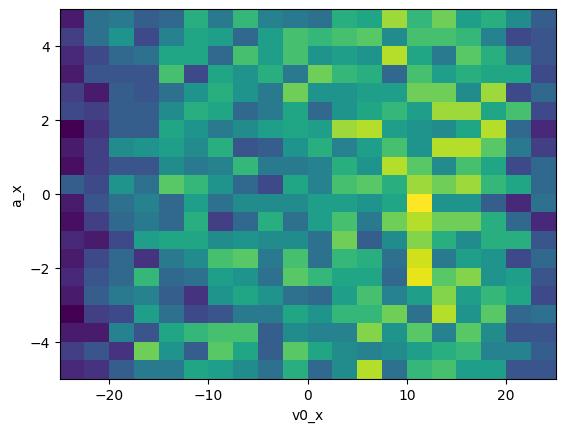

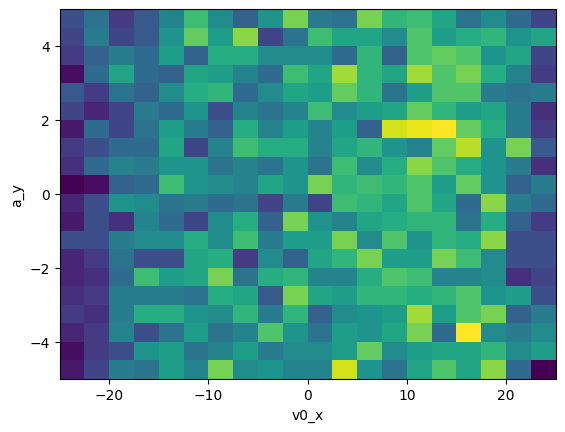

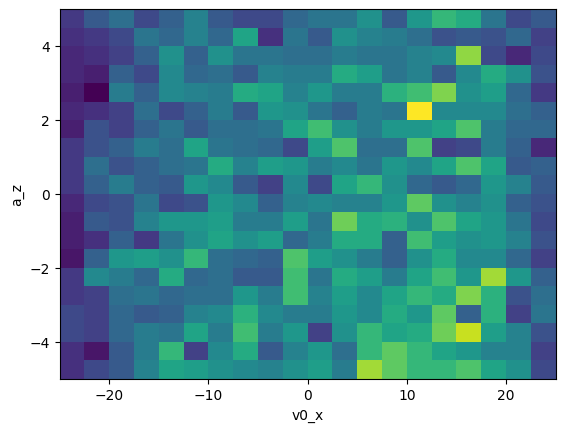

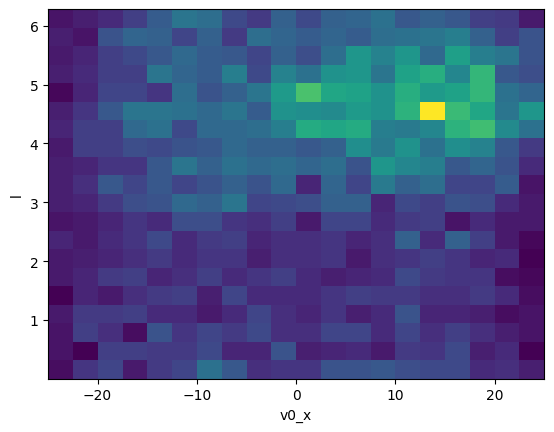

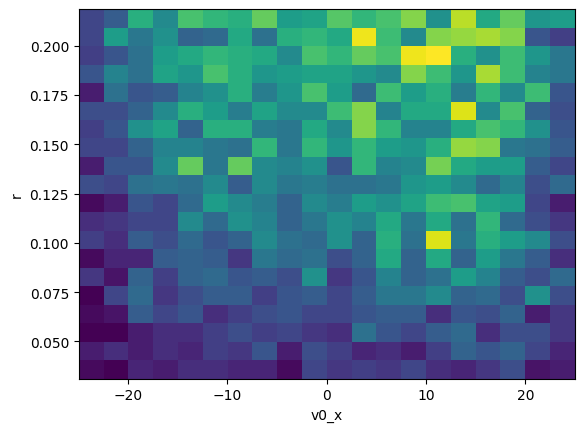

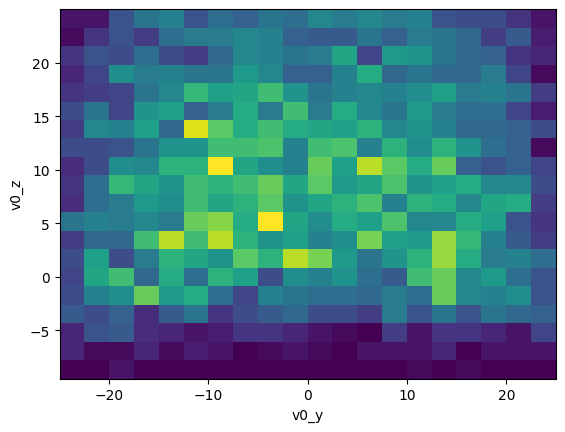

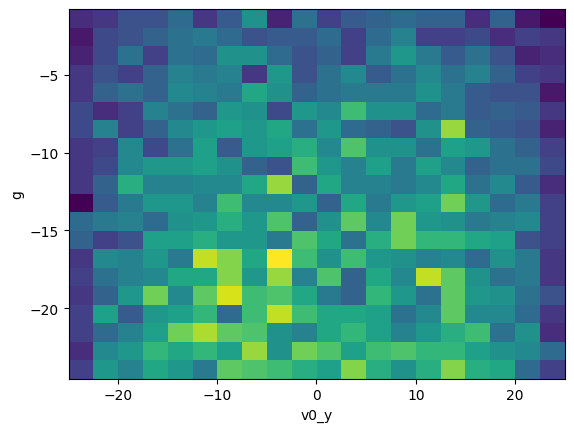

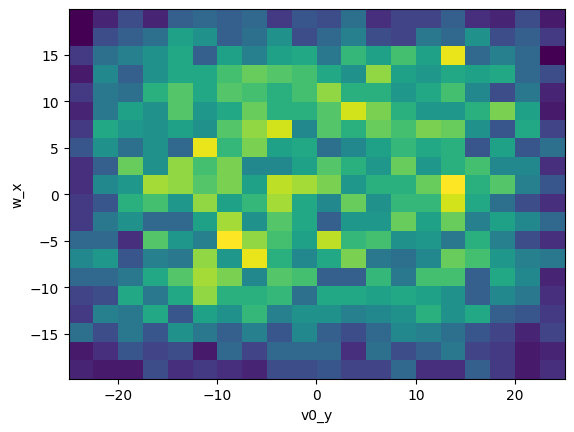

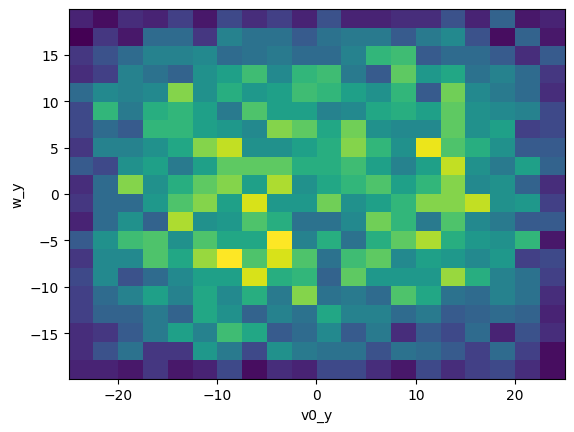

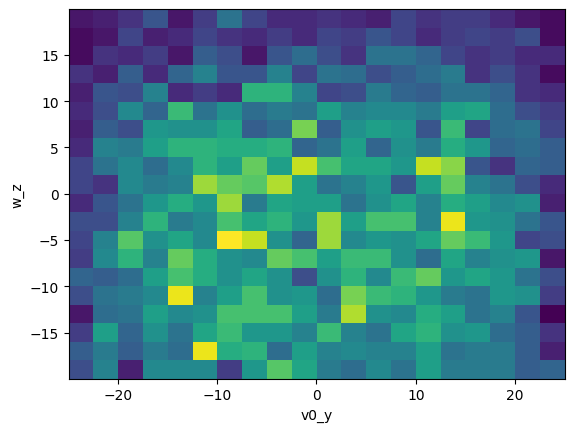

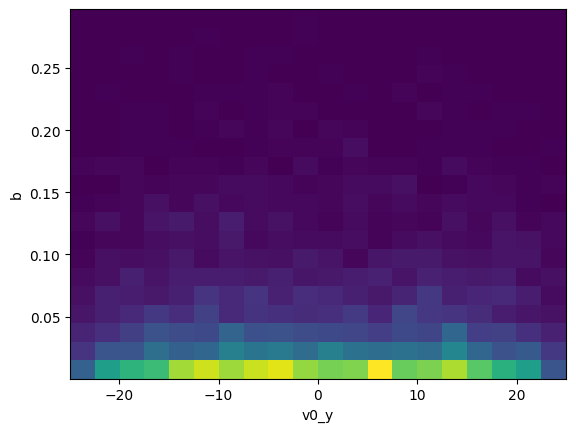

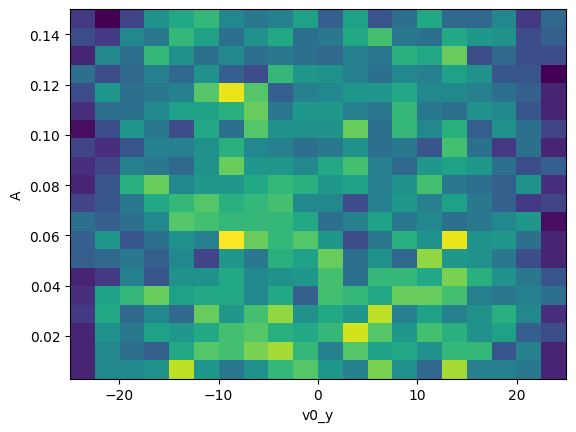

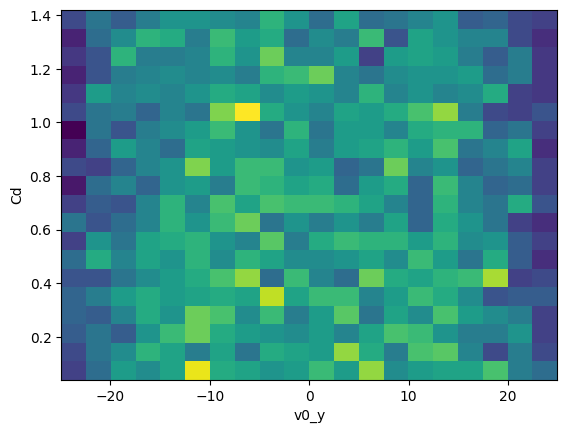

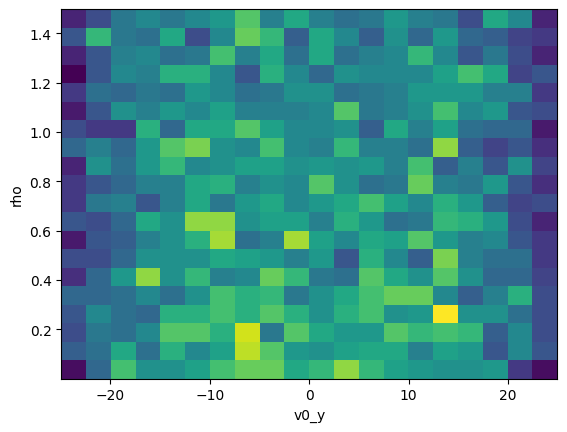

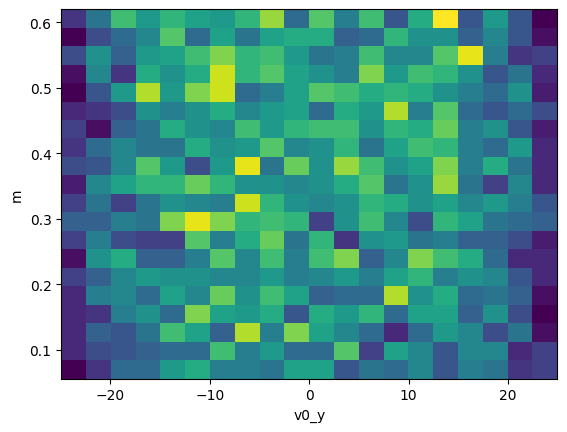

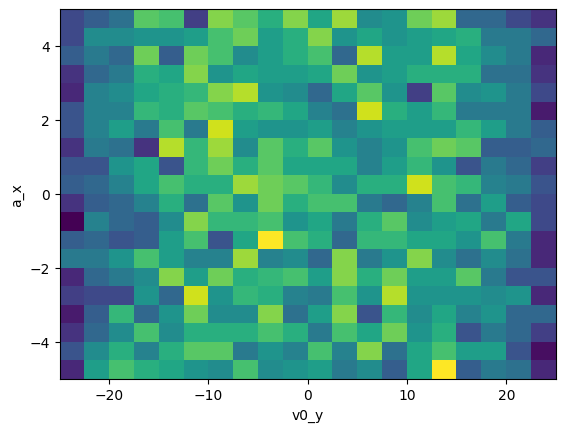

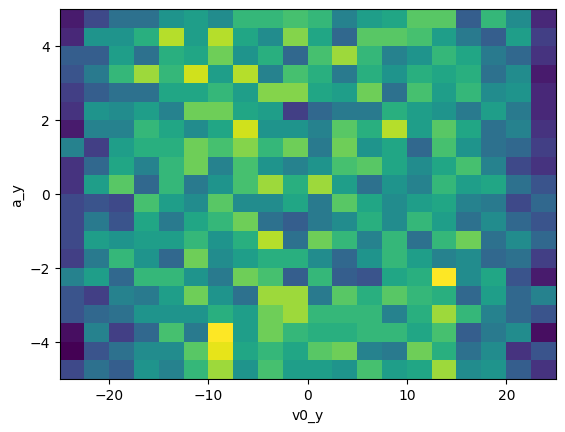

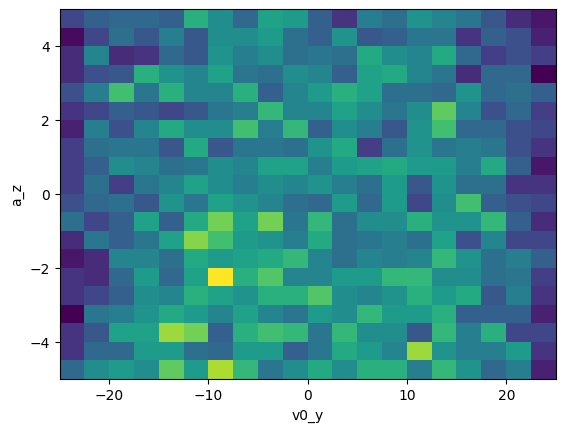

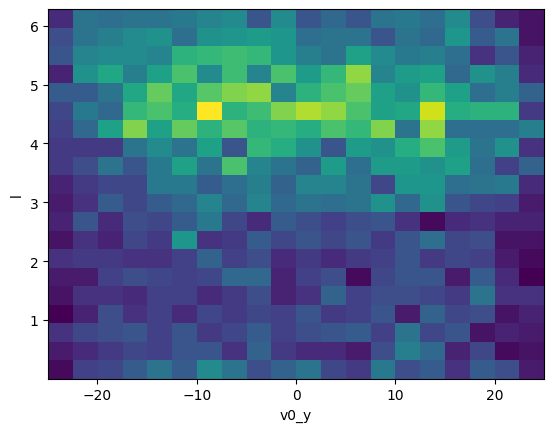

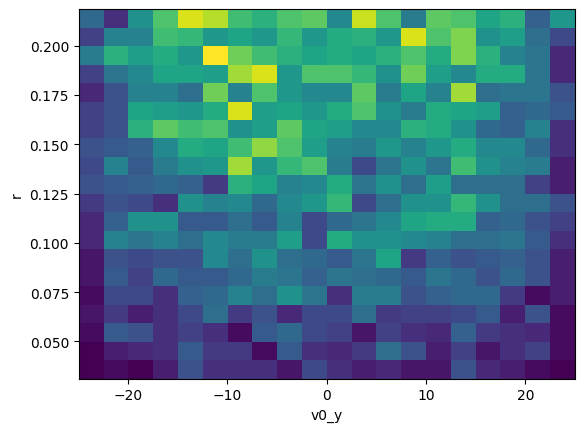

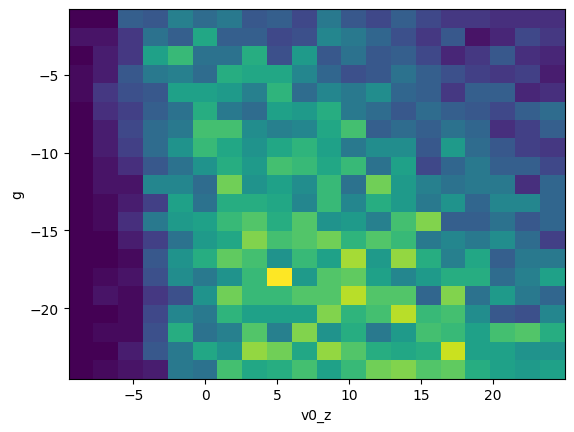

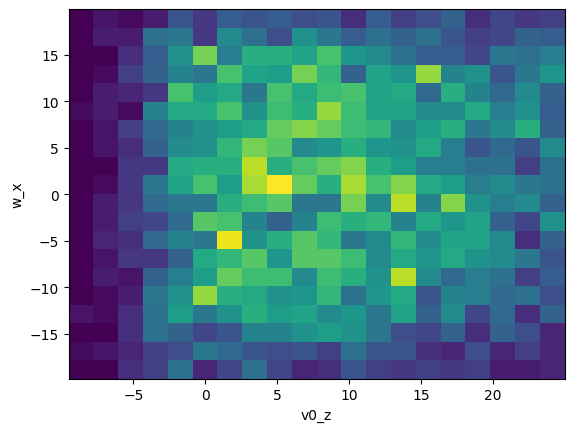

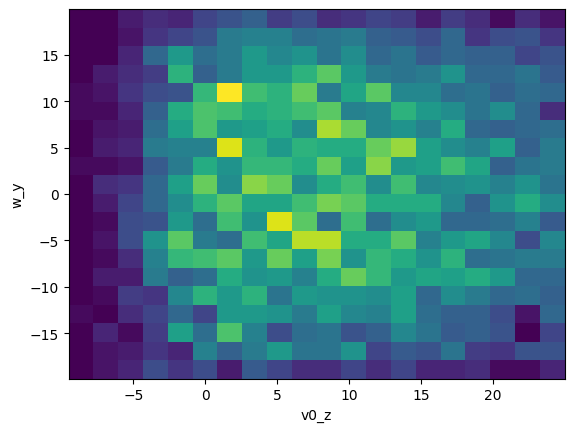

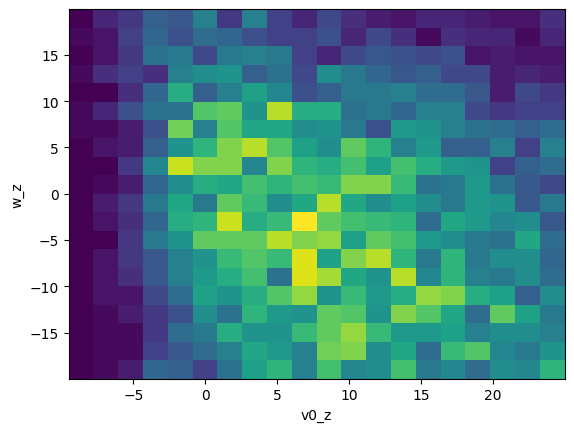

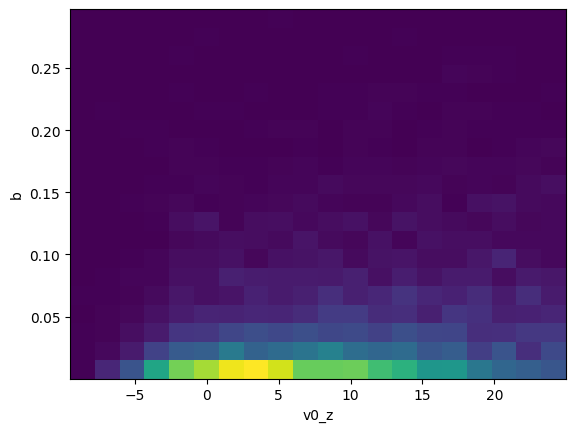

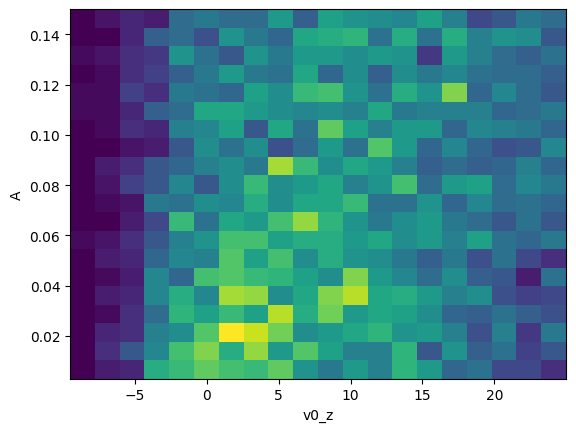

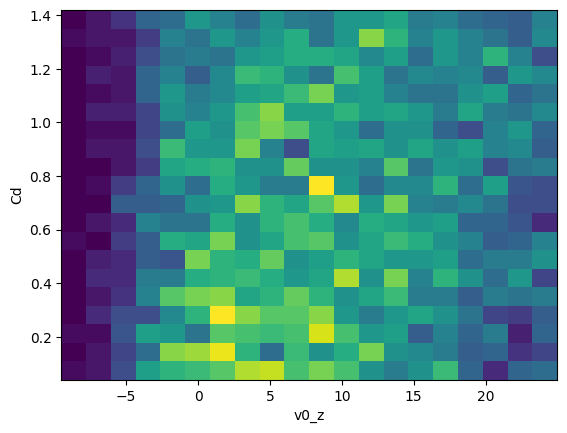

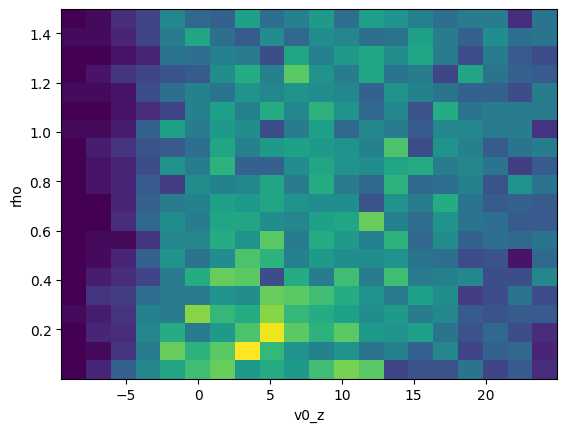

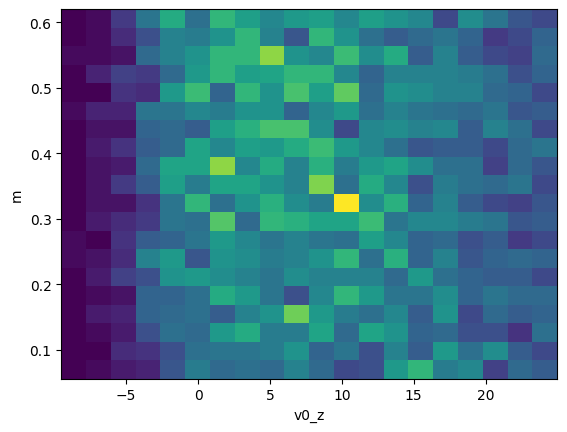

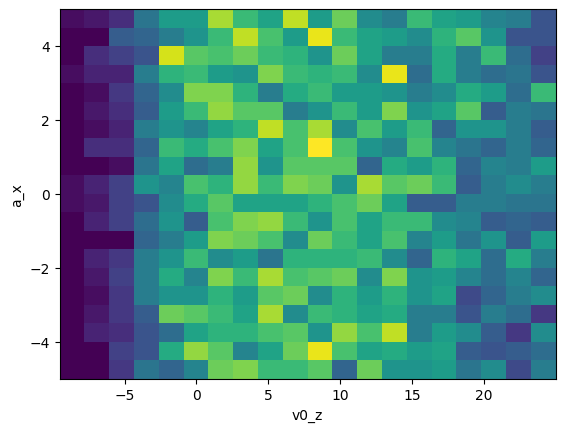

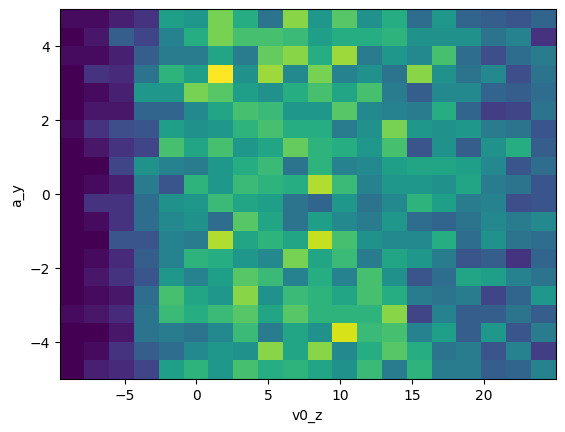

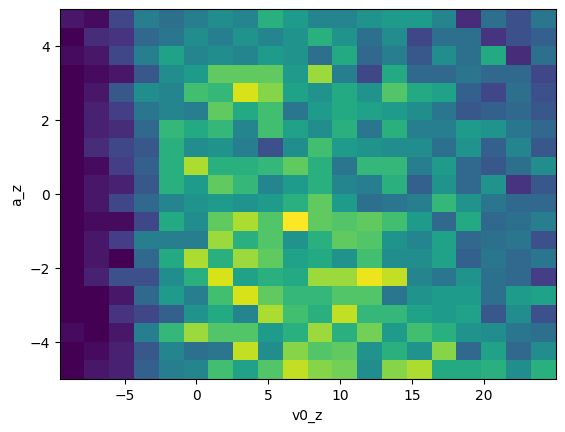

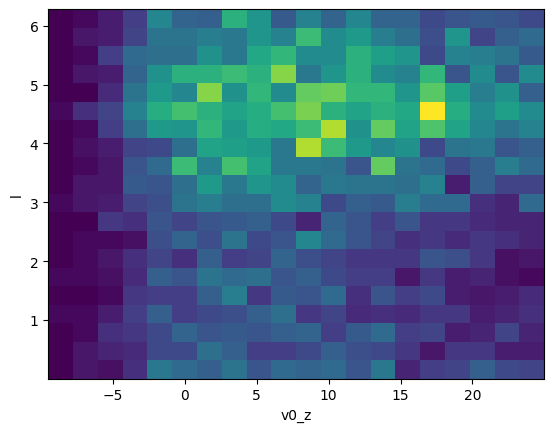

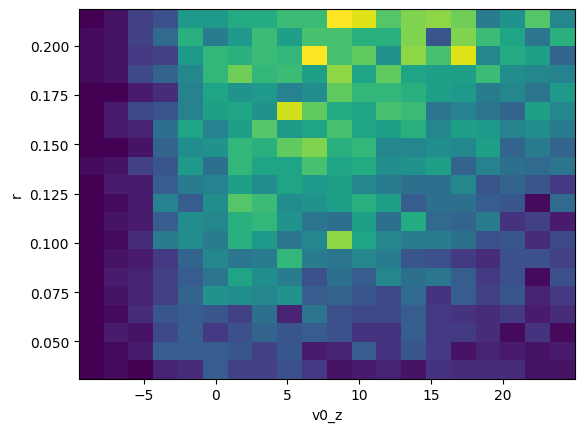

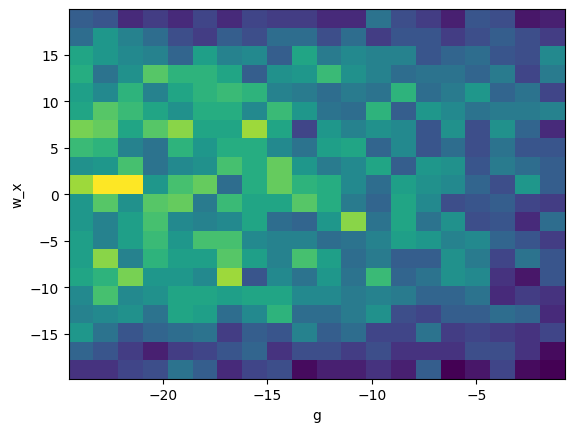

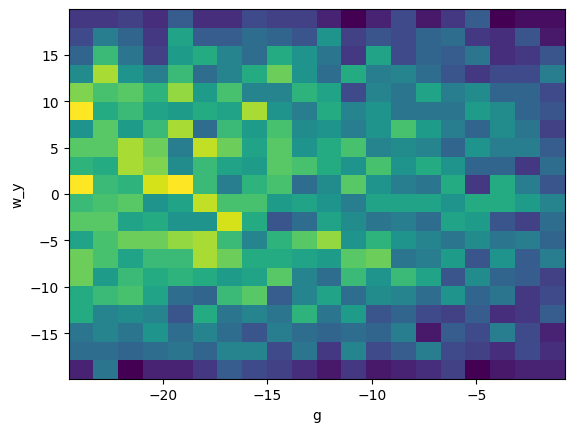

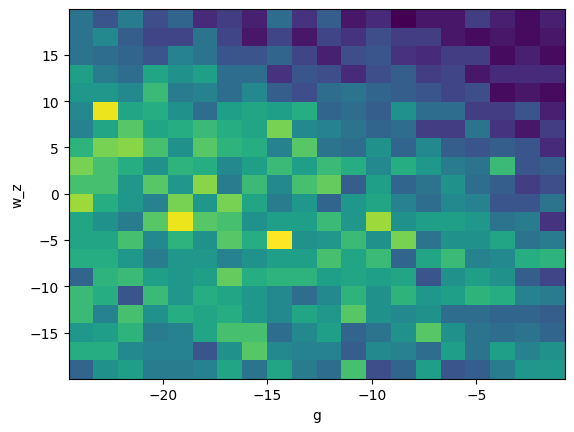

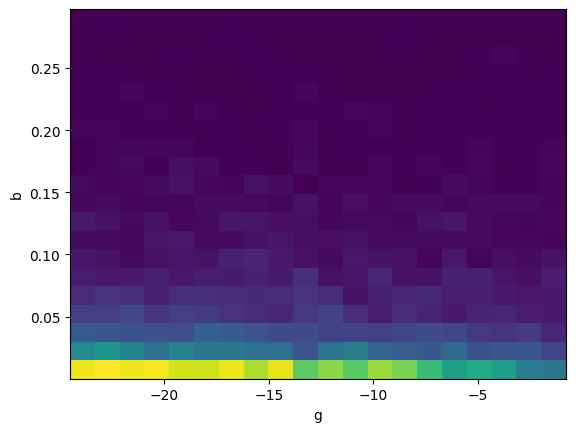

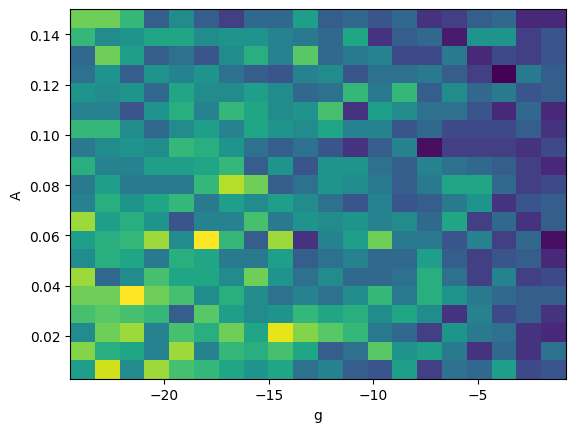

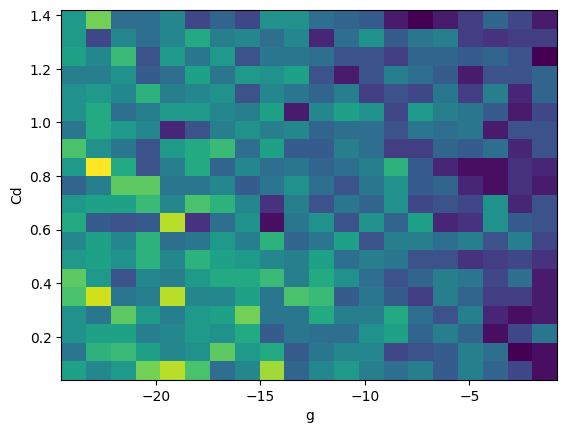

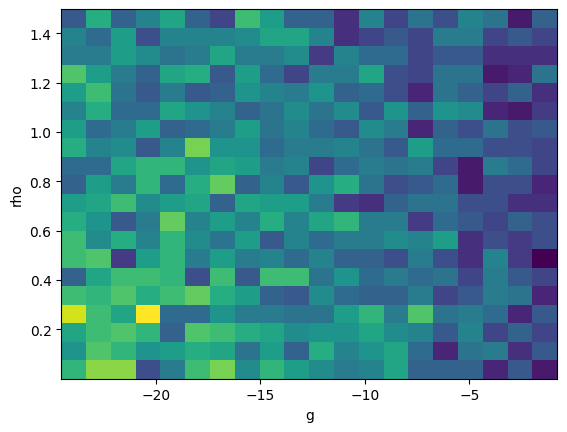

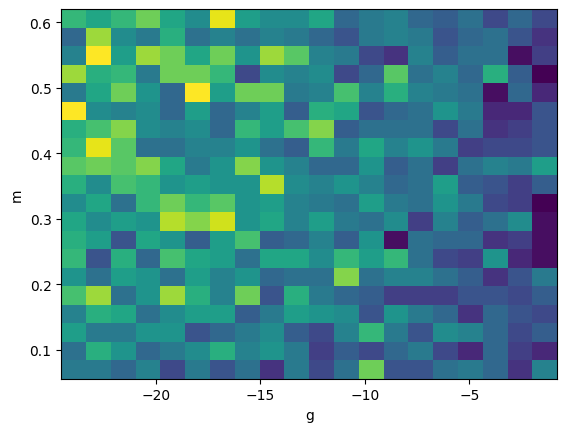

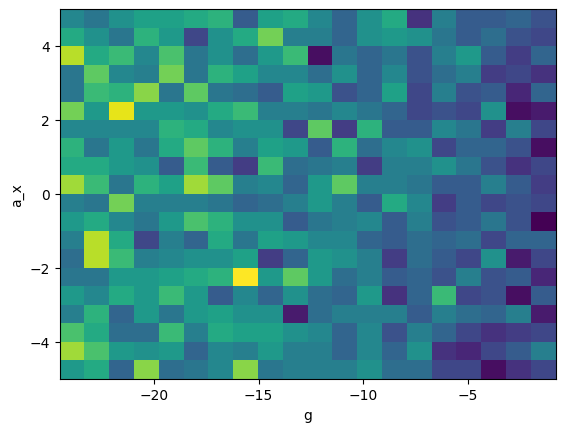

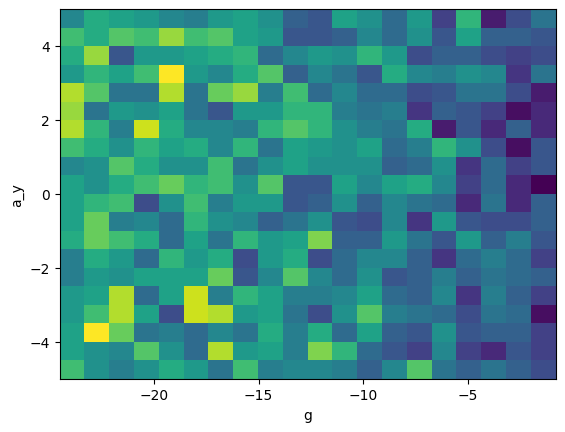

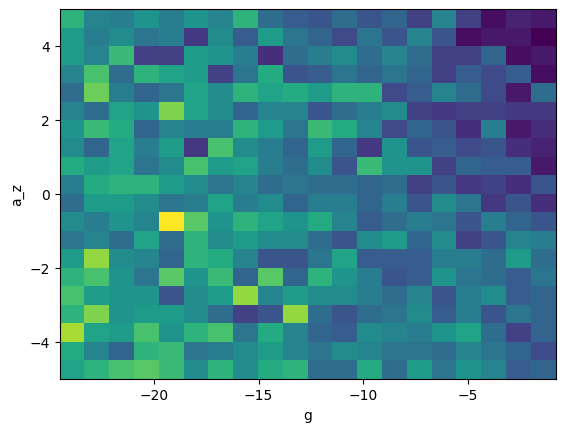

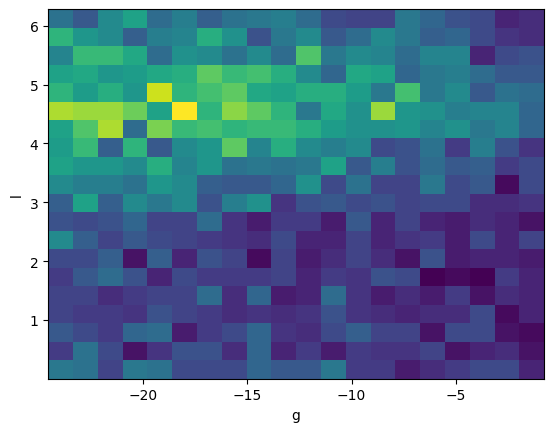

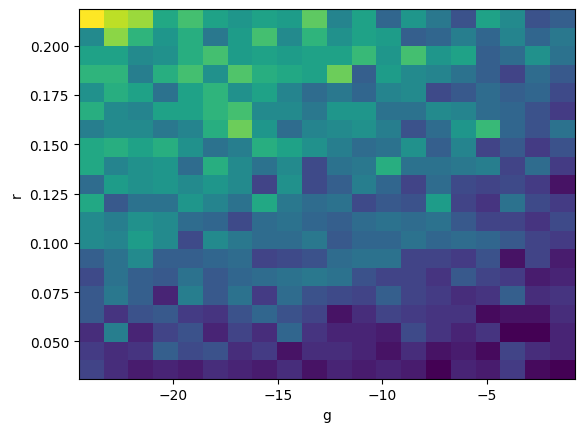

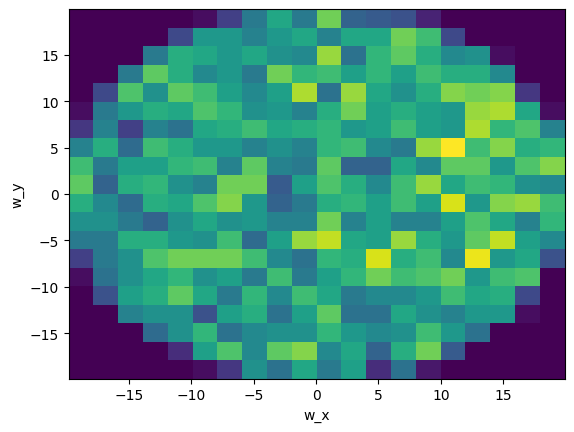

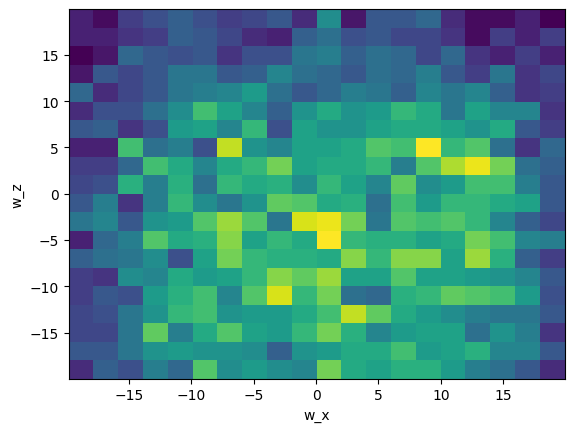

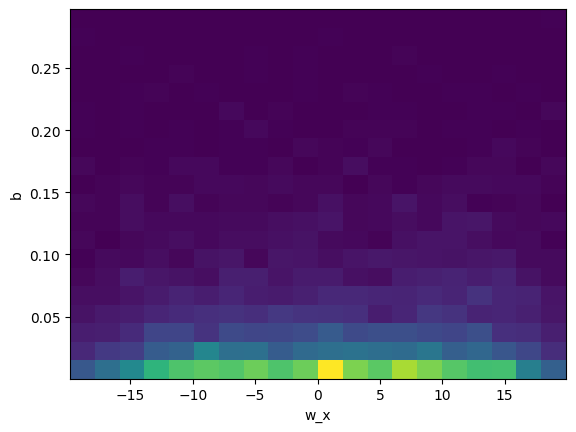

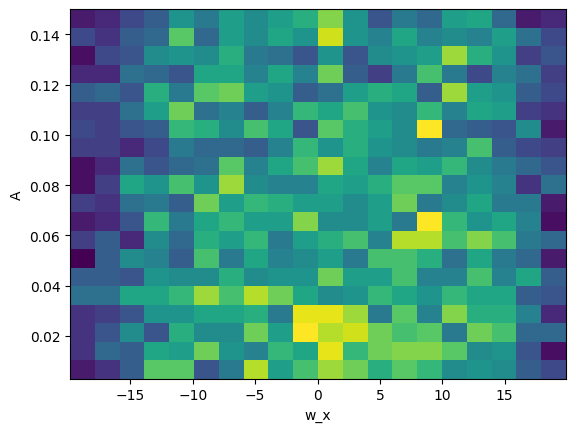

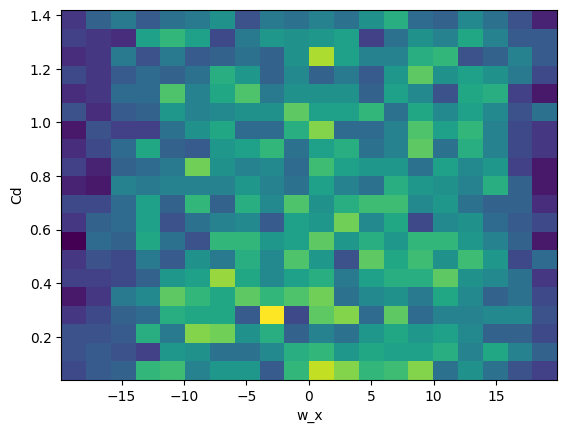

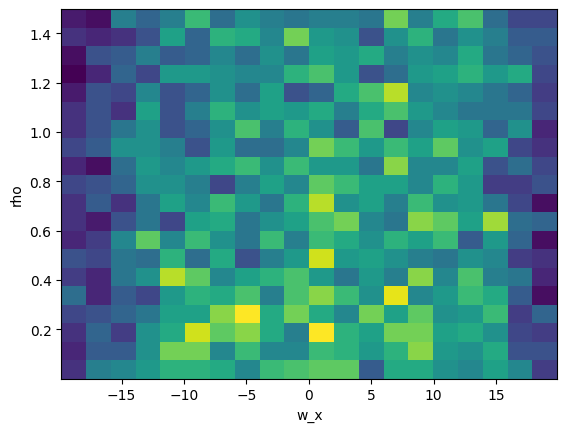

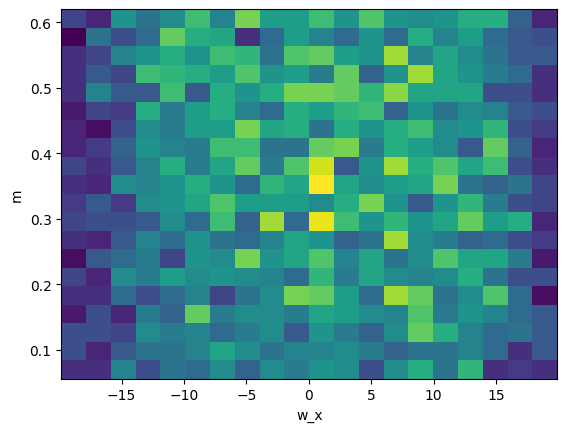

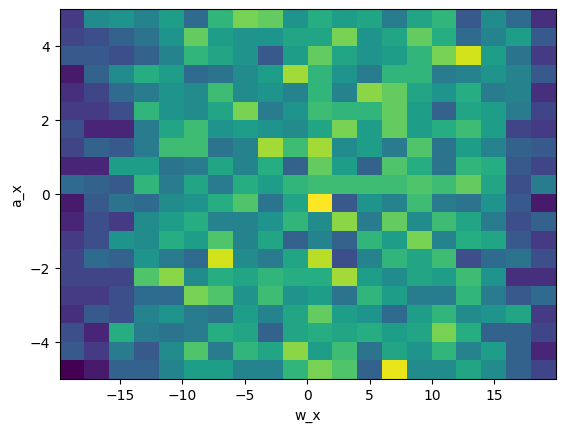

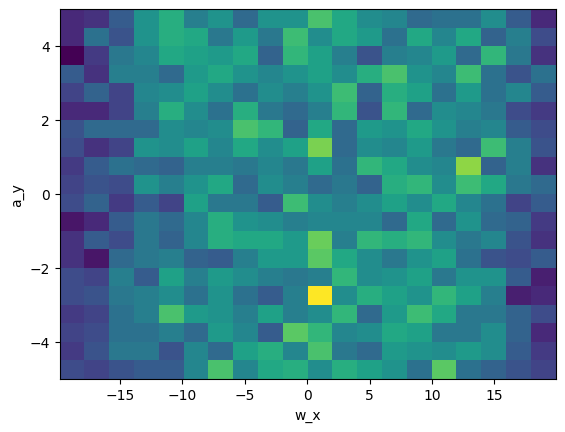

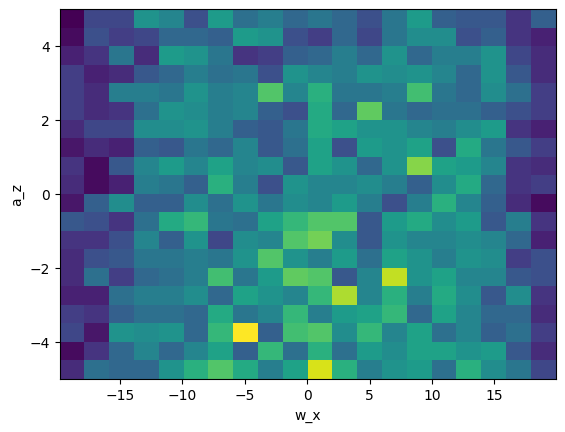

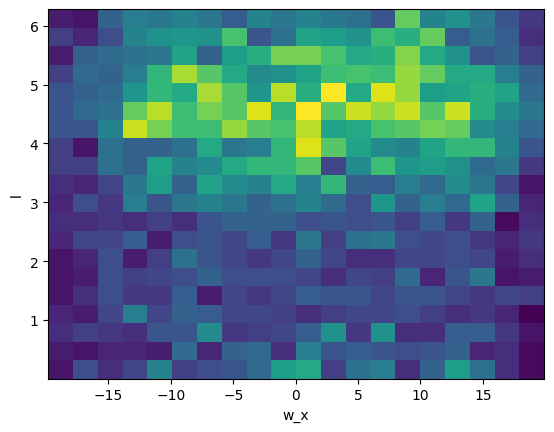

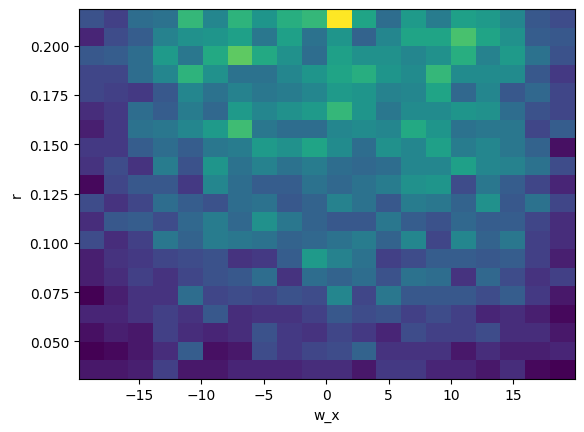

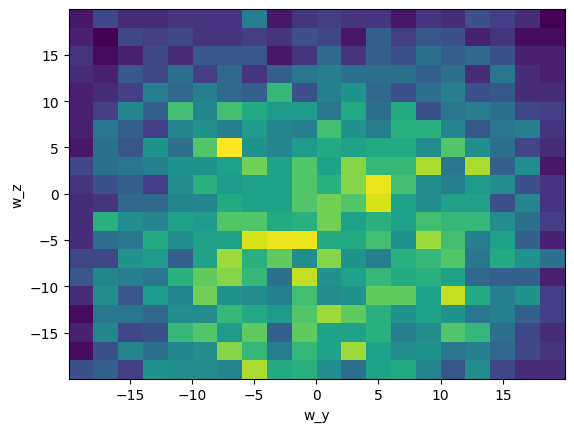

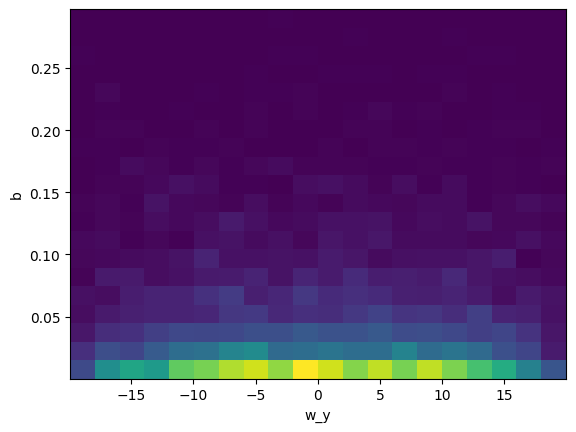

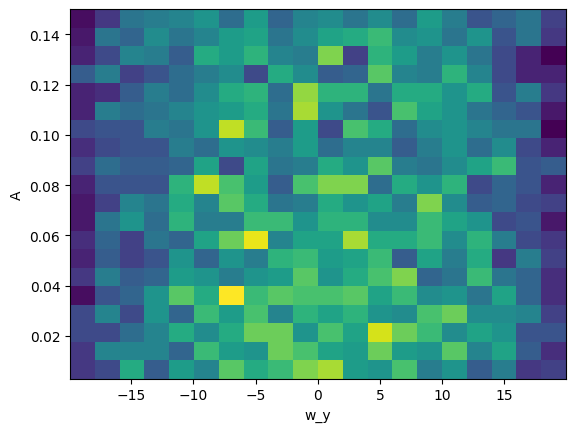

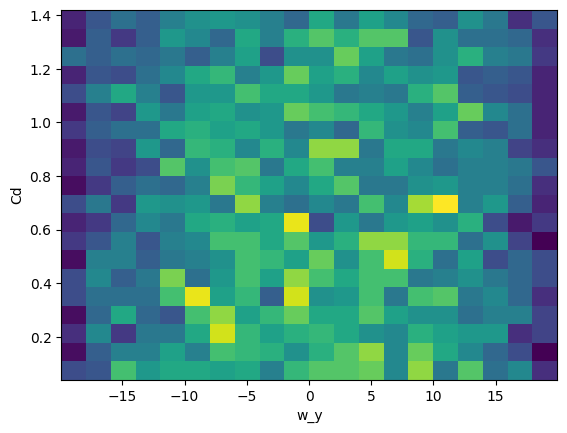

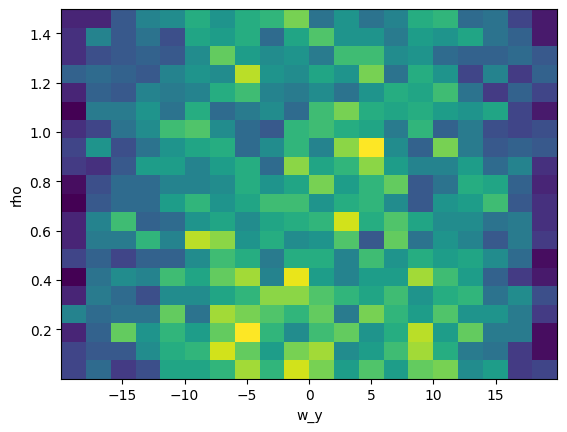

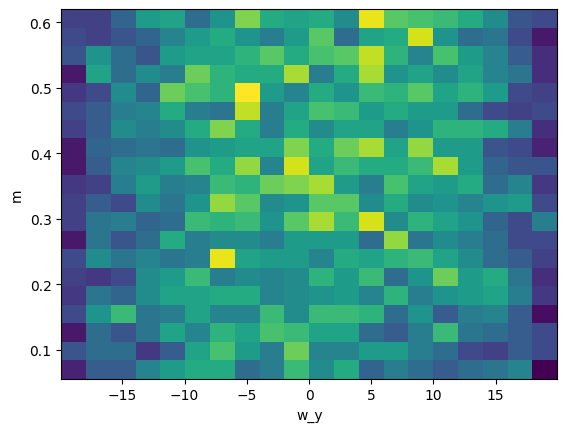

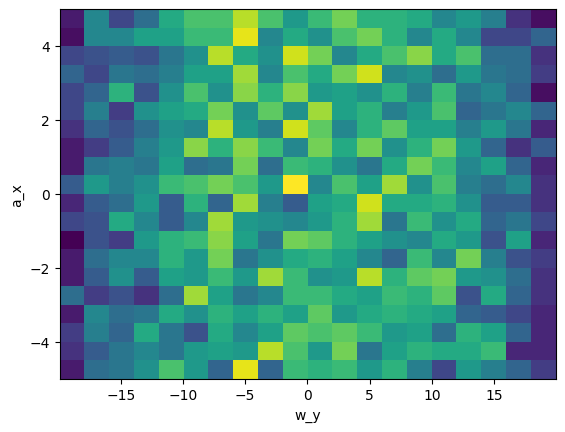

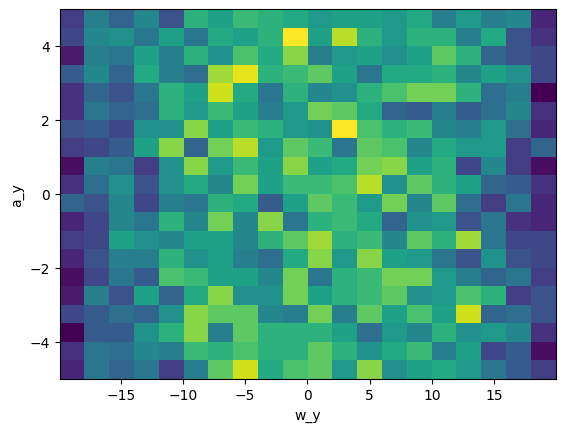

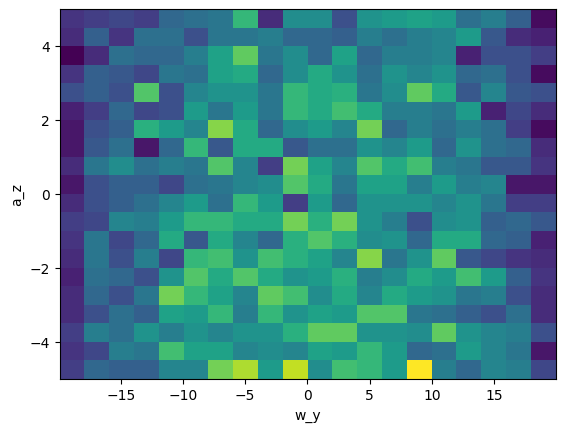

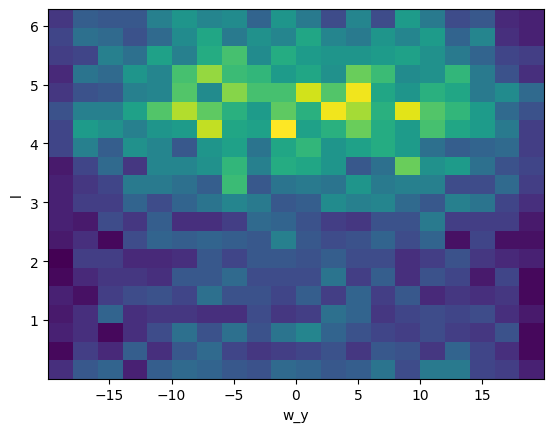

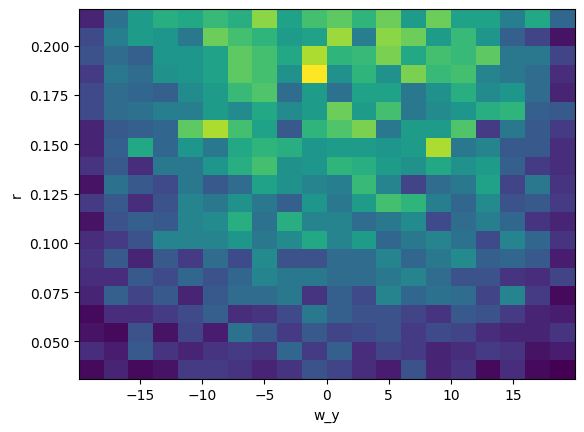

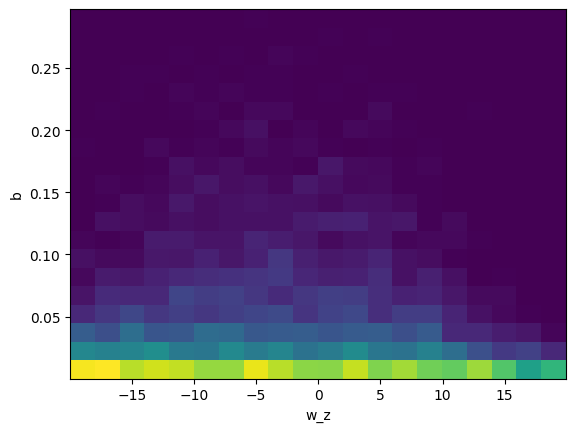

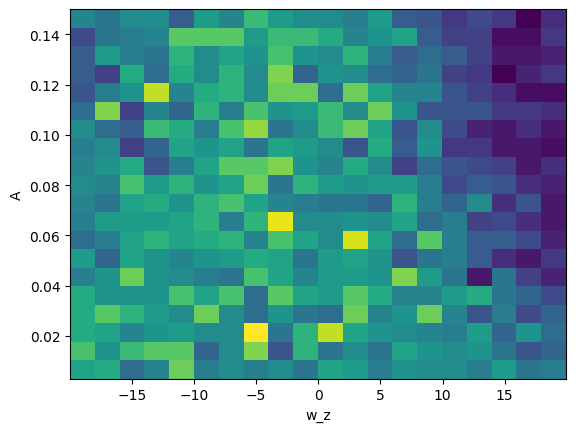

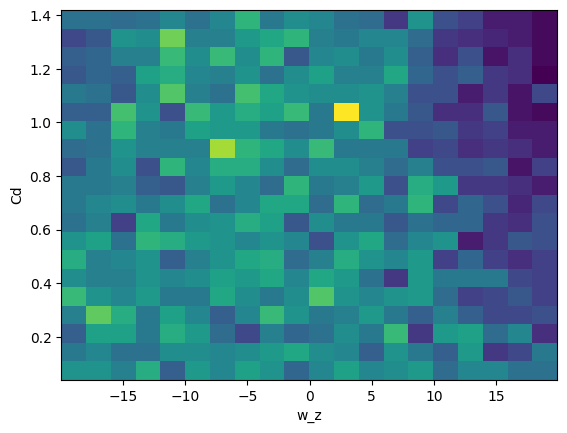

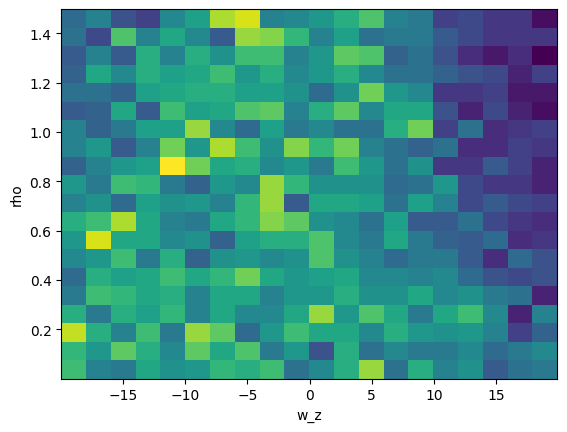

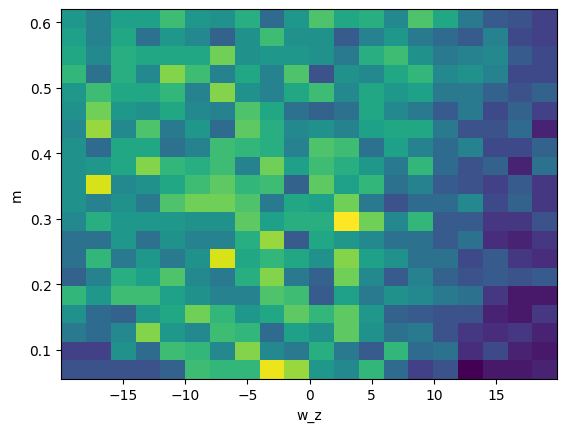

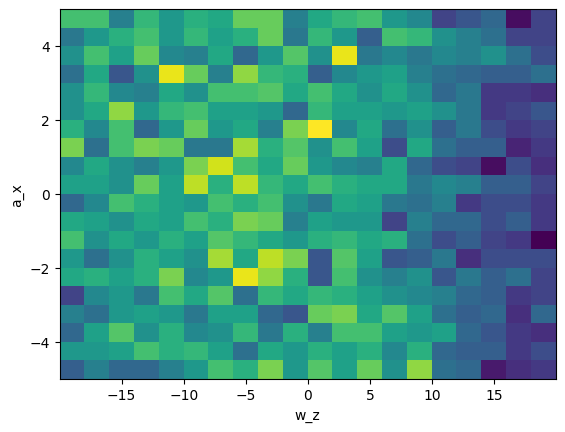

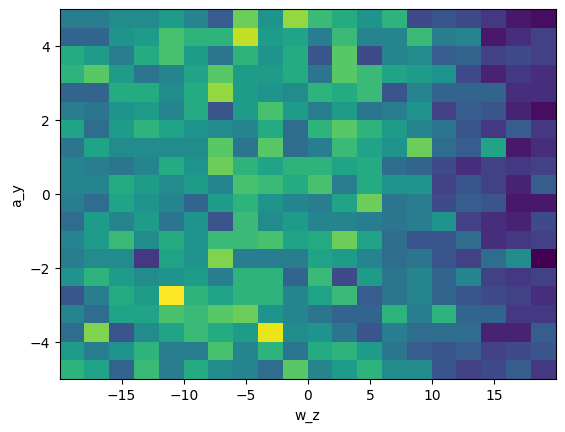

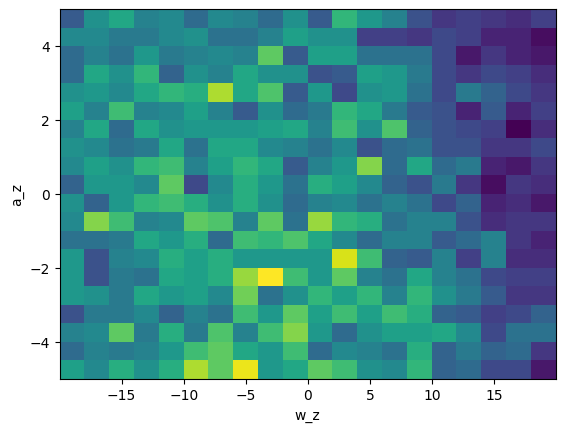

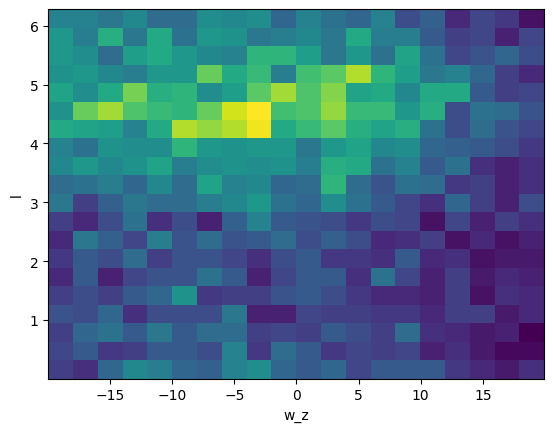

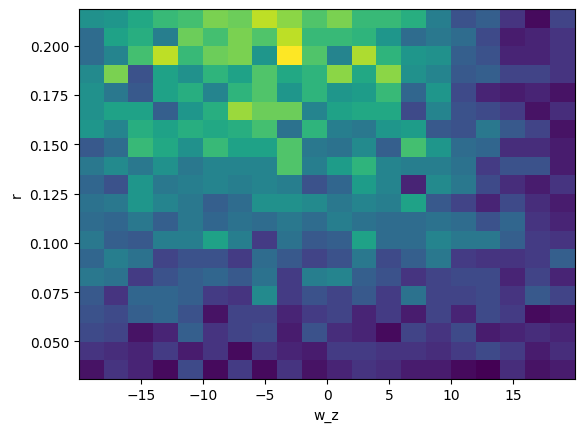

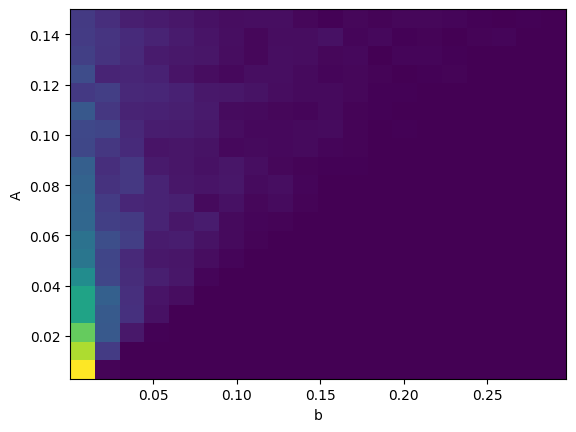

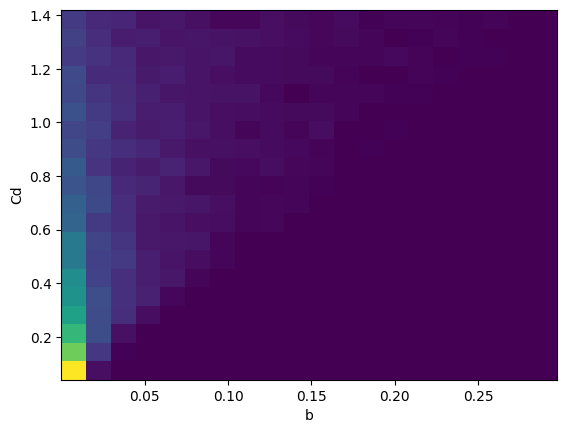

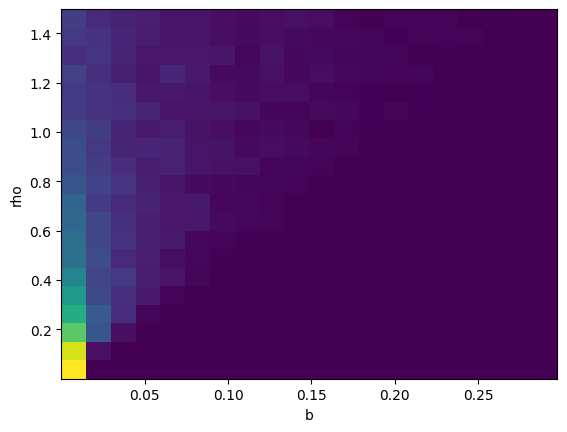

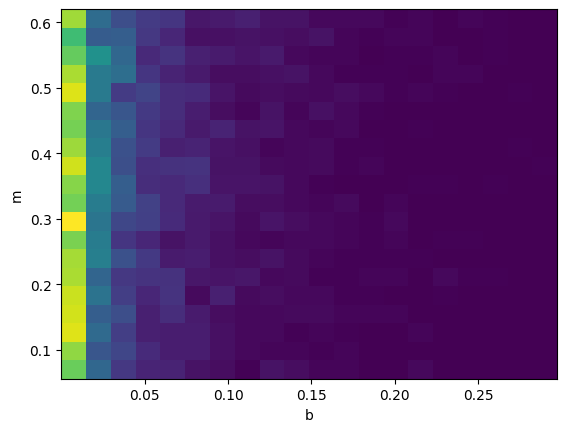

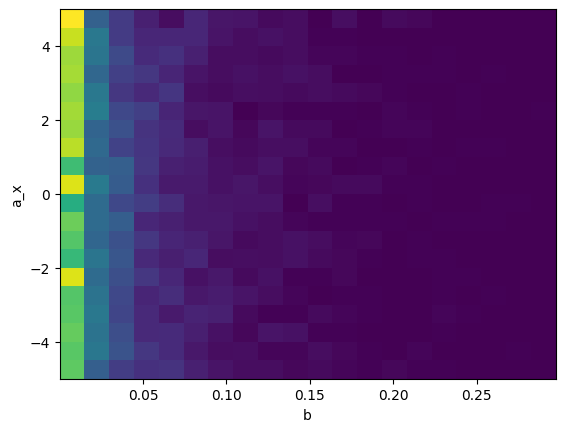

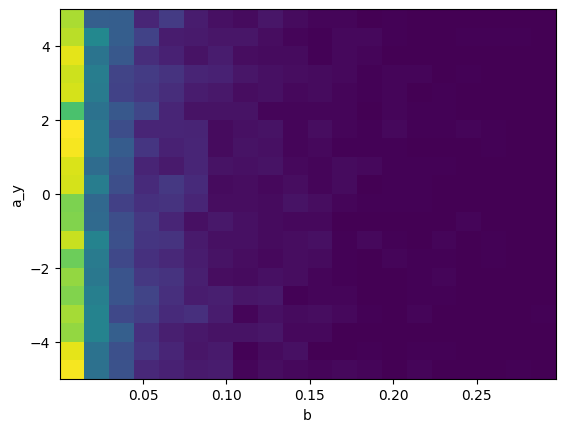

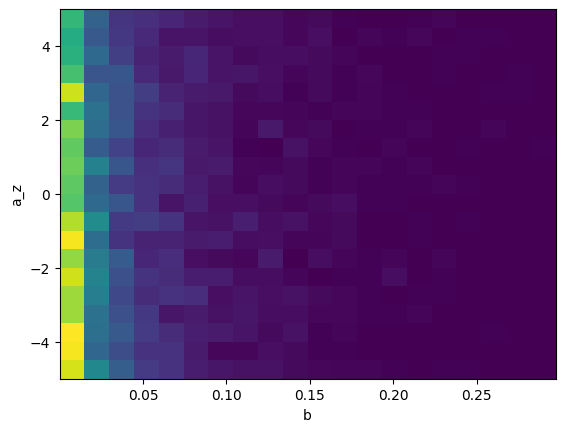

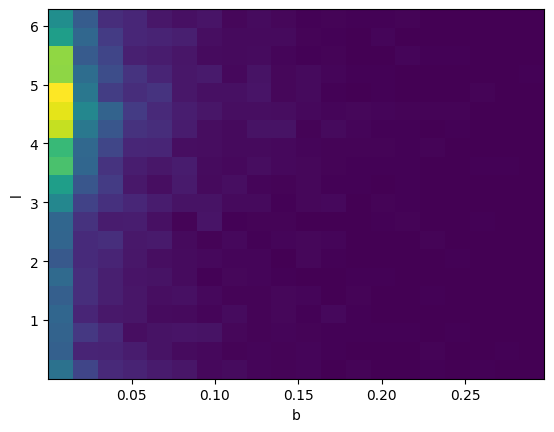

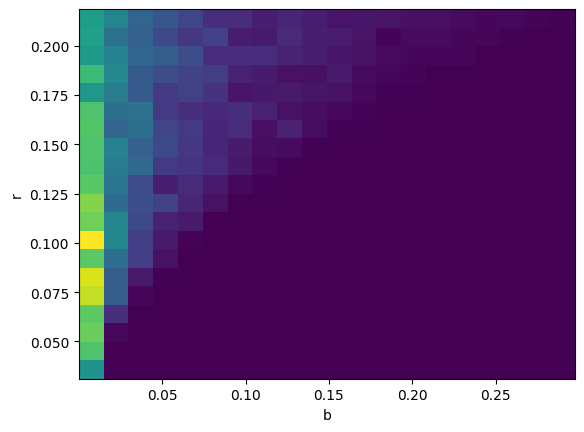

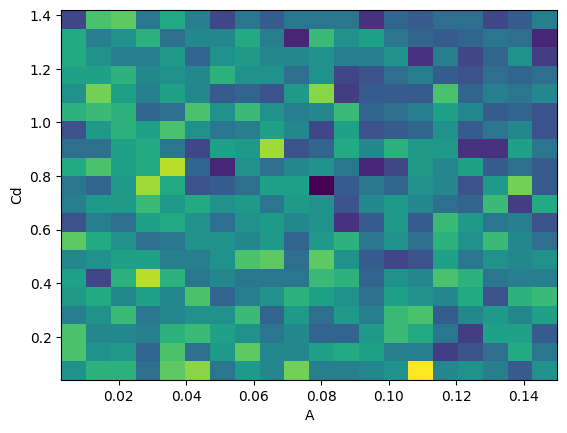

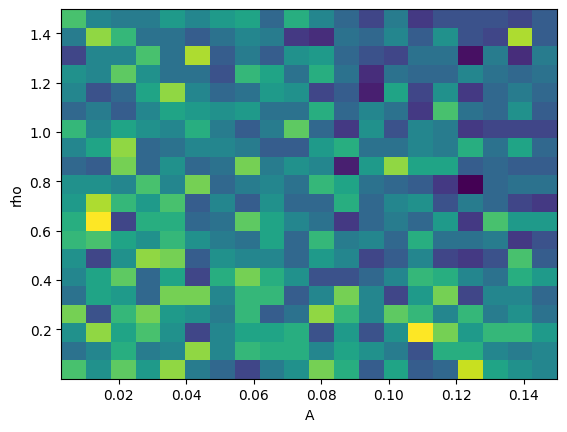

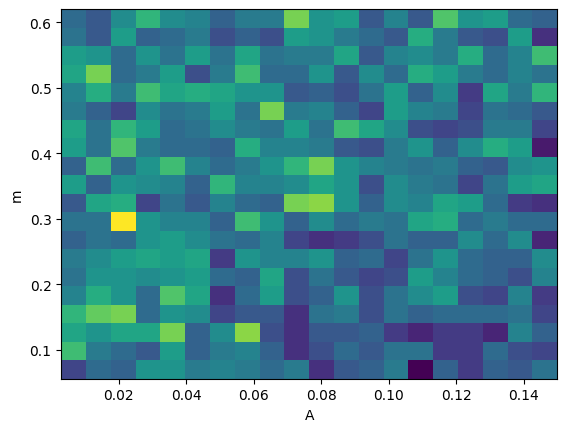

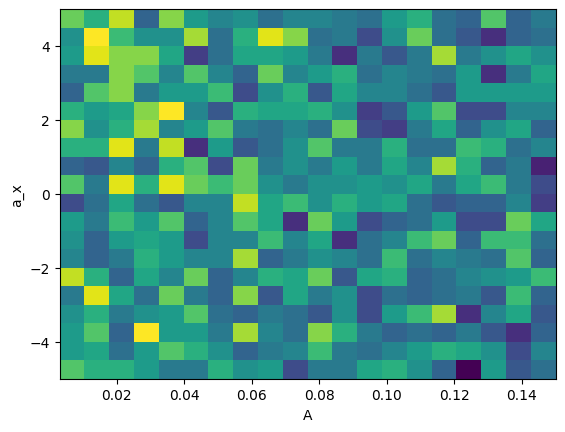

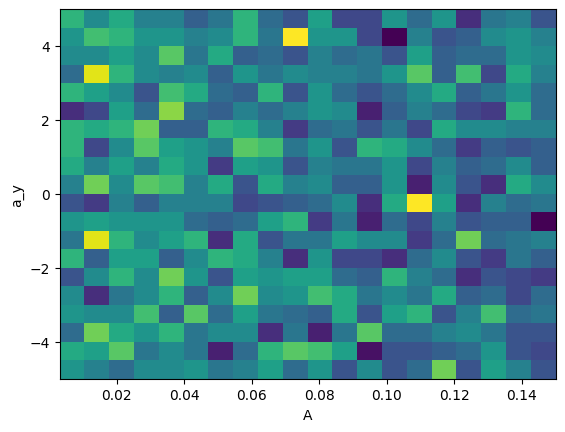

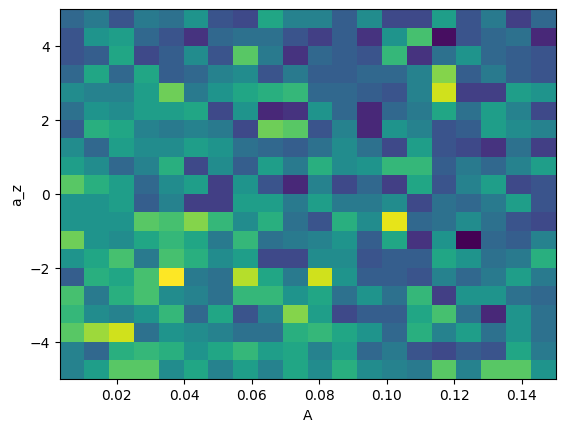

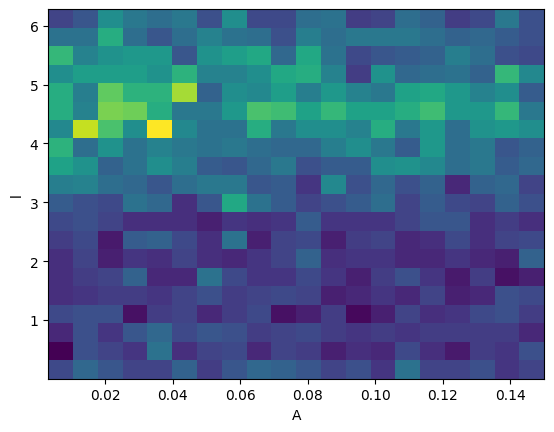

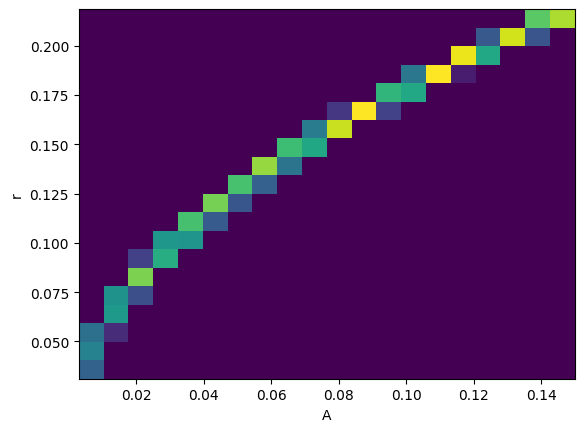

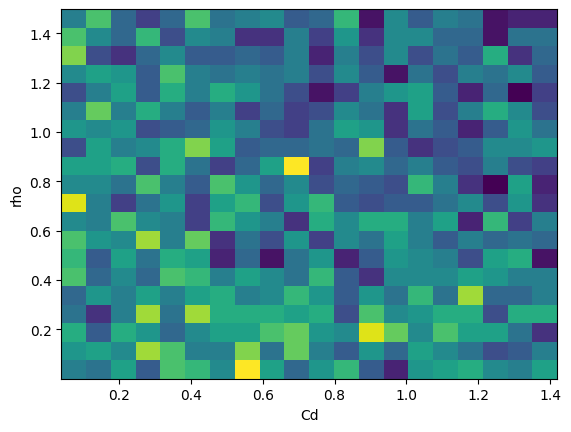

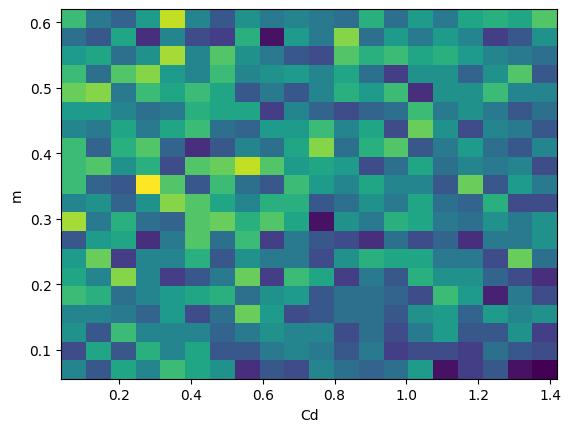

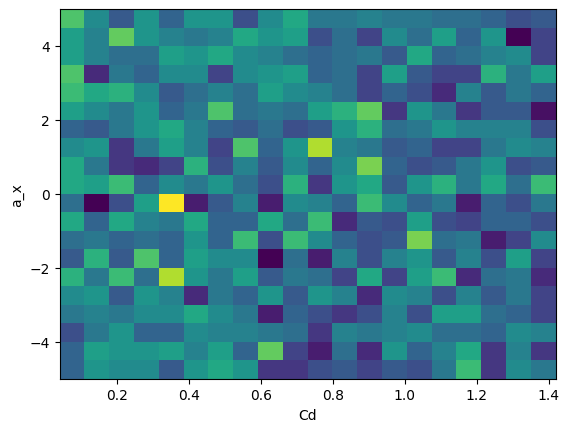

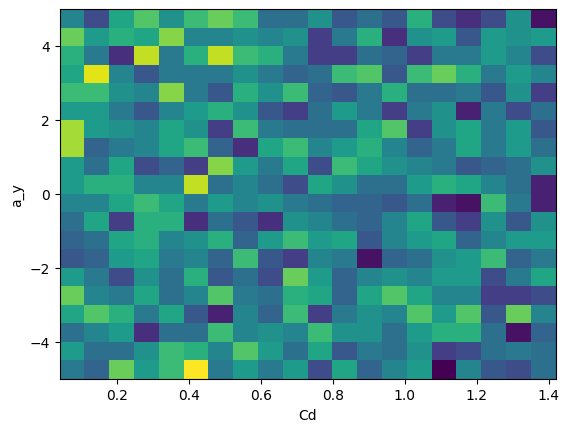

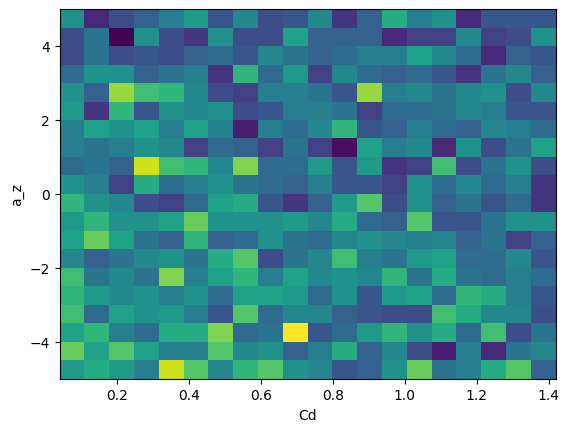

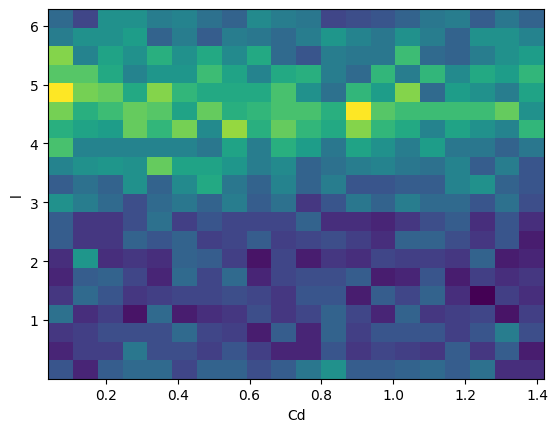

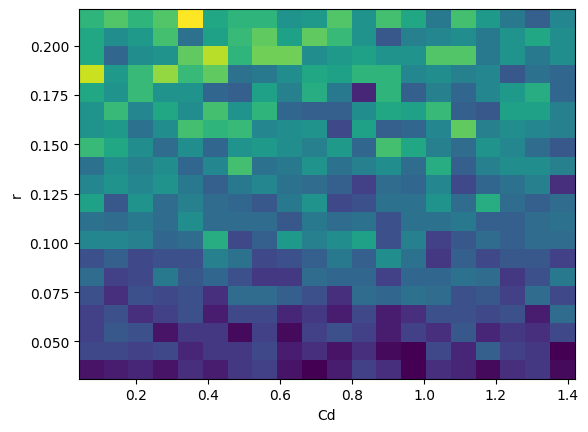

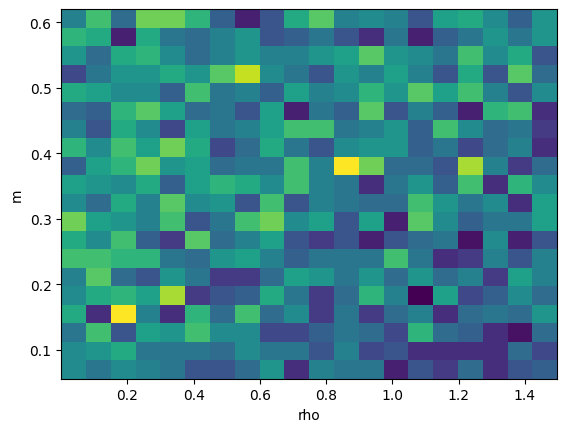

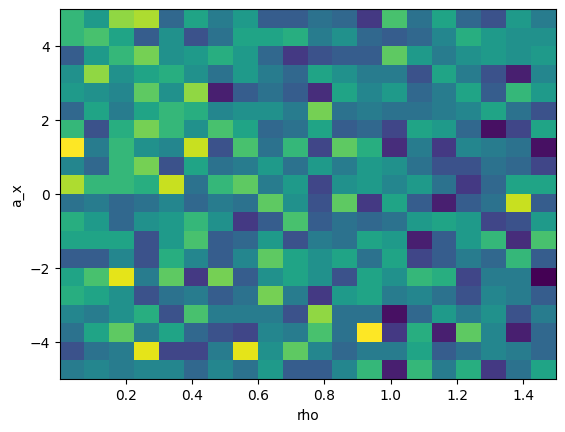

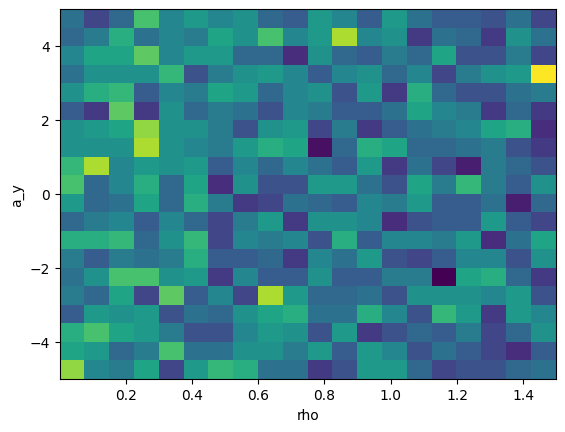

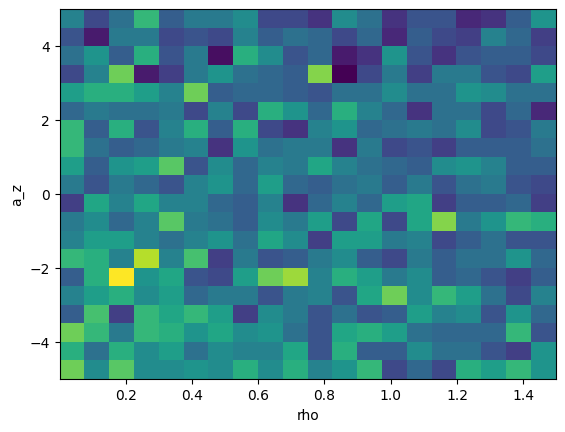

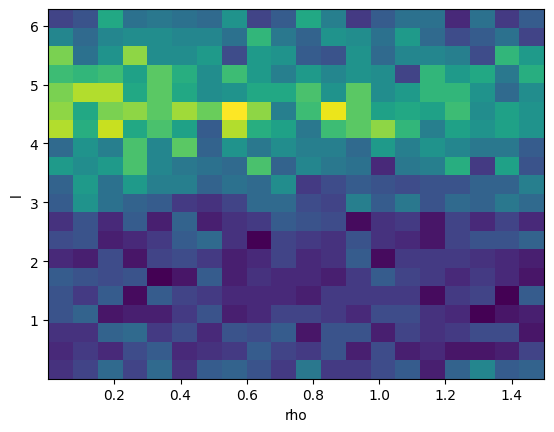

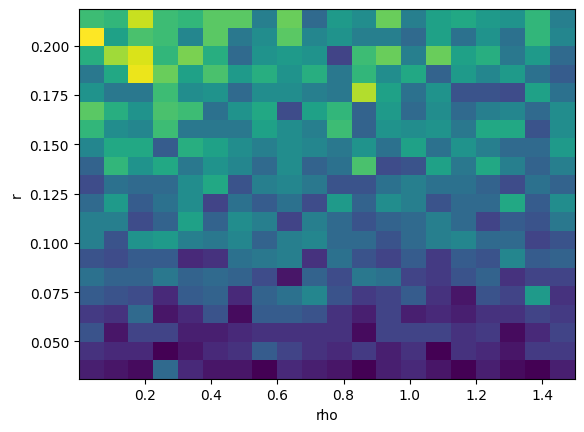

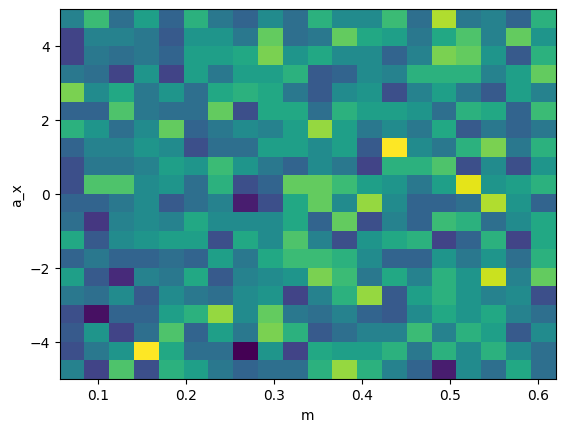

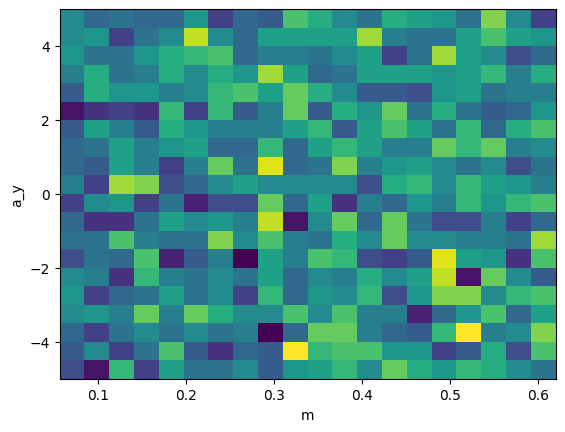

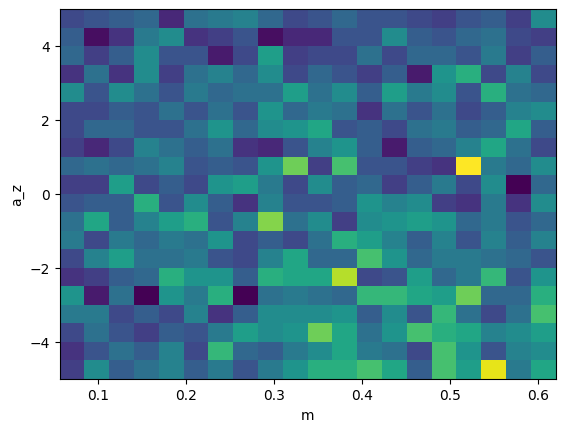

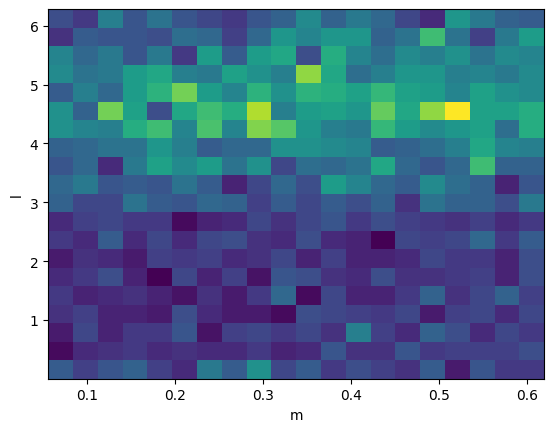

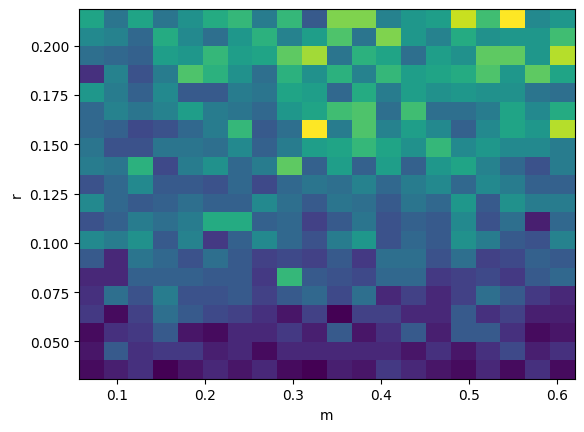

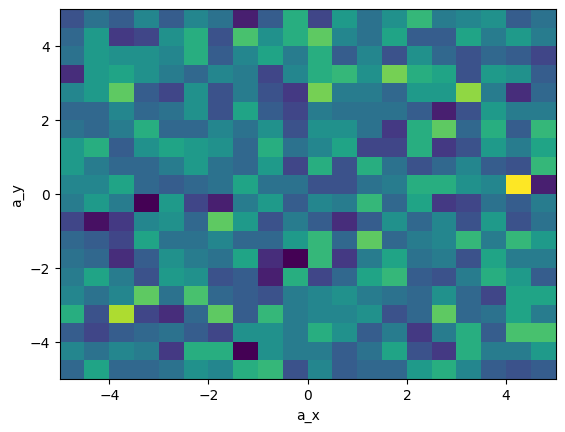

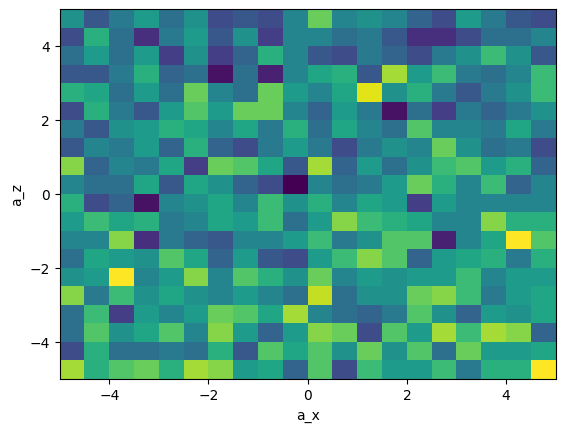

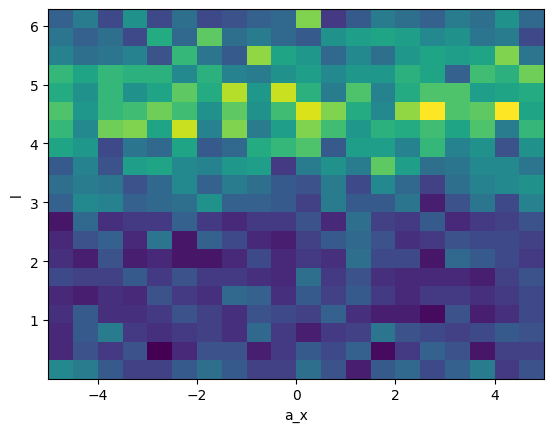

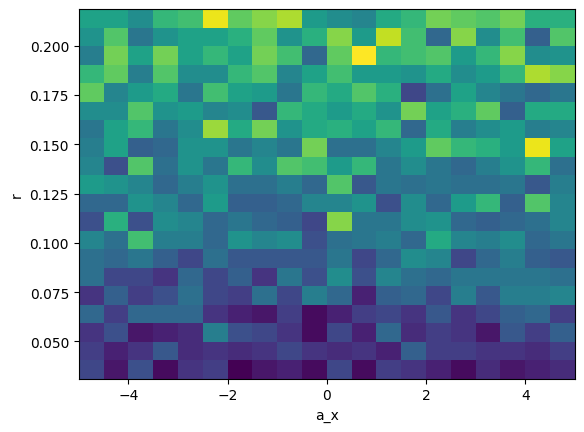

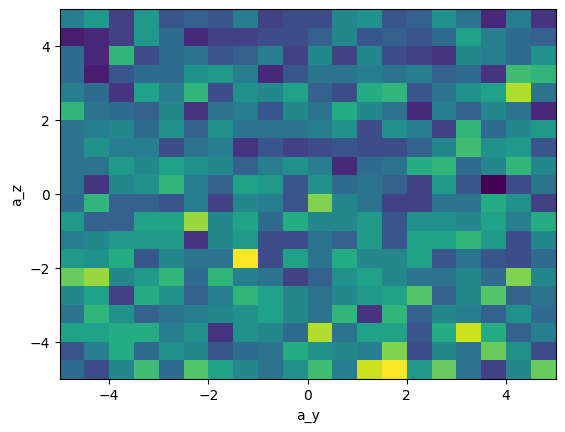

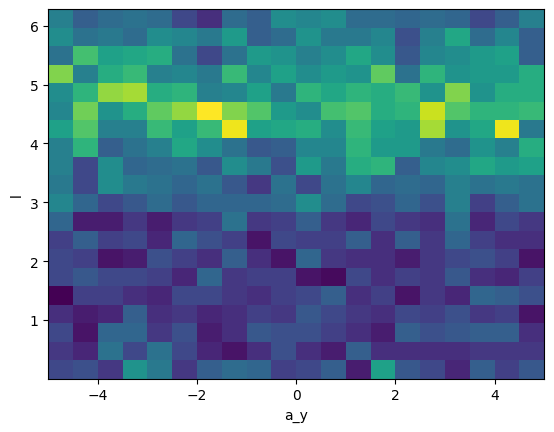

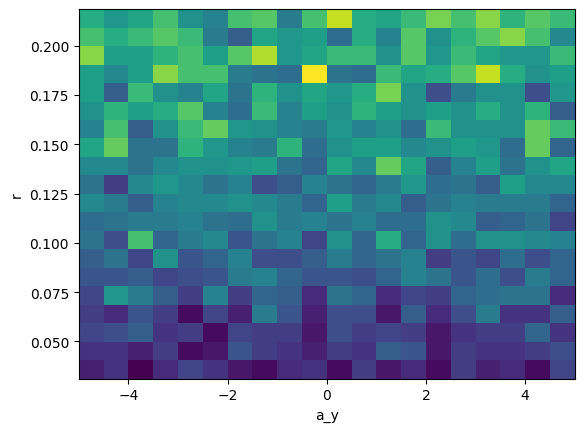

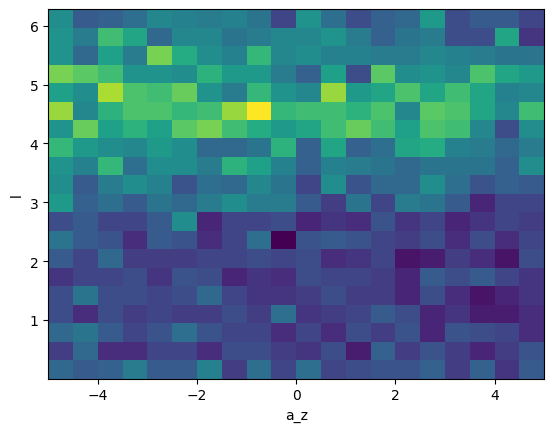

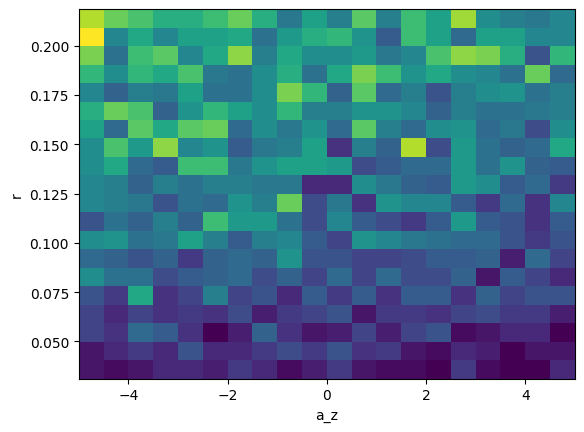

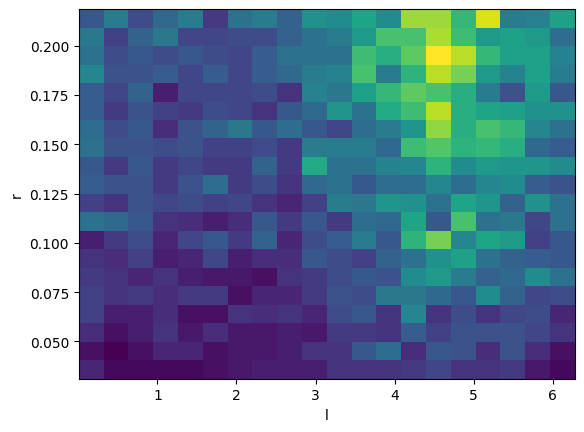

In [8]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=20)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

In [9]:
# save df
df.to_csv('ballistic_parameters.csv', index=False)

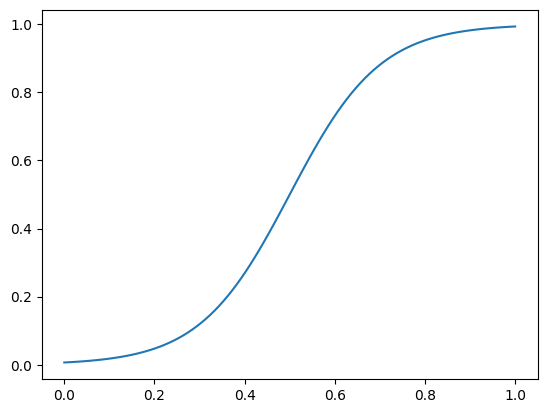

In [42]:
# plot sigmoid

x = np.linspace(0, 1, 100)
y = 1 / (1 + np.exp(-(x-0.5)*10))
plt.plot(x, y)
plt.show()


0.50633


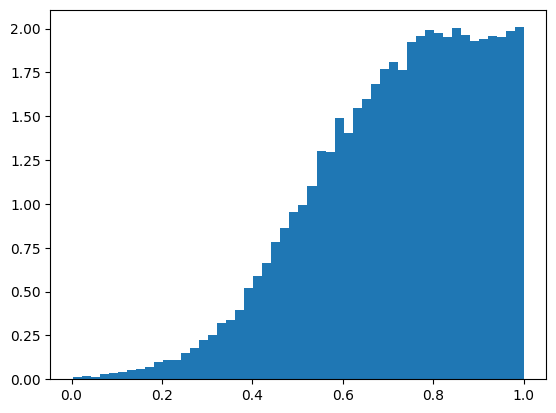

In [49]:
x_data = np.random.uniform(0, 1, 100000)
y_data = 1 / (1 + np.exp(-(x_data-0.5)*10))

accept = []

for x in x_data:
    if x > 0.75:
        accept.append(x)
    elif 1 / (1 + np.exp(-(x-0.5)*10)) > np.random.uniform(0, 1):
        accept.append(x)
    else:
        continue

plt.hist(accept, bins=50, density=True)
print(len(accept)/len(x_data))
        


In [1]:
from bcnf.simulation.sampling import generate_data

In [2]:
generate_data(print_acc_rej=True, n=10)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it, accepted=10, rejected=9]


In [4]:
# load df from pickle

from bcnf.utils import get_dir
import pandas as pd

df = pd.read_pickle(f'{get_dir()}/data/bcnf-data/data.pkl')

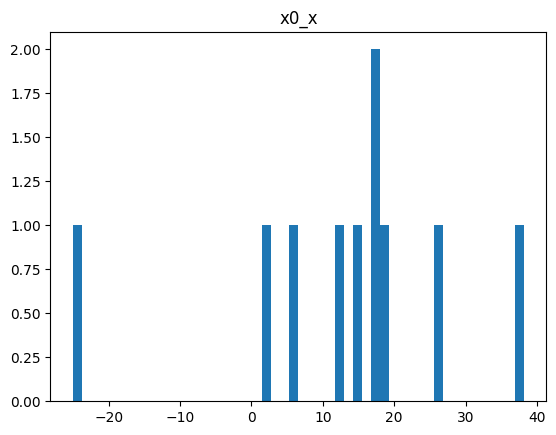

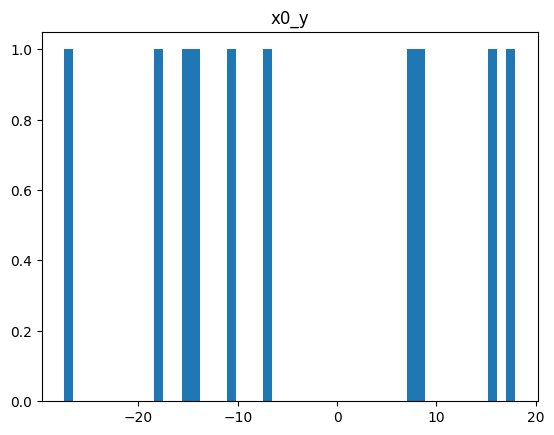

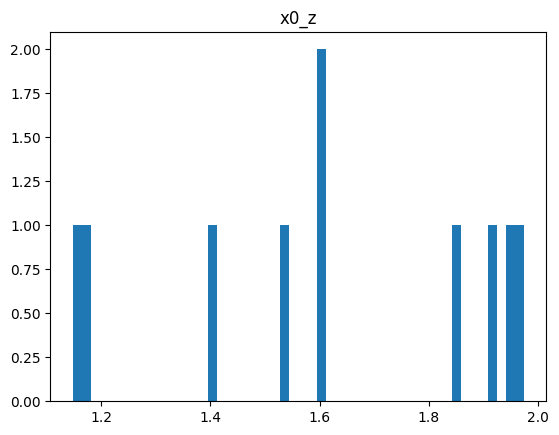

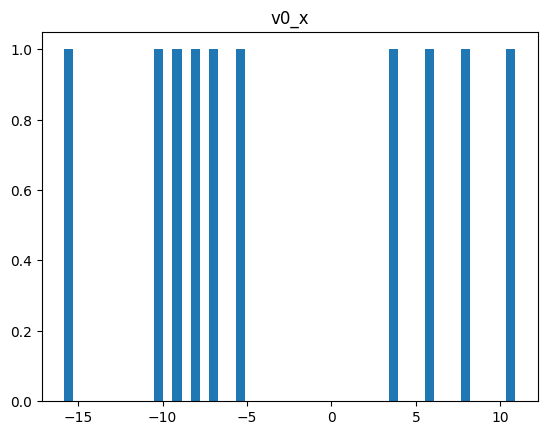

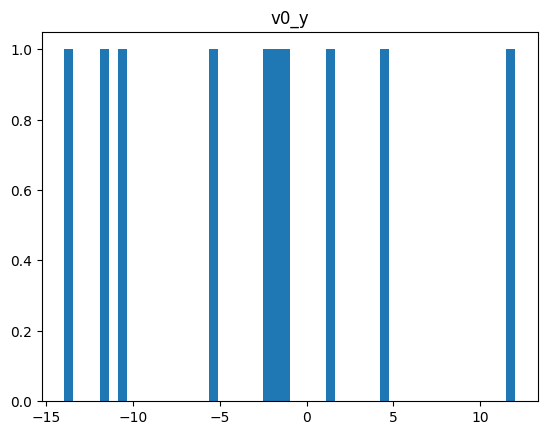

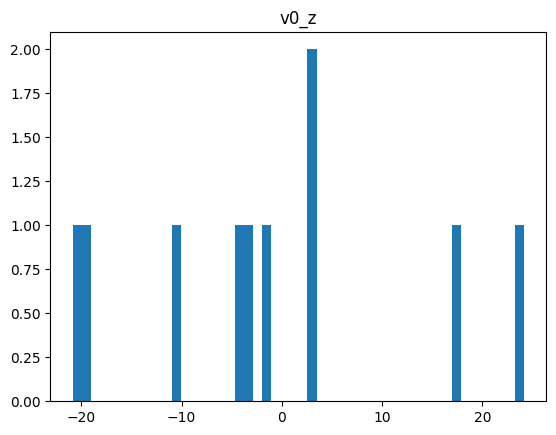

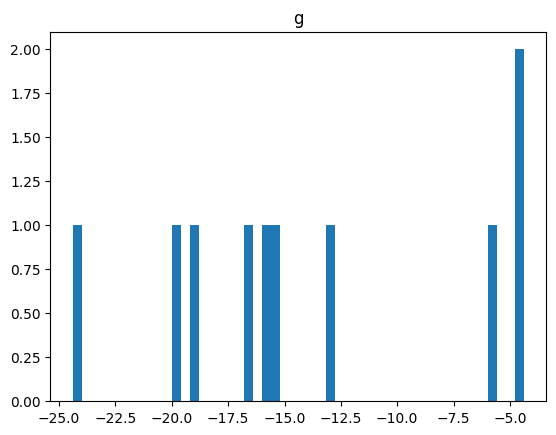

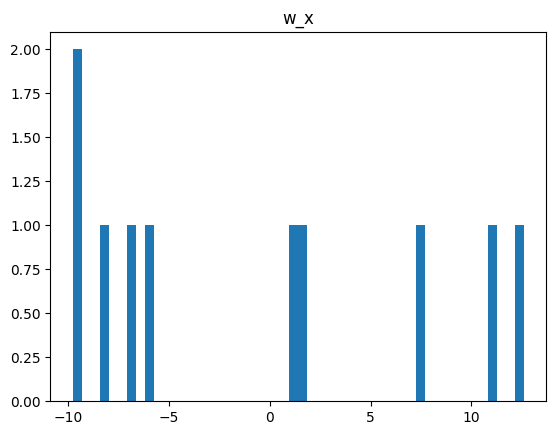

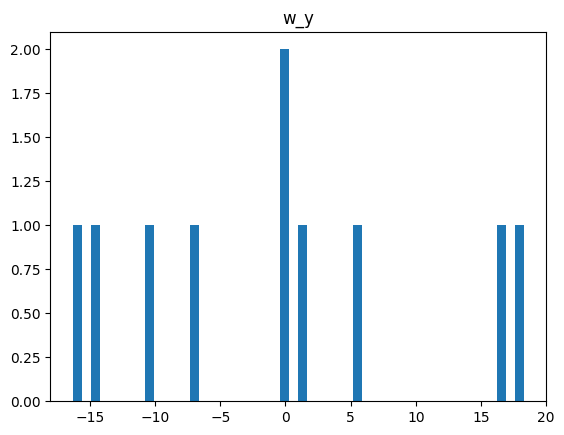

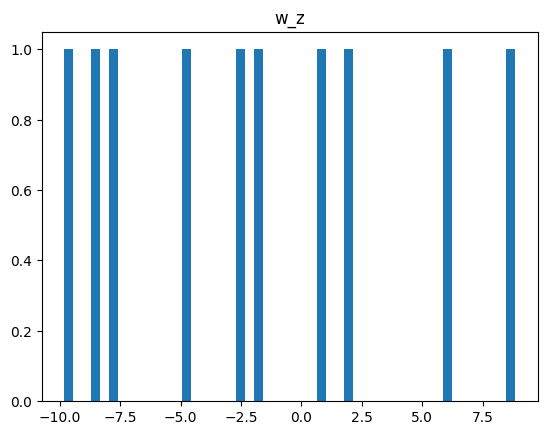

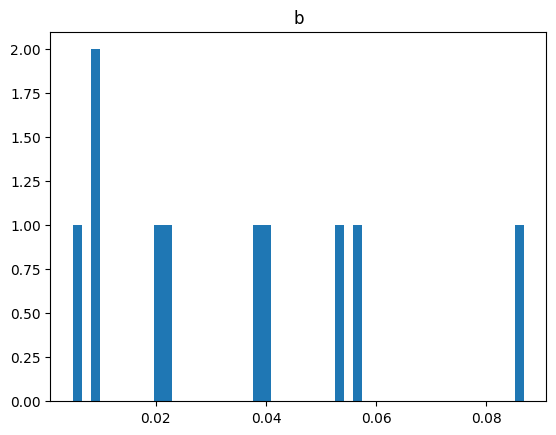

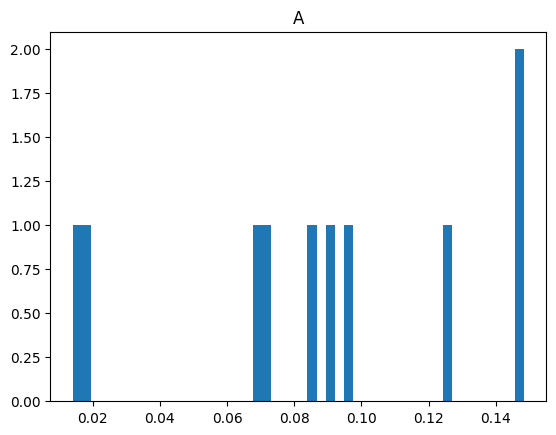

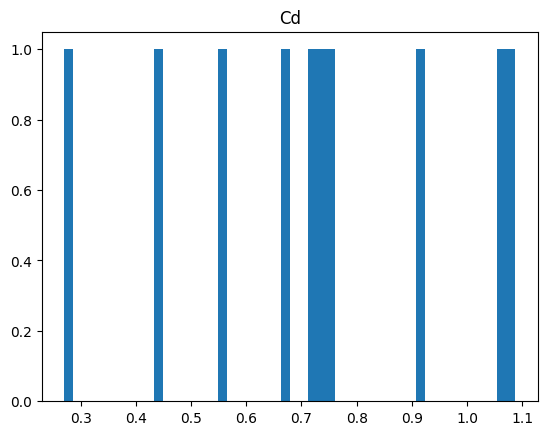

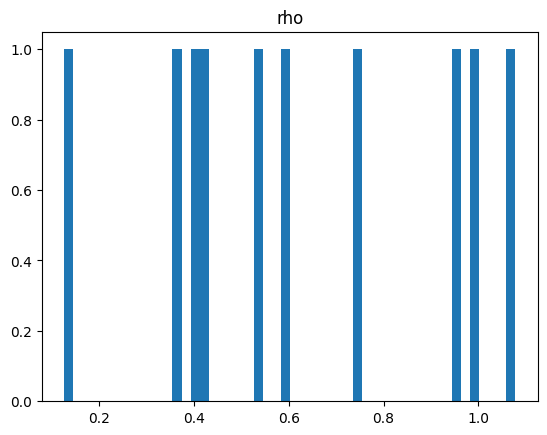

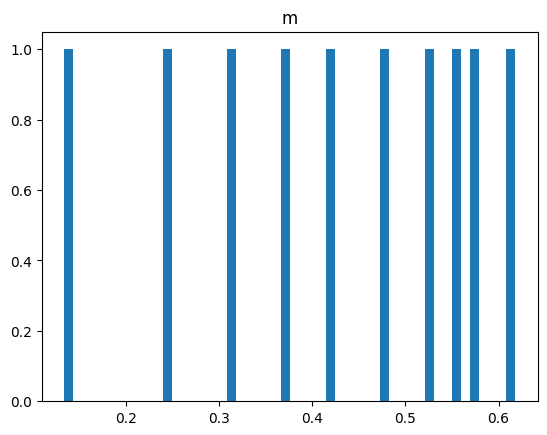

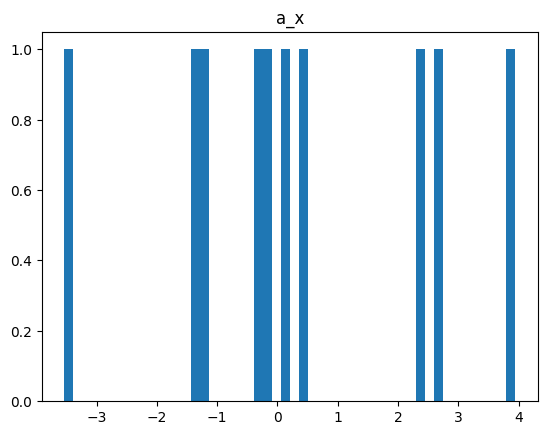

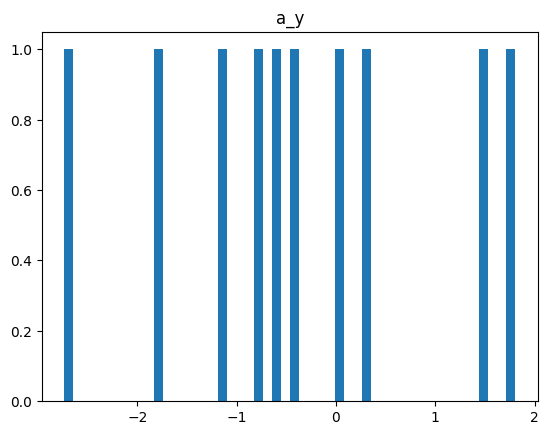

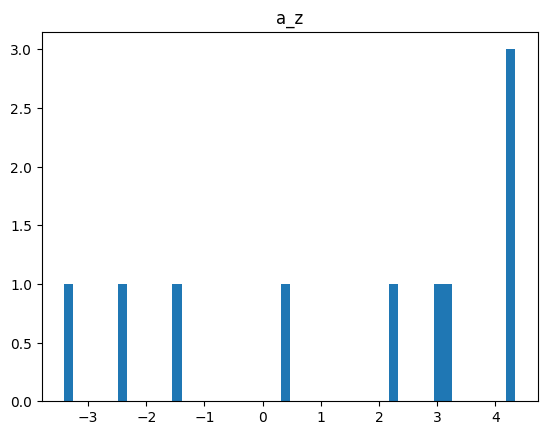

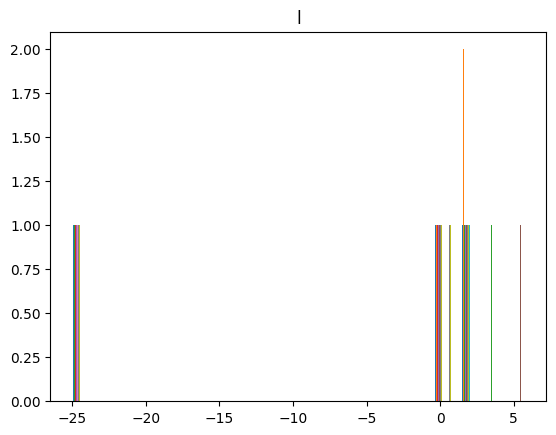

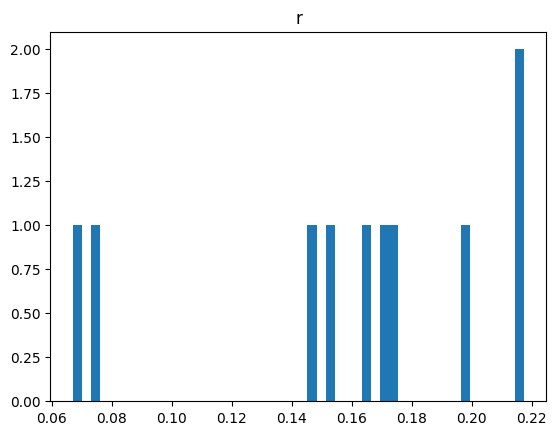

In [7]:
# plot each variable
for col in df.columns:
    plt.hist(df[col], bins=50)
    plt.title(col)
    plt.show()

    